### Research Project Code Implementation

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

<p>
Global variables were used to keep track of constant value that are meant to be held constant, output from computation for further processing and referencing.
</p>

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

<p>
For the all supervised learning algorithms used for research project implementation, the libraries used to assemble these algorithm organized them into a class with properties and methods to facilitate ease of use. A neural network will usually consist of input layer, hidden layer and the output layer. The ANN model implemented has one input layer, one output layer and one hidden layer. For ease of maintenance and reusability, the ANN model was built in to class and the section below show the implementation of ANN model.
</p>

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

<p>
A lot of functions were used for research project implementation to facilitate ease maintenance and for code reuse. The project implemented five machine learning models, two different experiments and two database which means that some of the function could have been used several times during this code implementation. To efficiently manage and maintain the code base, the collect of functions were implemented as shown below
</p>

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print("\n")
    print("\n")
    print("\n")
    for ax, feature in zip(axes, feature_column_list):
        
        if len(df[feature].value_counts()) >= 2:
            print("Summary for {} feature value counts".format(feature.upper()))
            print("\n")
            print(df[feature].value_counts())
            print("\n")
            print("\n")
            print("\n")
            title = "This is title for {} bar chart".format(feature.upper())
            plt.figure(figsize=(25,10))
            ax = df[feature].value_counts().plot(kind="bar")
            ax.set(title=title)
        
    plt.show()    
    

In [11]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print("\n")
    print("\n")
    print("\n")
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print("\n")
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print("\n")
        print("\n") 
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [15]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type): 
    for key in analysis_df_dict.keys():
        model = None
        start_time = time.time()
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [16]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [17]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [18]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [19]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
     
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    
    print("\n")
    print("\n")
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print("\n")
    print("\n")
    
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print("\n")
    print(classification_report(model_preditions, analysis_df_dict[dataset_key][y_test_key], target_names=["Normal", "Attack"]))
    
    
    print("\n")
    print("\n")
    print("\n")
    print("CONFUSION MATRIX")
    print("=========================================================")
    print("\n")
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print("\n")
    print("\n")
    print("\n")
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print("\n")
    auc_score = roc_auc_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

In [20]:
# This function is used to plot the correlation  heatmap for a selected group of features from the dataset

def show_correlation_heatmap_chart(df, title):
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(figsize=(18,20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, cmap=plt.cm.Reds, annot=True, mask=mask, linewidths=0.5, annot_kws={ "size": 10 })
    sns.set_style("white")
    plt.suptitle(title)
    plt.show()

In [21]:
# This function estimate the correlation between features the in a given dataset and select feature with high correlation.
# The correlation is said to be high if it is greater than the threshold argument given function. The function print out
# features with high correlation and the estimated value while returning a list of features name that has been marked 
# high

def estimate_correlation_to_select_highly_correlated_features(df, threshold):
    column_names = set()
    highly_corr_feature = dict()
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            computed_corr = correlation_matrix.iloc[i,j]
            if computed_corr > threshold:
                column_name = correlation_matrix.columns[i]
                column_name = correlation_matrix.columns[i]
                column_names.add(column_name)
                highly_corr_feature[column_name] = (computed_corr, correlation_matrix.columns[j])


    print("\n")
    print("\n")
    print("\n")
    print("FEATURES WITH HIGH CORRELATION VALUES")
    print("===================================================")
    for key in highly_corr_feature.keys():
        print("\n")
        print("Correlation between {} and {} feature is {}".format(key.upper(), highly_corr_feature[key][1].upper(), highly_corr_feature[key][0]))
        print("\n")

    print("\n")
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    return list(column_names)

In [22]:
def use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    
    if cv == None:
        model = RandomizedSearchCV(model, param_grid)
    else:
        model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, n_jobs = -1)
    
    return model

In [23]:
def use_GridSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    
    if cv == None:
        model = GridSearchCV(model, param_grid)
    else:
        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
        
    return model

In [24]:
def hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = NBC
        param_grid = {
            "var_smoothing": np.logspace(0,-9, num=100)
        }
        model = GaussianNB()
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)

        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [25]:
def hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = SVM
        tuned_parameters = {'kernel': ['linear', 'rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 50]}
        model = svm.SVC()
        model = use_GridSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [26]:
def hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = DTC
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 10),
            "min_samples_split": range(1, 10),
            "min_samples_leaf": range(1, 5)
        }
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [27]:
def hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = RFC
        param_grid = { 
            'n_estimators': [20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [80, 90, 100],
            'criterion' :['gini', 'entropy'],
            'bootstrap': [True],
        }
        model = RandomForestClassifier(n_estimators=30)
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [28]:
def hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = ANN
        batch_size = [20, 50, 100]
        epochs = [10, 50, 100]
        param_grid = dict(batch_size=batch_size, epochs=epochs)
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ "accuracy" ])
        model = ann.get_model()
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

#### Import Dataset into IDE

In [29]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = kdd_cup_df.sample(n=100000)
    unsw_nb15_df = unsw_nb15_df.sample(n=100000)
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [30]:
kdd_cup_df.head(100)

duration protocol_type  service flag  src_bytes  dst_bytes  land  \
4758109         0           tcp  private  REJ          0          0     0   
3835672         0           tcp  private   S0          0          0     0   
1575095         0          icmp    ecr_i   SF       1032          0     0   
854875          0           tcp     http   SF        237        413     0   
3915036         0           tcp  private   S0          0          0     0   
4857079         0          icmp    ecr_i   SF       1032          0     0   
857101          0           tcp     http   SF        213        433     0   
2712121         0          icmp    ecr_i   SF       1032          0     0   
184908          0           tcp     http   SF        213       1046     0   
4159213         0          icmp    ecr_i   SF        520          0     0   
1583181         0          icmp    ecr_i   SF       1032          0     0   
1710478         0          icmp    ecr_i   SF       1032          0     0   
2571359         0          icmp    ecr_i   SF       1032          0     0   
4839305         0          icmp    ecr_i   SF       1032          0     0   
4011994         0          icmp    ecr_i   SF        520          0     0   
968938          0          icmp    ecr_i   SF       1032          0     0   
1587271         0          icmp    ecr_i   SF       1032          0     0   
2569082         0          icmp    ecr_i   SF       1032          0     0   
4856511         0          icmp    ecr_i   SF       1032          0     0   
4642914         0           tcp  private  REJ          0          0     0   
1123745         0           tcp  private   S0          0          0     0   
377325          0           tcp     http   SF        318       6558     0   
2277058         0          icmp    ecr_i   SF       1032          0     0   
4698857         0           tcp  private  REJ          0          0     0   
1702319         0          icmp    ecr_i   SF       1032          0     0   
4349514         0          icmp    ecr_i   SF        520          0     0   
75220           6           tcp     smtp   SF       2250        327     0   
3558194         0           tcp  private   S0          0          0     0   
2823329         0          icmp    ecr_i   SF       1032          0     0   
2950450         0          icmp    ecr_i   SF       1032          0     0   
1980578         0          icmp    ecr_i   SF       1032          0     0   
1923605         0          icmp    ecr_i   SF       1032          0     0   
3322698         0          icmp    ecr_i   SF       1032          0     0   
479343          0          icmp    ecr_i   SF       1032          0     0   
3760625         0           tcp  private   S0          0          0     0   
1276215         0          icmp    ecr_i   SF       1032          0     0   
4664697         0           tcp  private  REJ          0          0     0   
2767471         0          icmp    ecr_i   SF       1032          0     0   
1817070         0          icmp    ecr_i   SF       1032          0     0   
3102735         0          icmp    ecr_i   SF       1032          0     0   
1617044         0          icmp    ecr_i   SF       1032          0     0   
1469547         0          icmp    ecr_i   SF       1032          0     0   
1946588         0          icmp    ecr_i   SF       1032          0     0   
157374          0           tcp     smtp   SF        907        336     0   
3049942         0          icmp    ecr_i   SF       1032          0     0   
1575519         0          icmp    ecr_i   SF       1032          0     0   
1047674         0           tcp     http   SF        200      18983     0   
3534965         0           tcp  private   S0          0          0     0   
2334818         0          icmp    ecr_i   SF       1032          0     0   
243539          0           tcp     http   SF        238       2117     0   
2662150         0          icmp    ecr_i   SF       1032          0     0   
36479

In [31]:
unsw_nb15_df.head(100)

id        dur  proto   service state  spkts  dpkts  sbytes  \
170833   88502   0.967320    tcp         -   FIN     14     14     778   
119044   36713   1.251580    tcp      http   FIN     14     18    1684   
224630  142299   0.000003    udp       dns   INT      2      0     114   
62522    62523   1.397186    tcp         -   FIN     10      8     564   
187511  105180   0.647762    tcp         -   FIN     32     12   27328   
30044    30045   1.170000    tcp      http   FIN     12     18    1580   
113888   31557   0.001043    udp       dns   CON      2      2     130   
77270    77271   0.728109    tcp         -   FIN     14     12    1082   
232852  150521   0.000003    udp       dns   INT      2      0     114   
251380  169049   0.000003    udp       dns   INT      2      0     114   
170655   88324   0.000009   unas         -   INT      2      0     200   
153933   71602   0.609796    tcp  ftp-data   FIN      8      8     364   
194830  112499   0.796928    tcp         -   FIN     10      6     756   
148012   65681   0.650227    tcp      http   FIN     10      6     888   
59446    59447   0.000011    udp       dns   INT      2      0     114   
164476   82145   0.486759    tcp         -   FIN     10      6     502   
233239  150908   0.000006    udp       dns   INT      2      0     114   
125131   42800   0.000021    udp         -   INT      2      0      78   
127384   45053   0.000011    udp         -   INT      2      0    1860   
103948   21617   0.001163    udp       dns   CON      2      2     130   
141350   59019   0.000008    igp         -   INT      2      0     180   
182993  100662  53.082527   ospf         -   REQ     20      0    2160   
229523  147192   0.000003    udp       dns   INT      2      0     114   
179571   97240   1.214437    tcp         -   FIN     14     12     774   
177455   95124   0.944265    tcp         -   FIN     12     10    1036   
7992      7993   0.000003   unas         -   INT      2      0     200   
124557   42226   0.000010    udp         -   INT      2      0    1064   
48710    48711   0.623633    tcp      http   FIN     12     10    2154   
93389    11058   0.017147    udp         -   CON      4      4     528   
99569    17238   0.000978    udp       dns   CON      2      2     146   
38162    38163   0.020006    tcp         -   FIN     48     50    2958   
33330    33331   0.790260    udp         -   CON      4      4     568   
219328  136997   0.000005   unas         -   INT      2      0     200   
131753   49422   0.000009   isis         -   INT      2      0     200   
51958    51959   0.000003   pnni         -   INT      2      0     200   
33398    33399   0.018653    tcp         -   FIN     46     48    2854   
84344     2013   0.017956    tcp         -   FIN     16     18    1540   
229069  146738   0.000007    udp       dns   INT      2      0     114   
202813  120482   1.638474    tcp         -   FIN     12      8    1466   
252670  170339   0.000007    udp         -   INT      2      0    1064   
39110    39111   0.038856    tcp         -   FIN     84     86    4862   
197645  115314   0.000006   unas         -   INT      2      0     200   
238030  155699   0.000008    udp       dns   INT      2      0     114   
197060  114729   0.000000    arp         -   INT      1      0      46   
95502    13171   0.006362    tcp         -   FIN     24     24    2062   
72991    72992  40.355473    tcp         -   FIN     24     14    8500   
251760  169429   0.000006    igp         -   INT      2      0     180   
15570    15571   0.000004    udp       dns   INT      2      0     114   
97728    15397   0.005203    tcp         -   FIN     26     24    2166   
189935  107604   0.000005   ippc         -   INT      2      0     200   
64683    64684   0.227620    tcp         -   FIN     10      8     766   
32451    32452   1.006268    tcp      http   FIN     14     18    1684   
17175    17176   0.000008    udp       dns   INT      2      0     114   
46288    46289  

In [32]:
kdd_cup_df.shape

(100000, 42)

In [33]:
unsw_nb15_df.shape

(100000, 45)

In [34]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [35]:
unsw_nb15_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [36]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4758109 to 2627576
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     100000 non-null  int64  
 1   protocol_type                100000 non-null  object 
 2   service                      100000 non-null  object 
 3   flag                         100000 non-null  object 
 4   src_bytes                    100000 non-null  int64  
 5   dst_bytes                    100000 non-null  int64  
 6   land                         100000 non-null  int64  
 7   wrong_fragment               100000 non-null  int64  
 8   urgent                       100000 non-null  int64  
 9   hot                          100000 non-null  int64  
 10  num_failed_logins            100000 non-null  int64  
 11  logged_in                    100000 non-null  int64  
 12  num_compromised              100000 non-null  int64

In [37]:
unsw_nb15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 170833 to 241300
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 100000 non-null  int64  
 1   dur                100000 non-null  float64
 2   proto              100000 non-null  object 
 3   service            100000 non-null  object 
 4   state              100000 non-null  object 
 5   spkts              100000 non-null  int64  
 6   dpkts              100000 non-null  int64  
 7   sbytes             100000 non-null  int64  
 8   dbytes             100000 non-null  int64  
 9   rate               100000 non-null  float64
 10  sttl               100000 non-null  int64  
 11  dttl               100000 non-null  int64  
 12  sload              100000 non-null  float64
 13  dload              100000 non-null  float64
 14  sloss              100000 non-null  int64  
 15  dloss              100000 non-null  int64  
 1

In [38]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

In [39]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [40]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

eda_kdd_cup_df[target_variable] = eda_kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

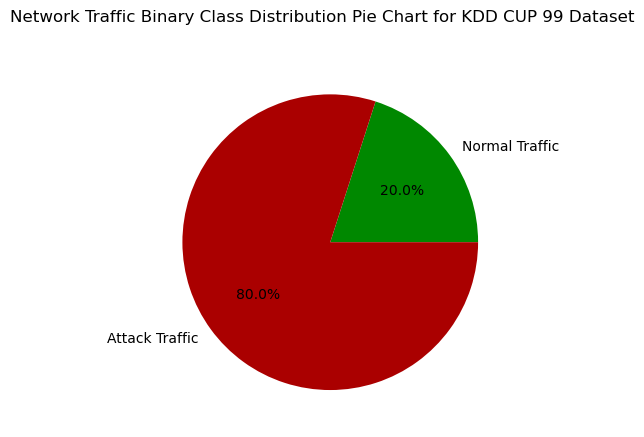

In [41]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

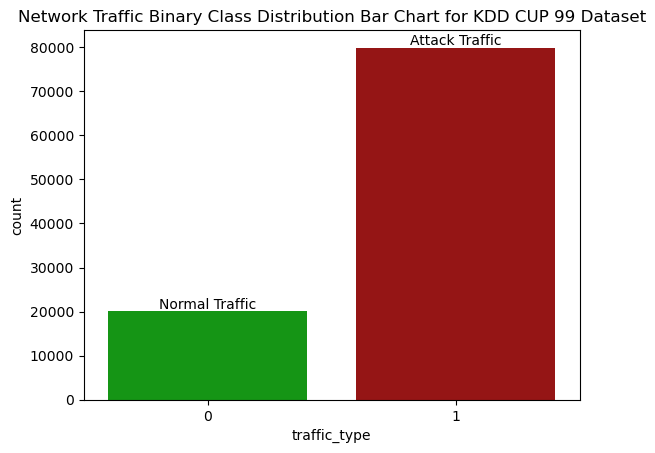

In [42]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

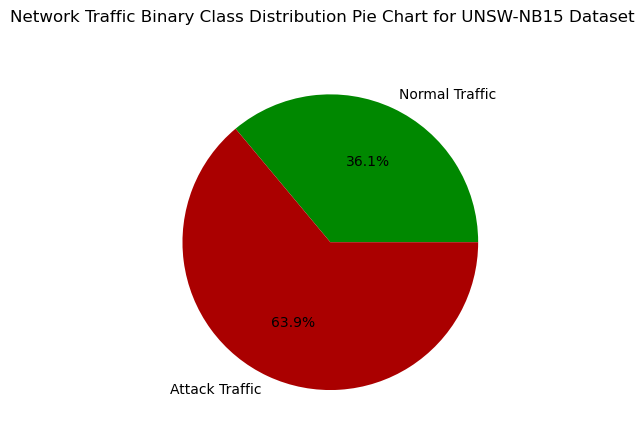

In [43]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

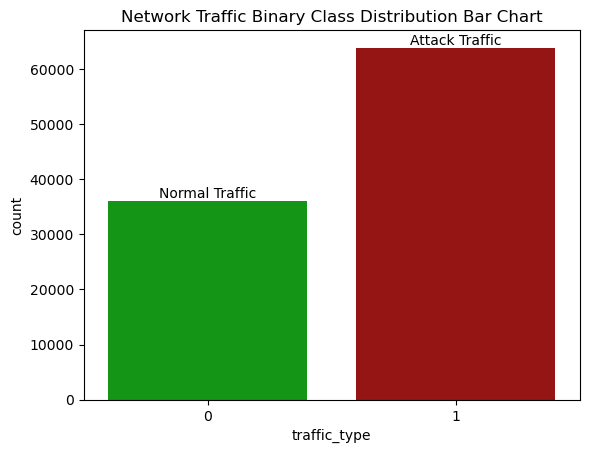

In [44]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [45]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [46]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [47]:
print("KDD CUP 99 dataset categorical variables count is {}".format(len(eda_kdd_cup_99_categorical_features)))
print("KDD CUP 99 dataset continuous variables count is {}".format(len(eda_kdd_cup_99_continuous_features)))

KDD CUP 99 dataset categorical variables count is 18
KDD CUP 99 dataset continuous variables count is 23


In [48]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)

In [49]:
print("UNSW-NB 15 dataset categorical variables count is {}".format(len(eda_unsw_nb15_categorical_features)))
print("UNSW-NB 15 dataset continuous variables count is {}".format(len(eda_unsw_nb15_continuous_features)))

UNSW-NB 15 dataset categorical variables count is 10
UNSW-NB 15 dataset continuous variables count is 33








Summary for SERVICE feature value counts


ecr_i          57436
private        22345
http           12799
smtp            1982
other           1490
domain_u        1225
ftp_data         838
eco_i            295
finger           132
urp_i            111
ftp              109
telnet            84
ntp_u             83
auth              66
pop_3             36
netbios_dgm       32
bgp               30
echo              30
csnet_ns          29
remote_job        29
time              28
ssh               27
supdup            26
uucp_path         26
domain            26
pop_2             26
nnsp              25
netbios_ssn       25
exec              25
Z39_50            24
link              24
ctf               24
ldap              23
courier           23
efs               23
name              23
systat            23
mtp               22
gopher            22
rje               21
netbios_ns        21
sunrpc            20
whois             19
daytime           19
printer           19
sql_ne

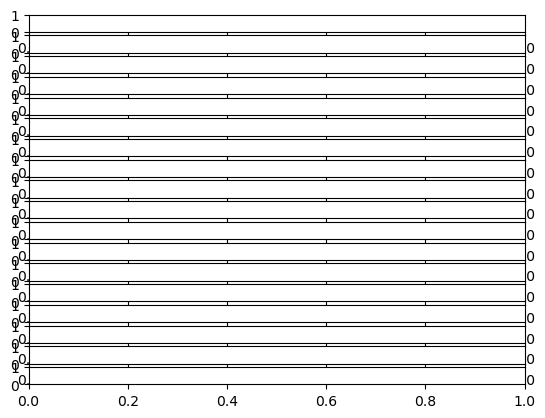

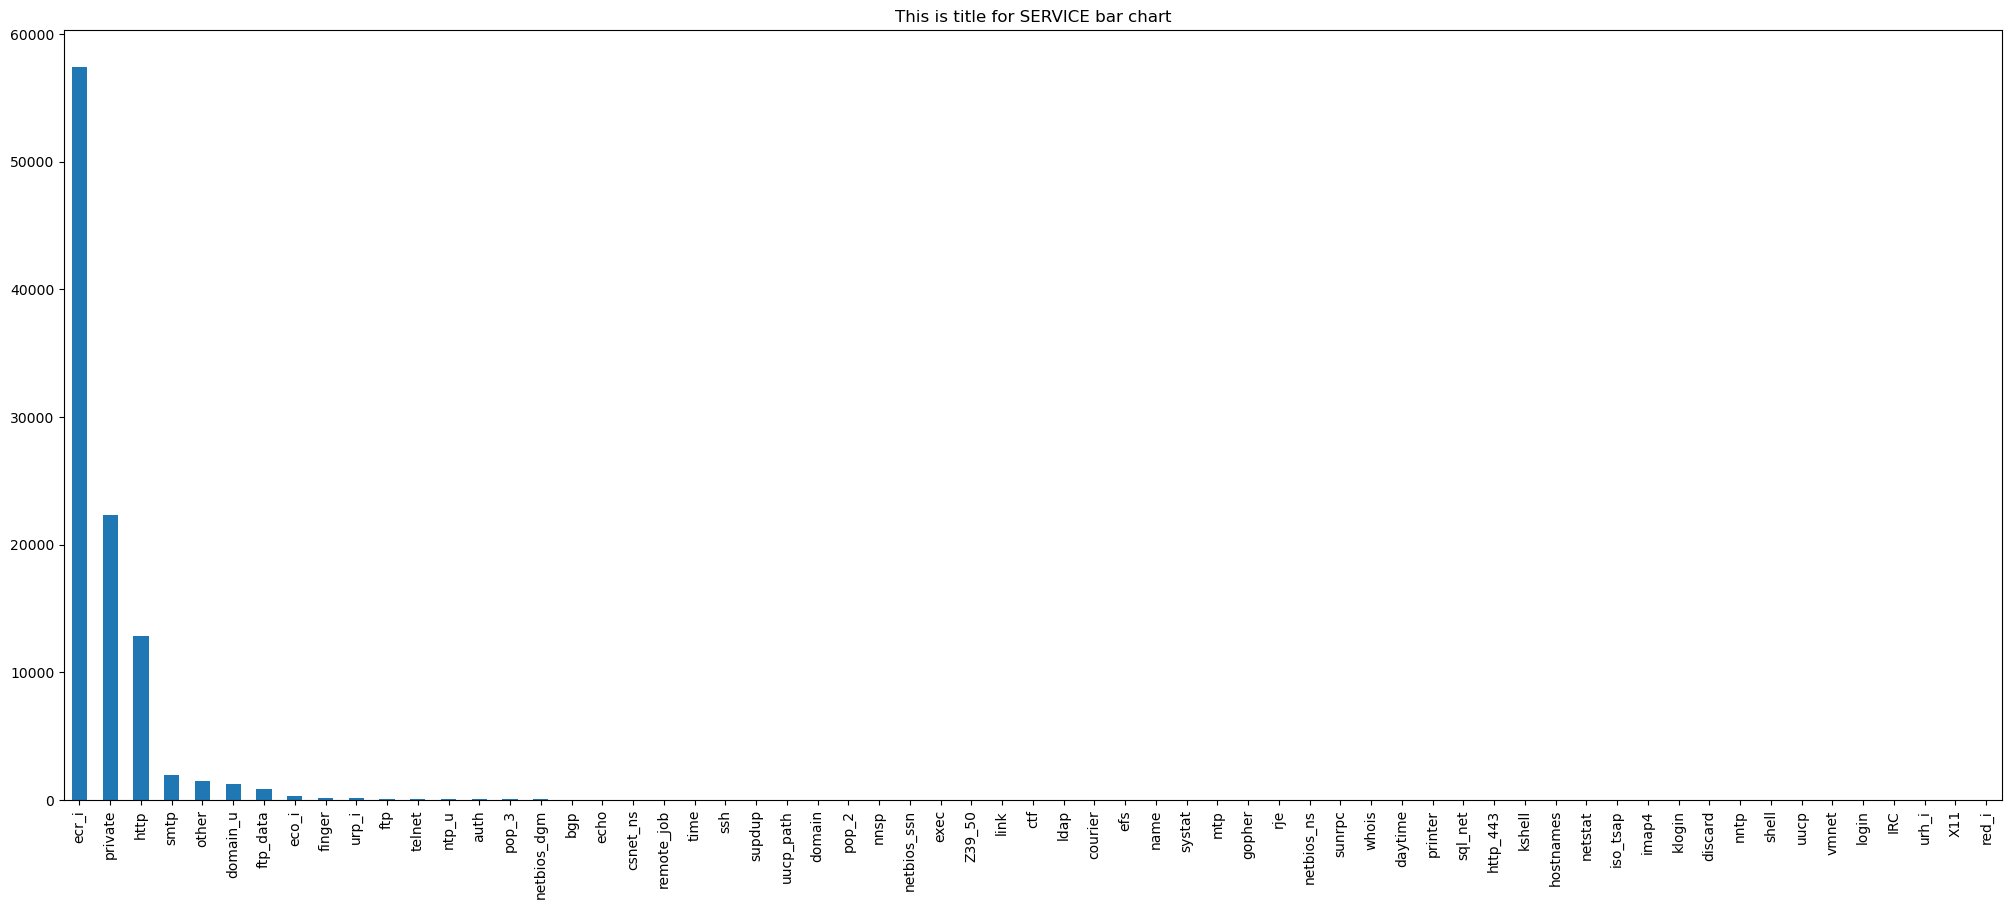

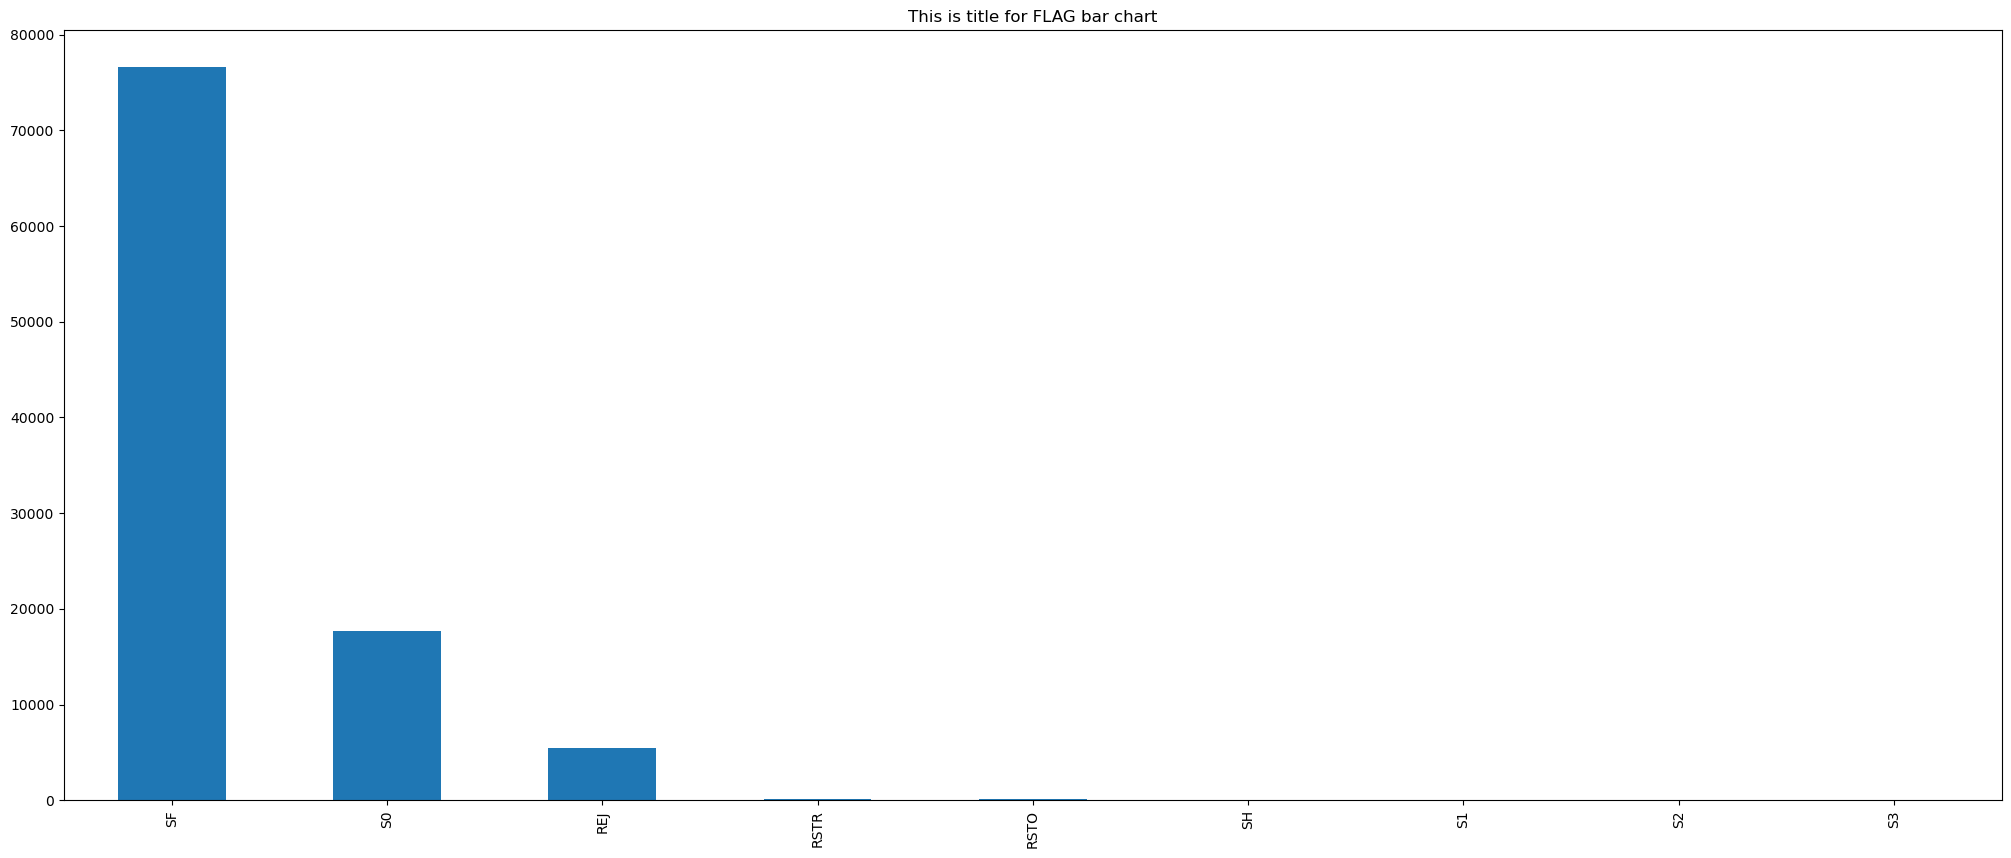

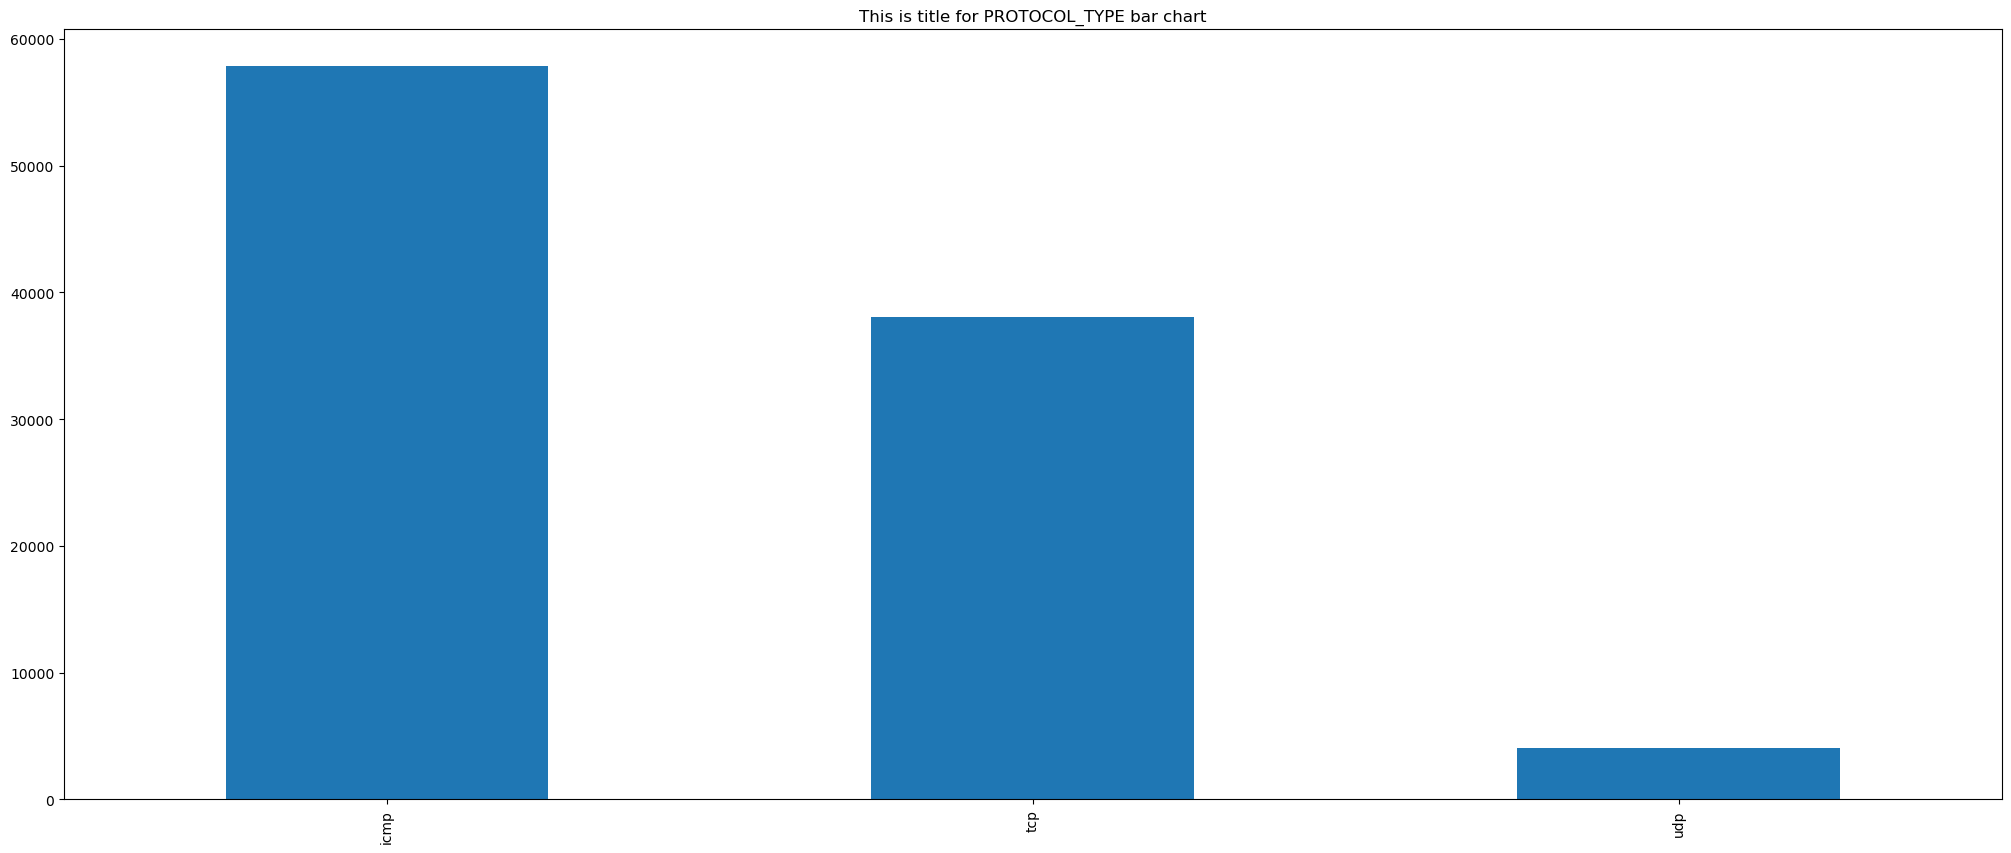

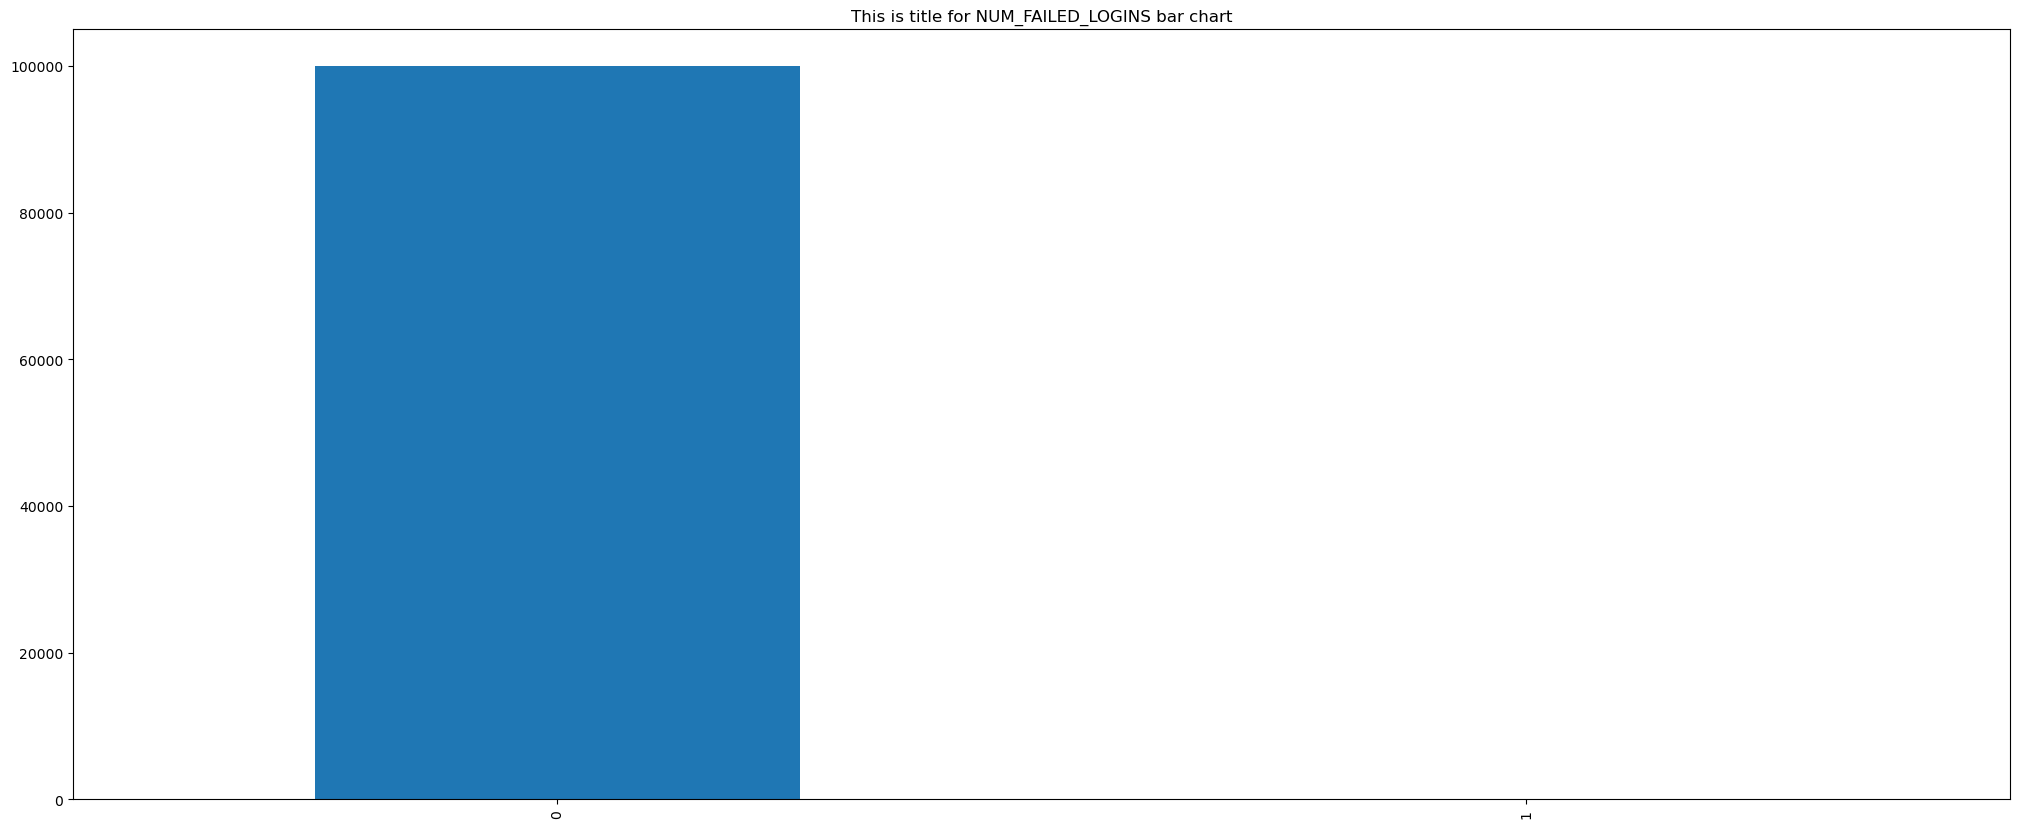

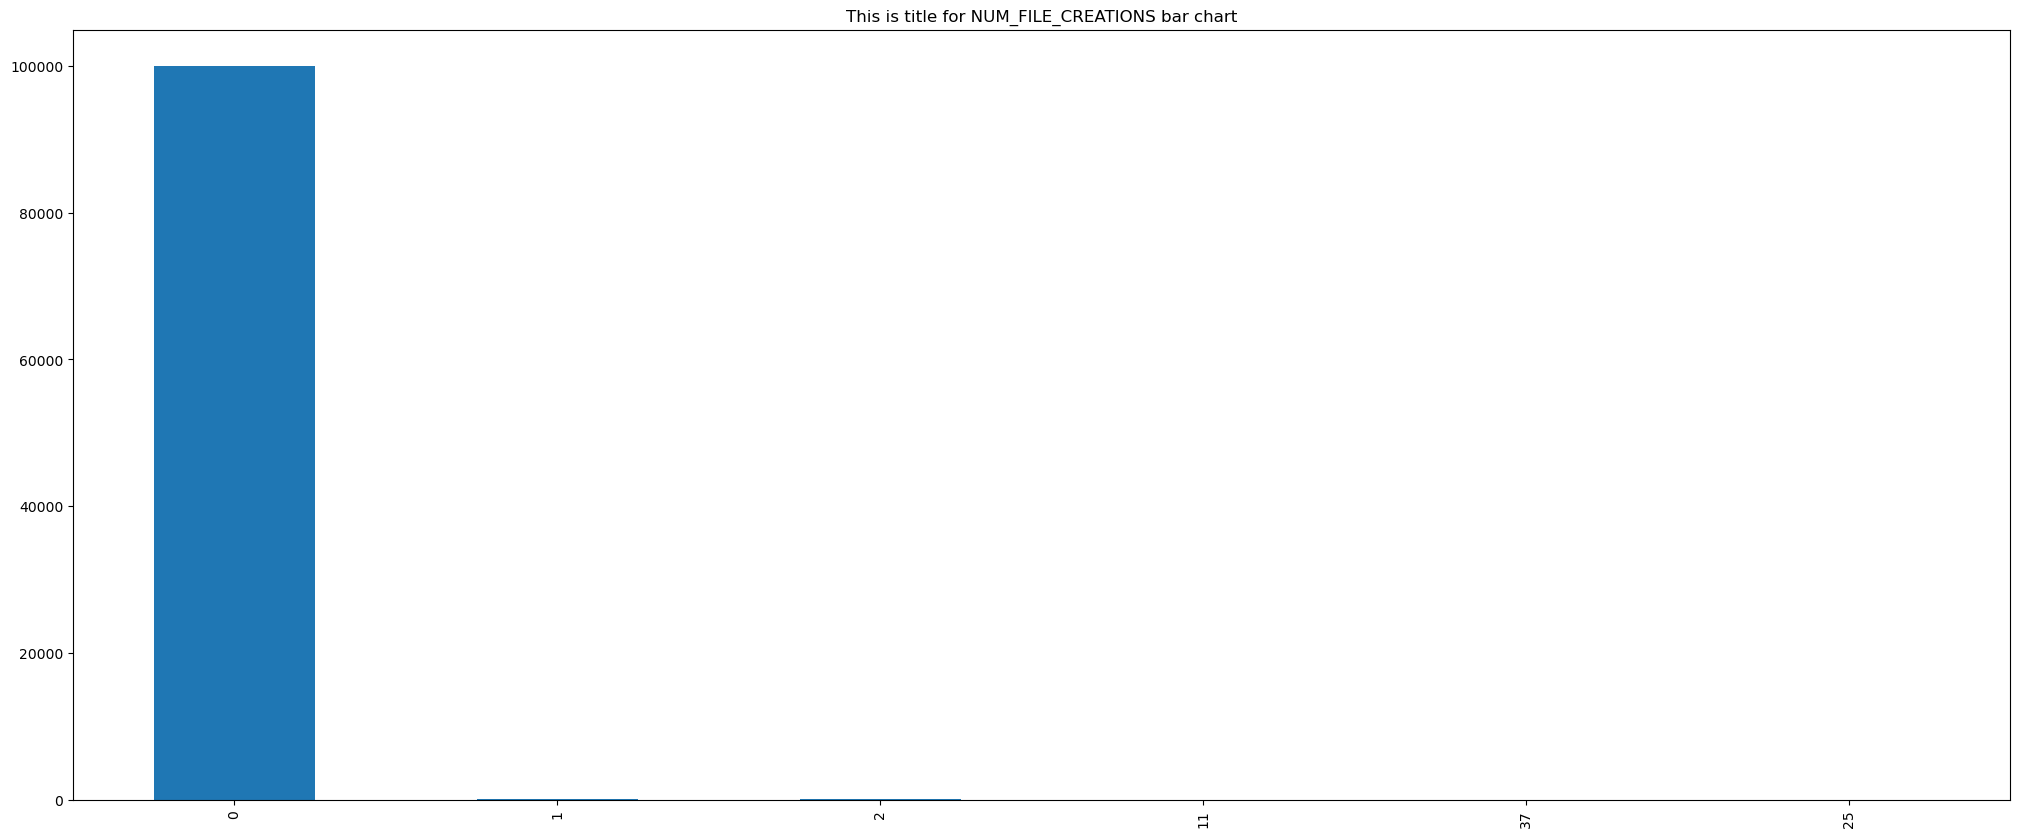

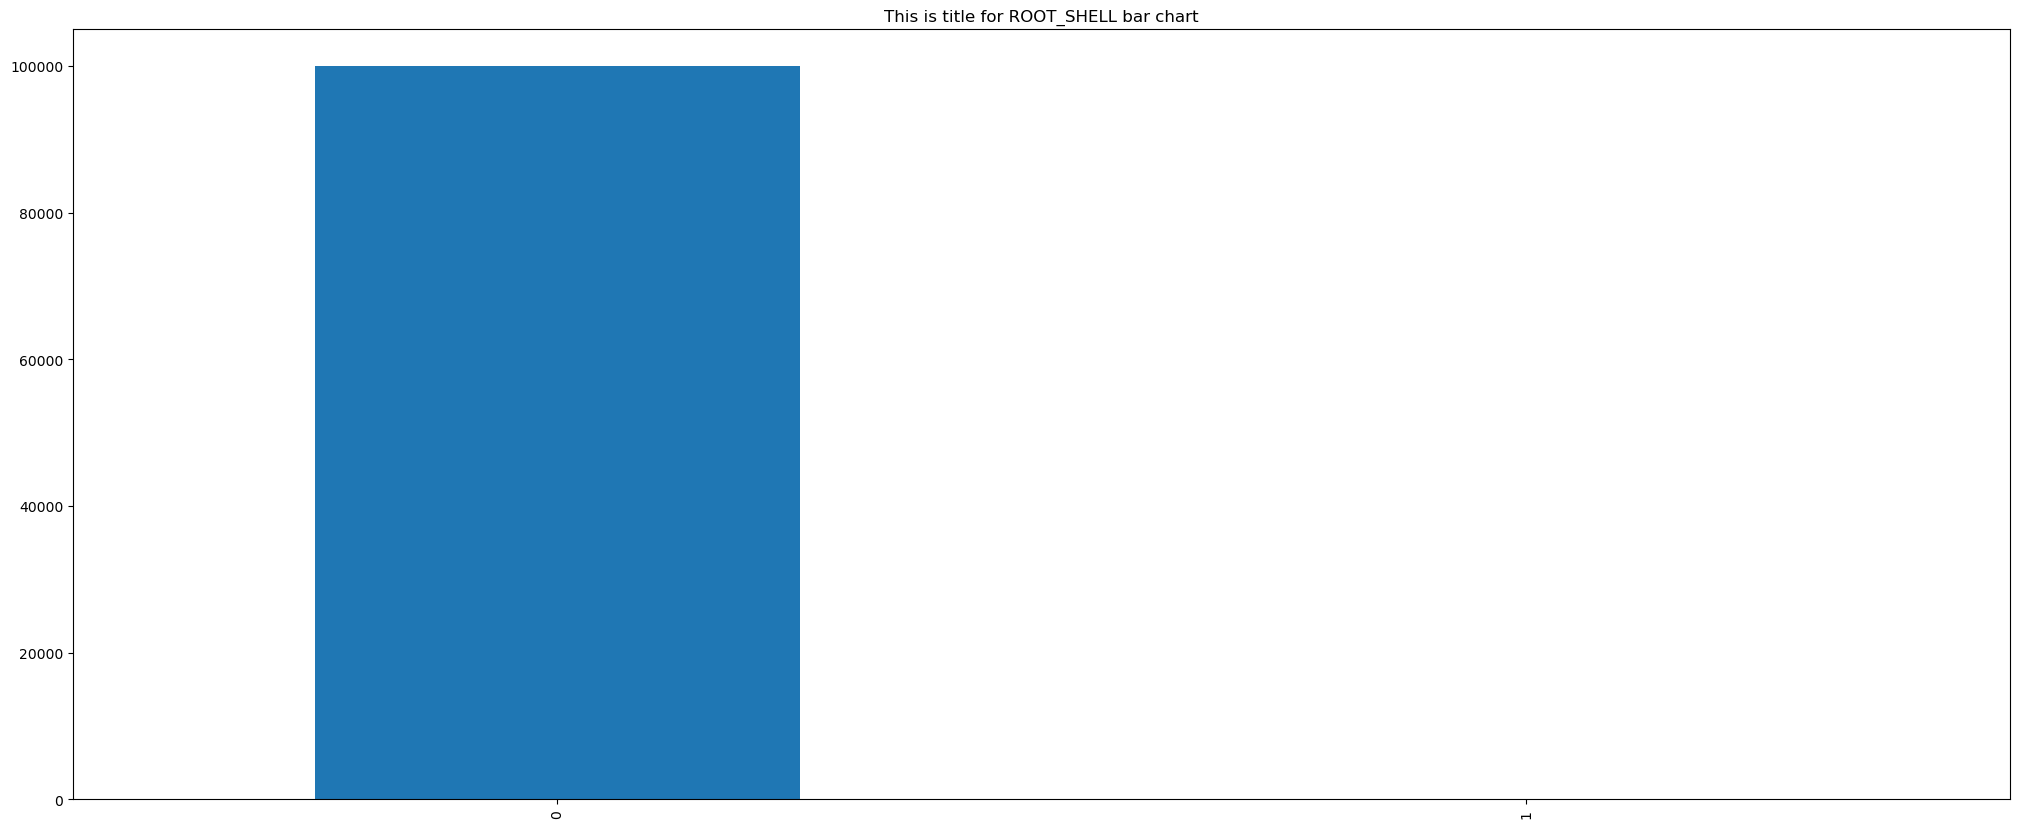

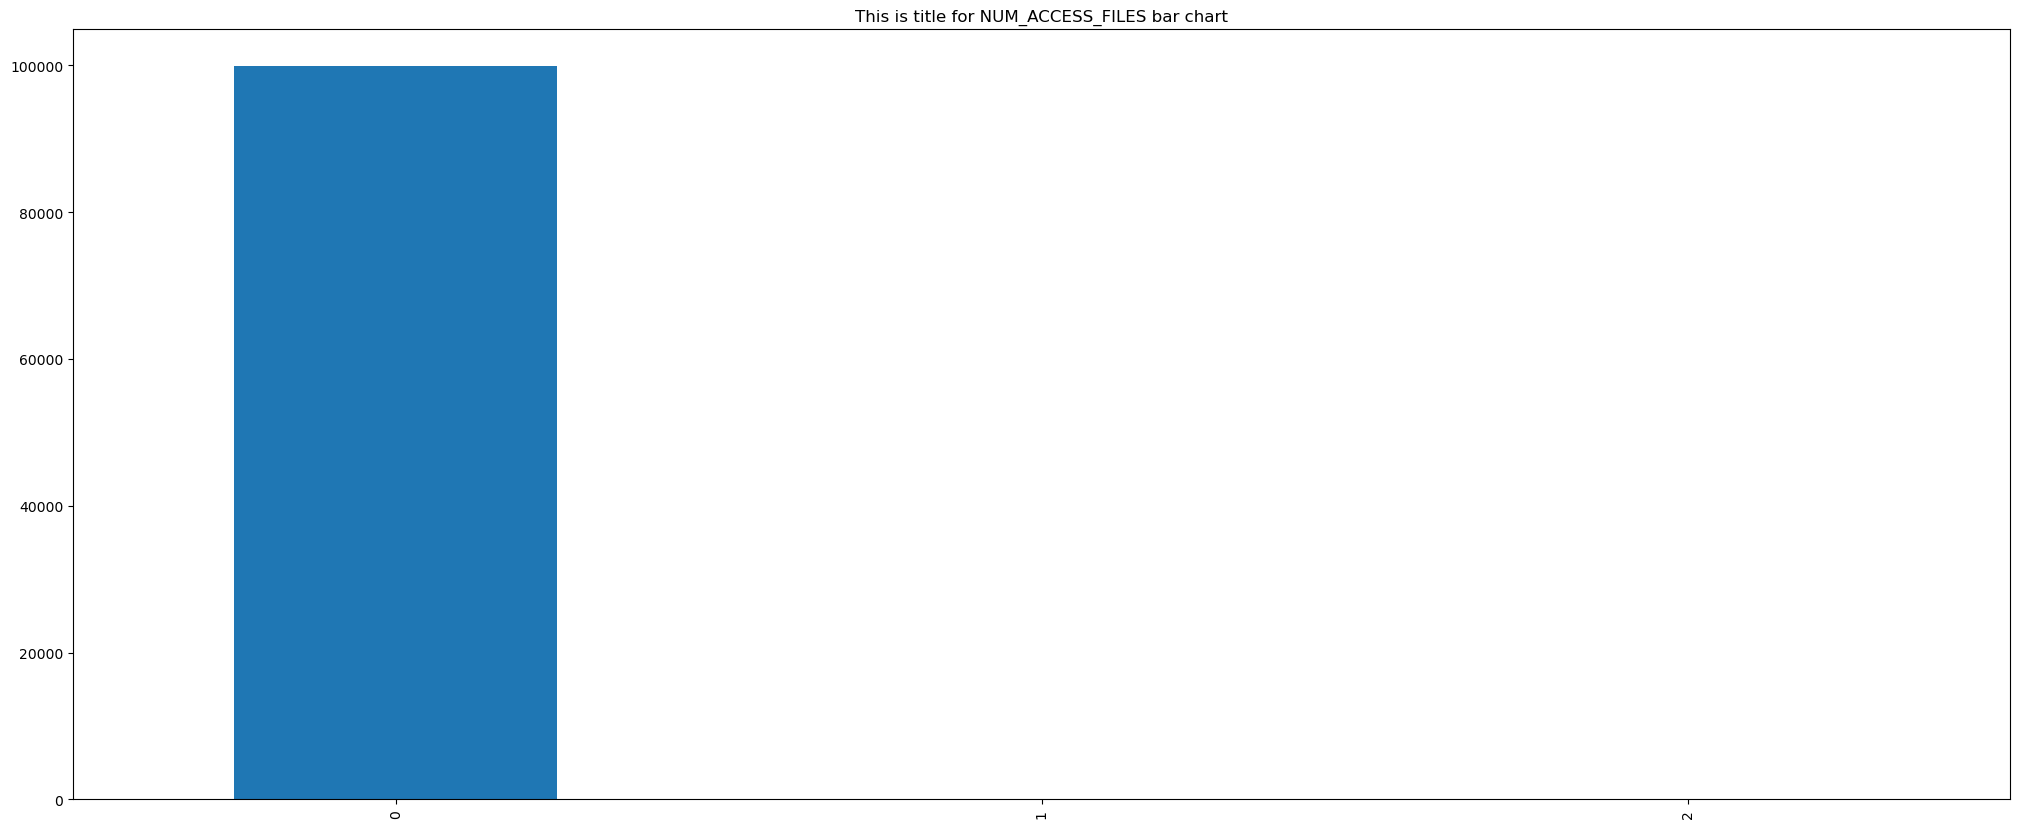

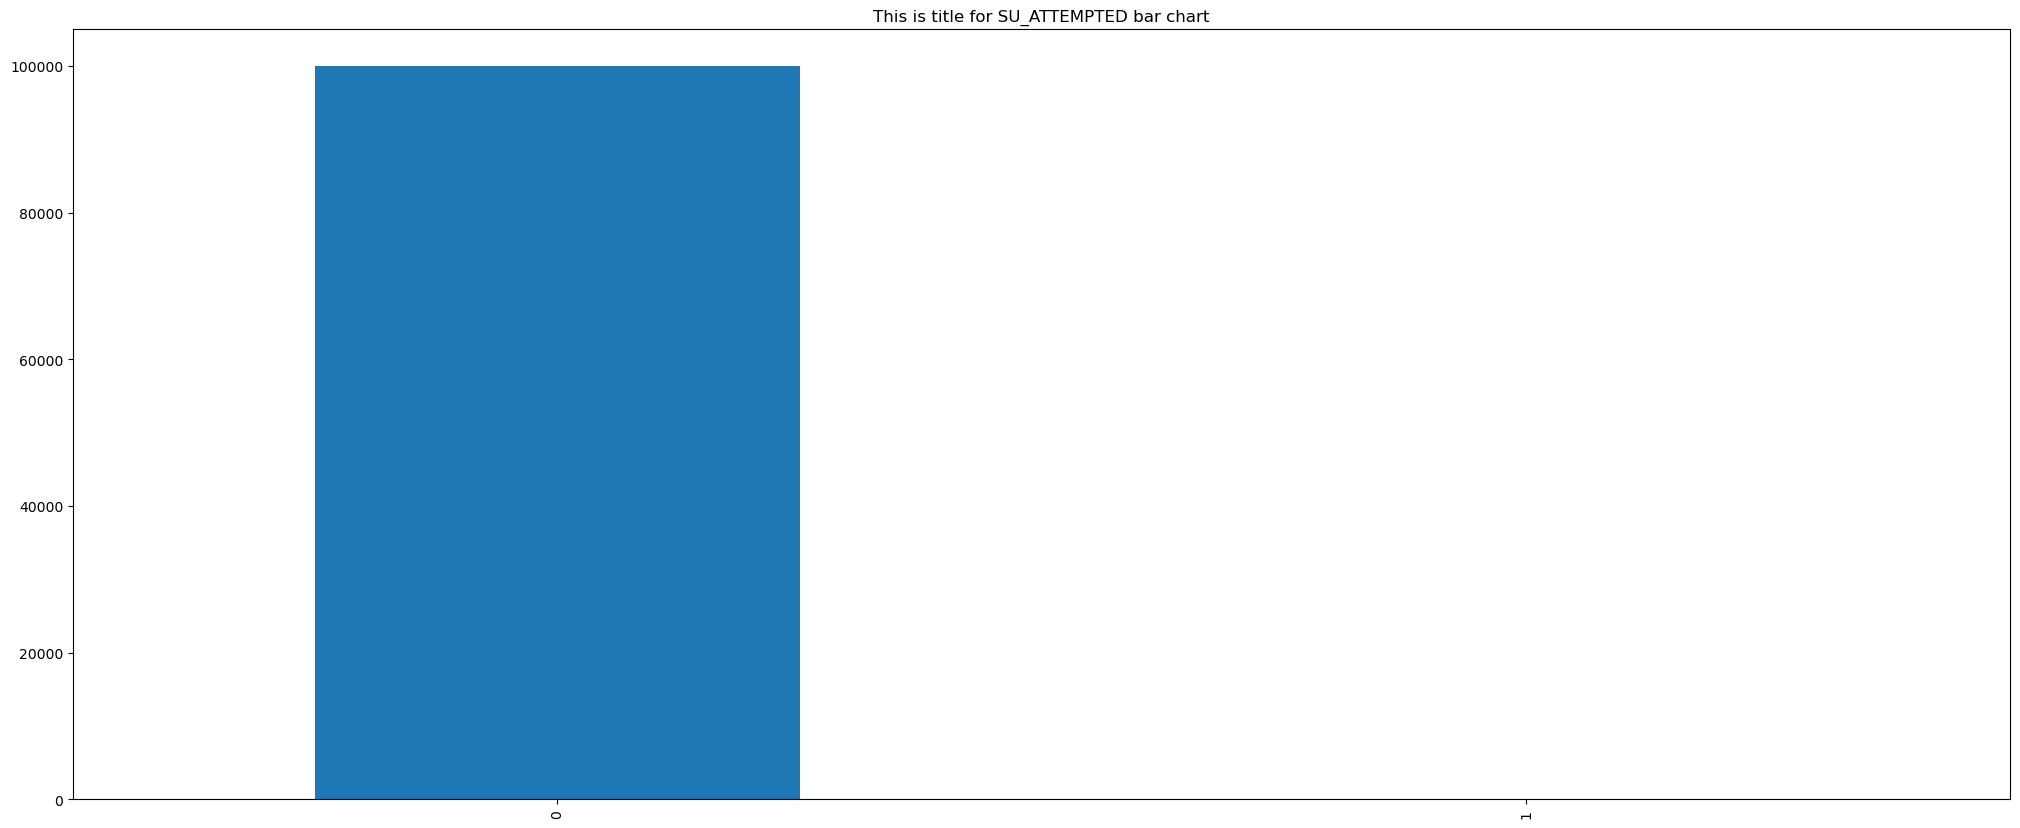

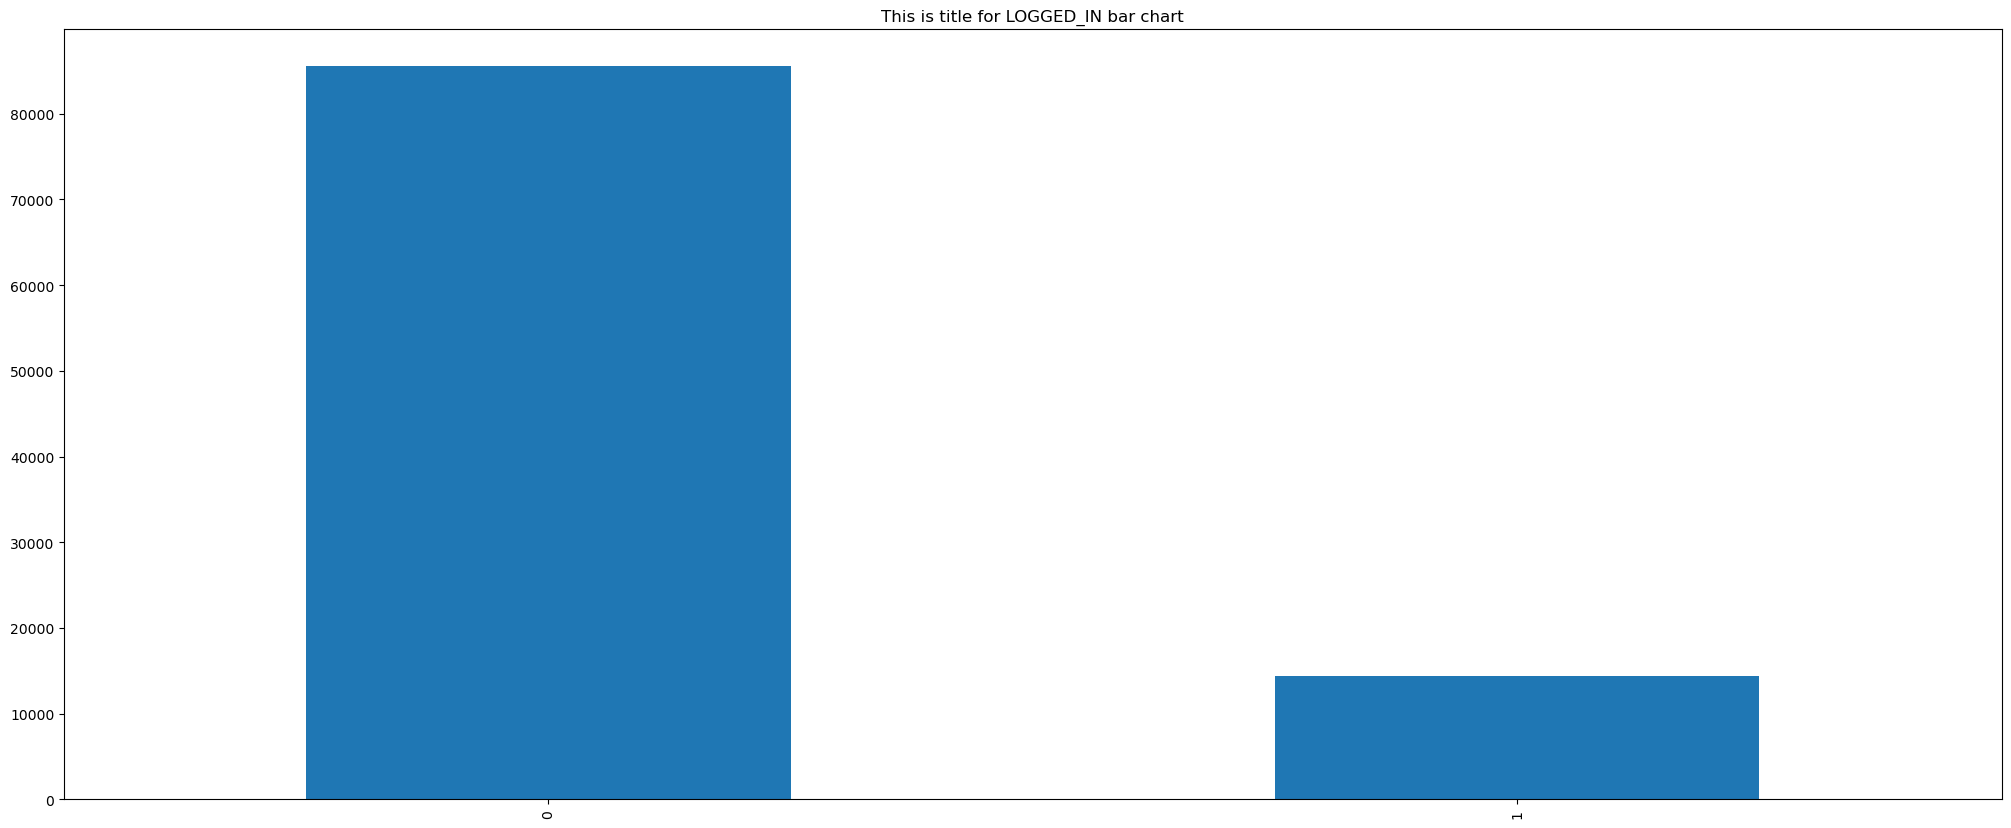

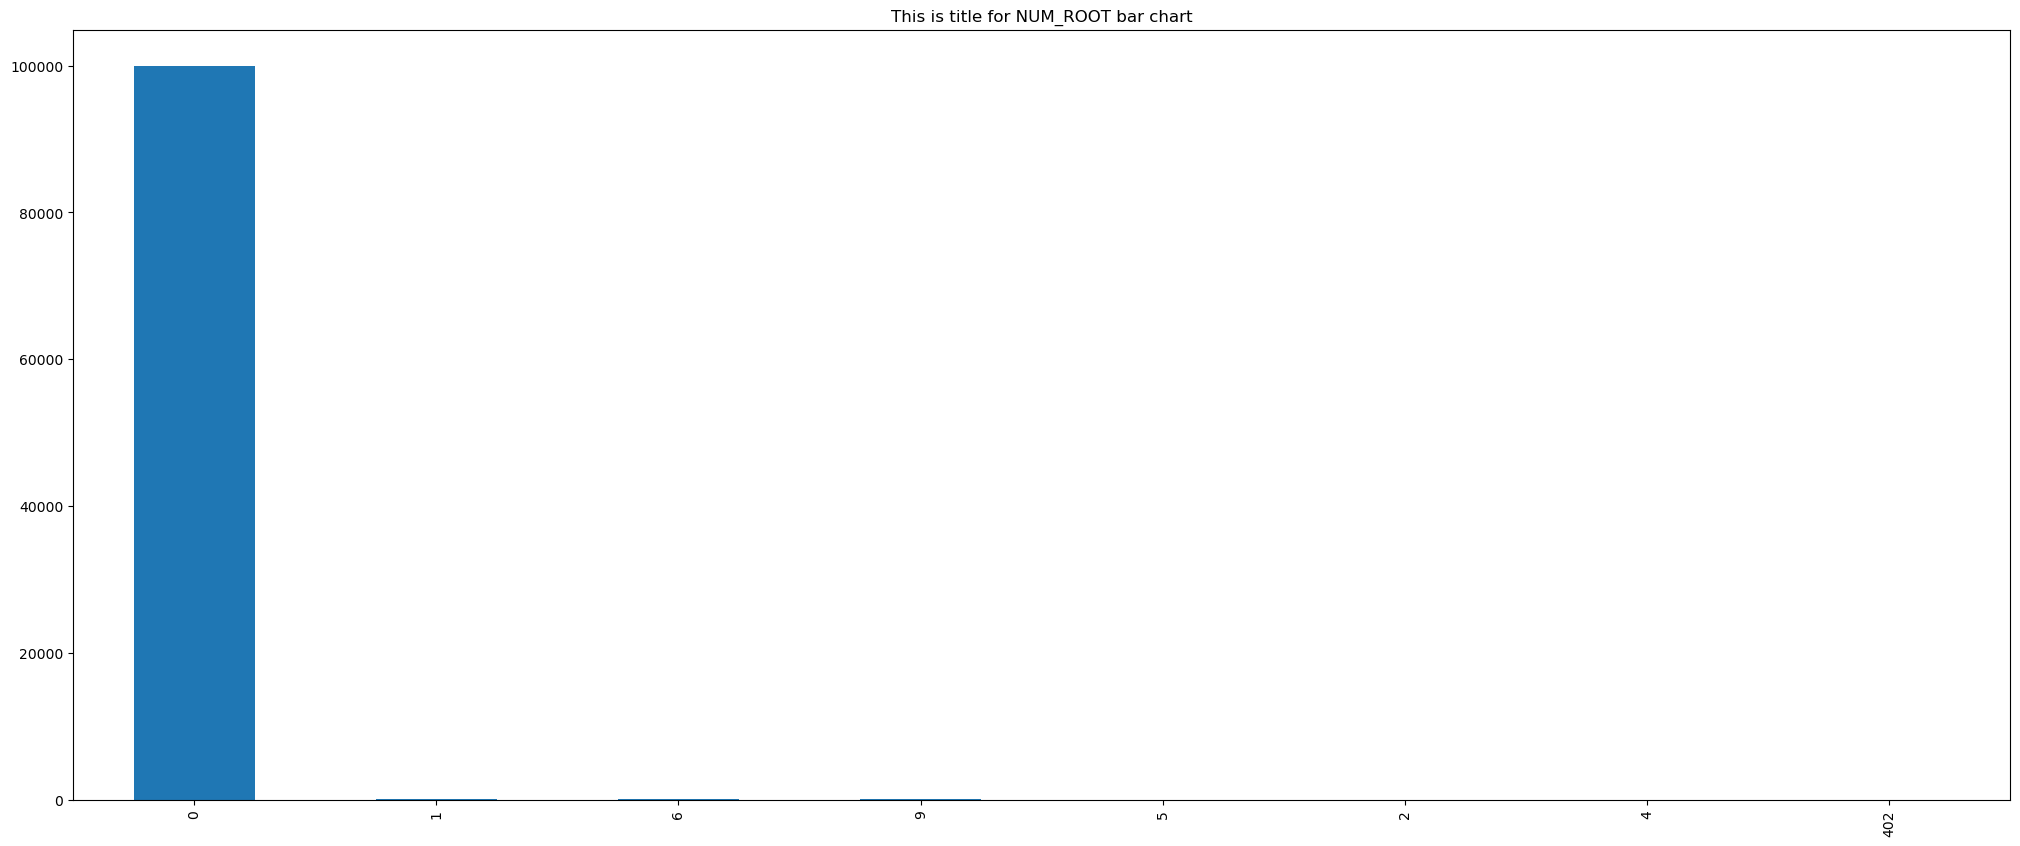

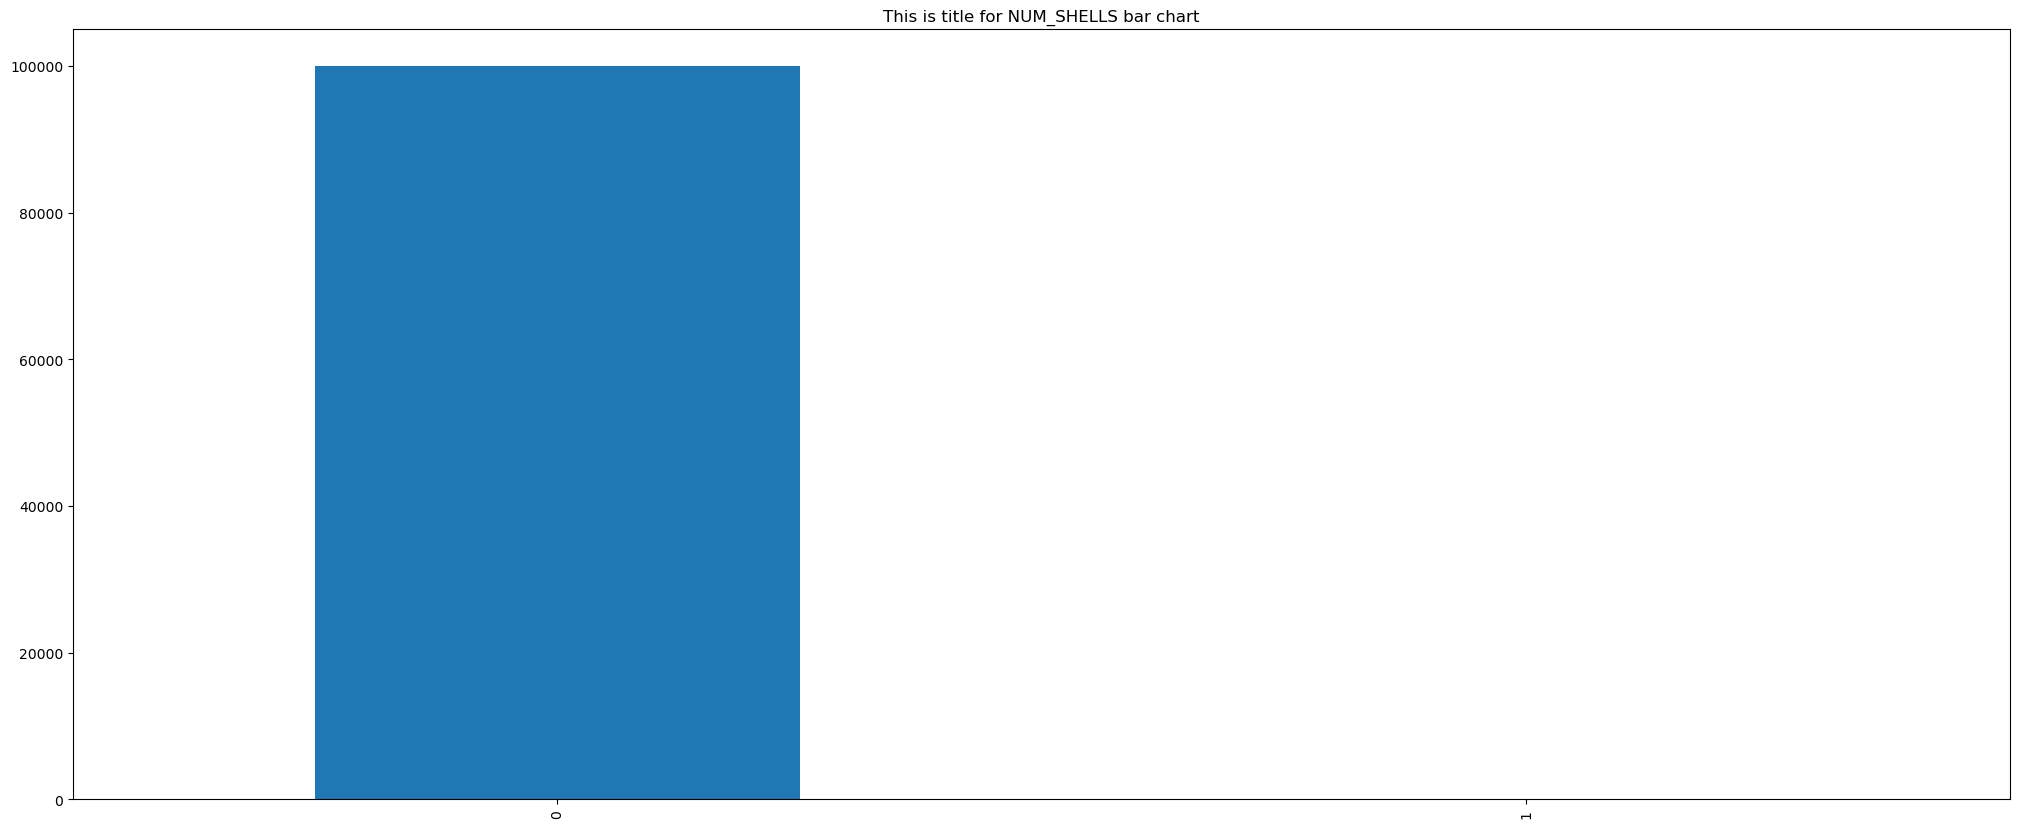

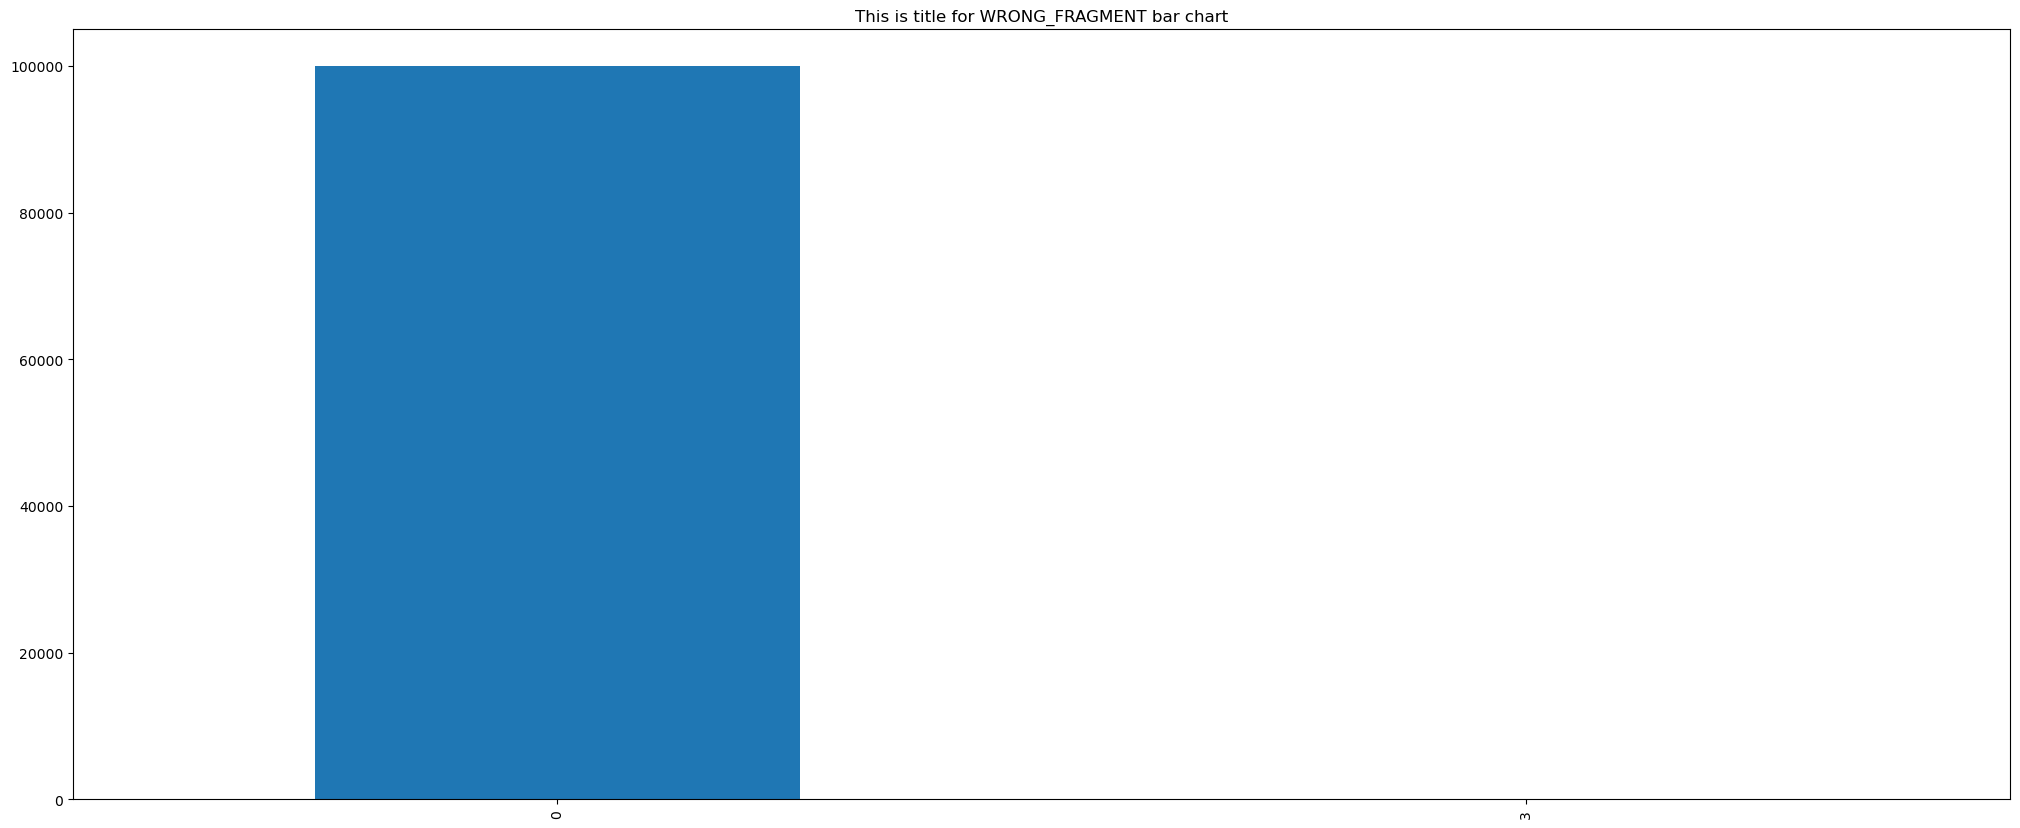

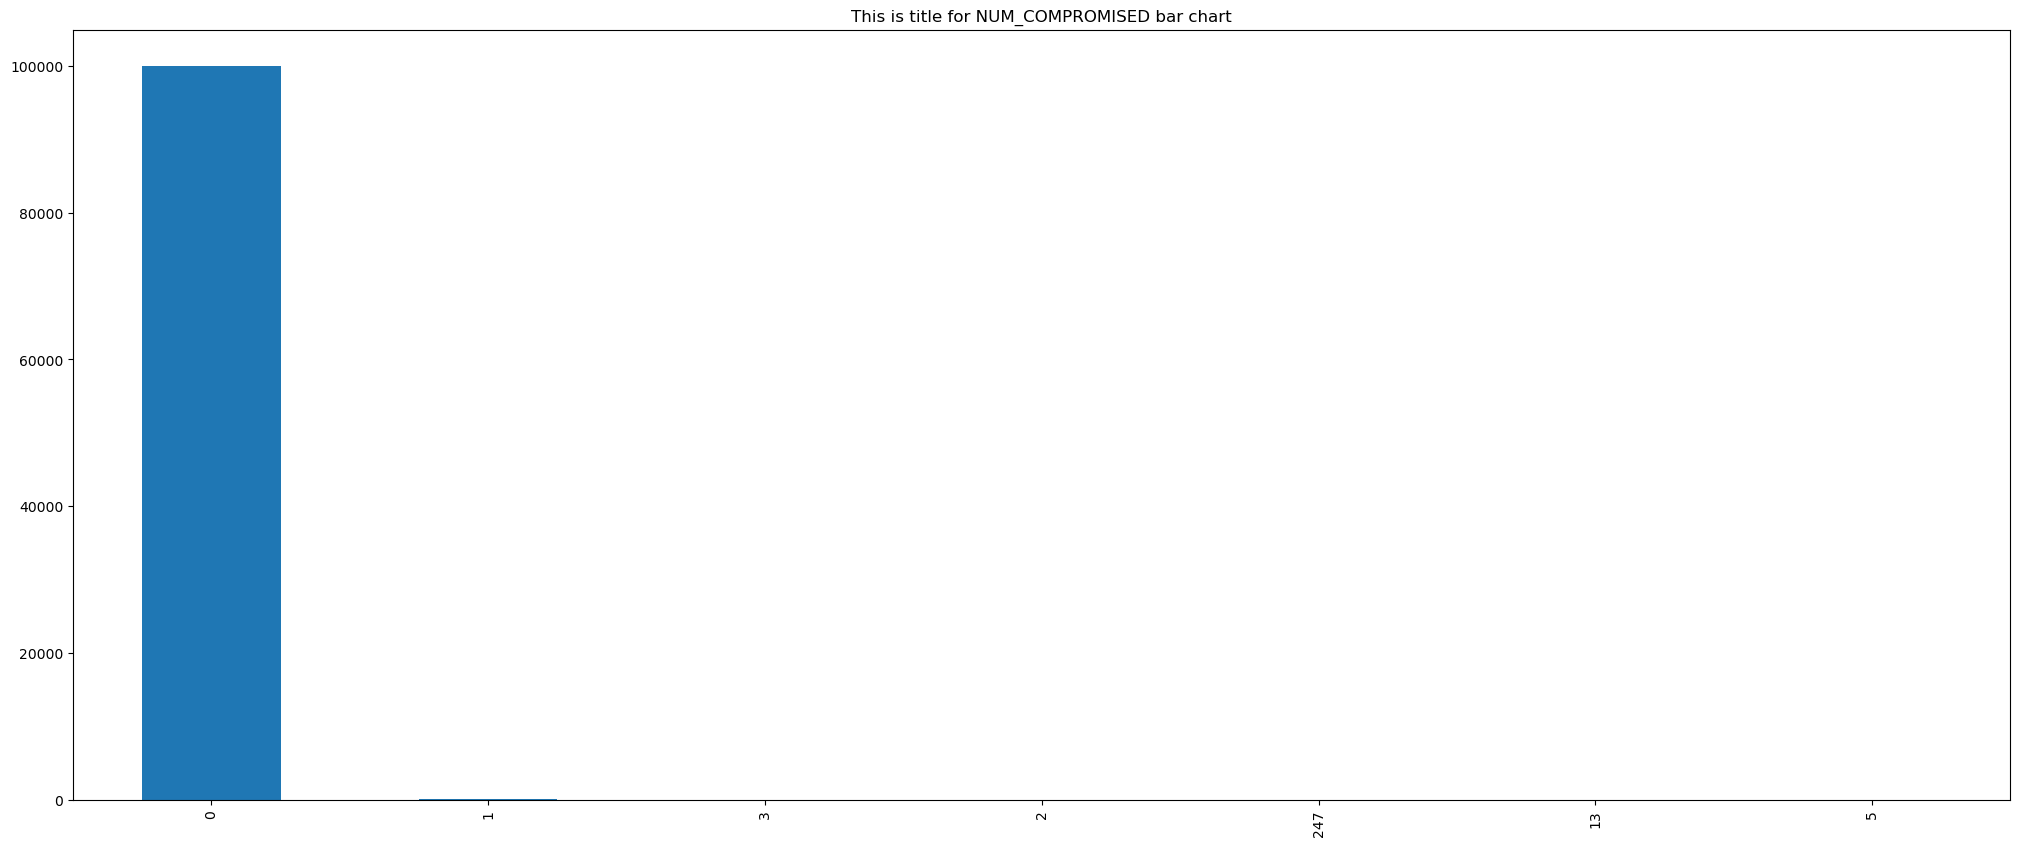

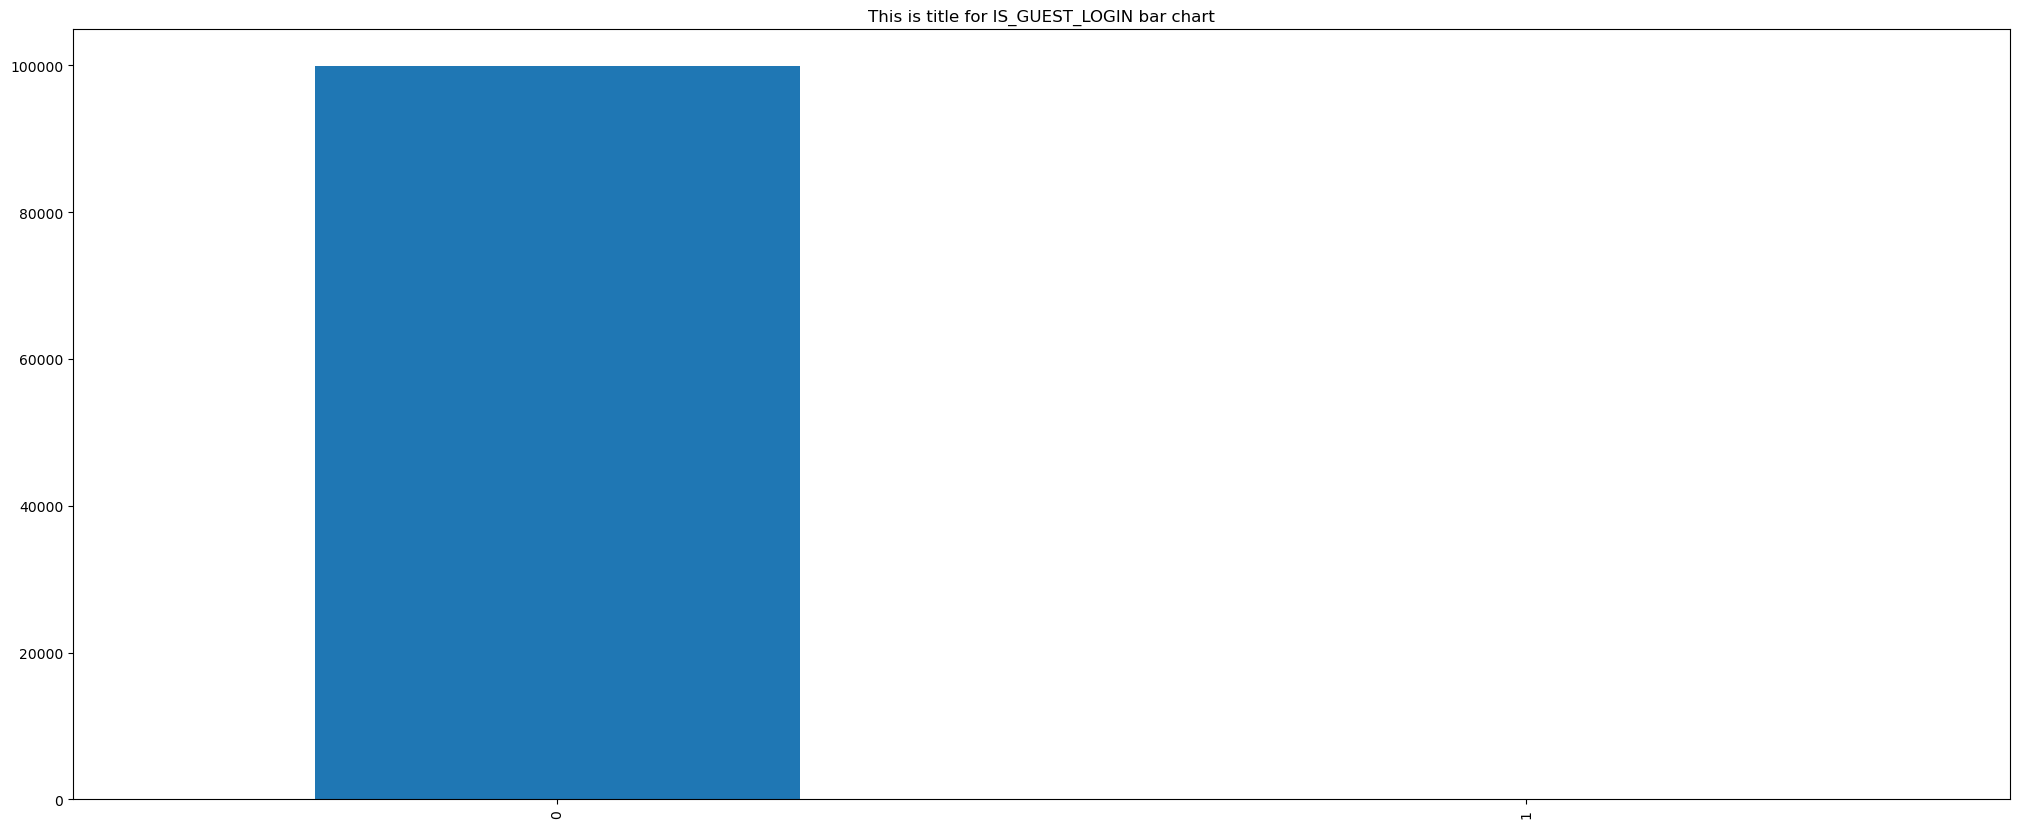

In [50]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)







Summary for STATE feature value counts


FIN    45619
INT    45079
CON     7748
REQ     1512
RST       35
ECO        5
ACC        1
no         1
Name: state, dtype: int64






Summary for SERVICE feature value counts


-           54973
dns         26492
http        10551
smtp         2672
ftp-data     2079
ftp          1938
ssh           583
pop3          561
dhcp           50
snmp           45
ssl            35
irc            13
radius          8
Name: service, dtype: int64






Summary for PROTO feature value counts


tcp            47927
udp            35776
unas            6069
arp             1498
ospf            1240
sctp             589
any              144
gre              125
pim              105
sun-nd           101
ipv6             100
mobile            99
swipe             94
sep               91
rsvp              85
dcn               65
br-sat-mon        64
vmtp              63
3pc               62
cftp              62
stp               61
ggp               61
com

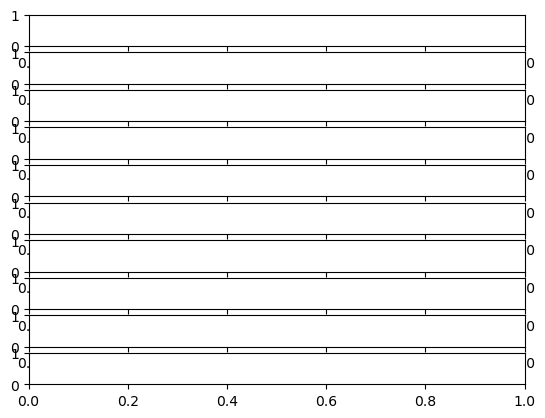

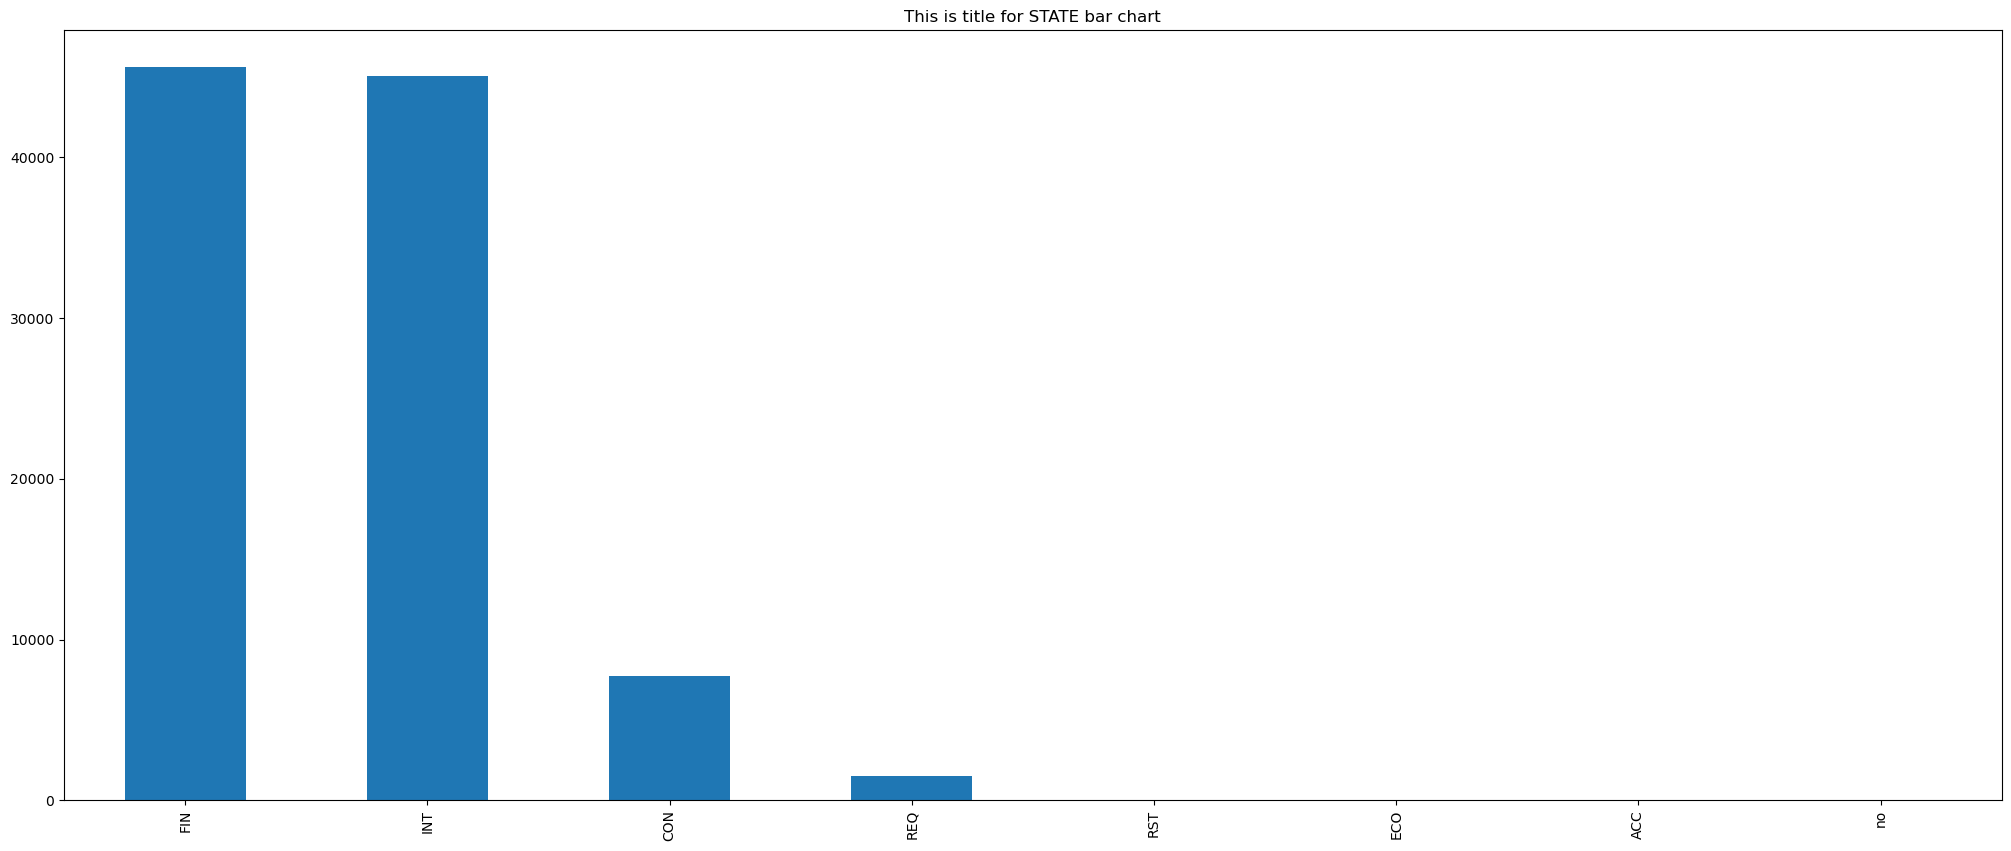

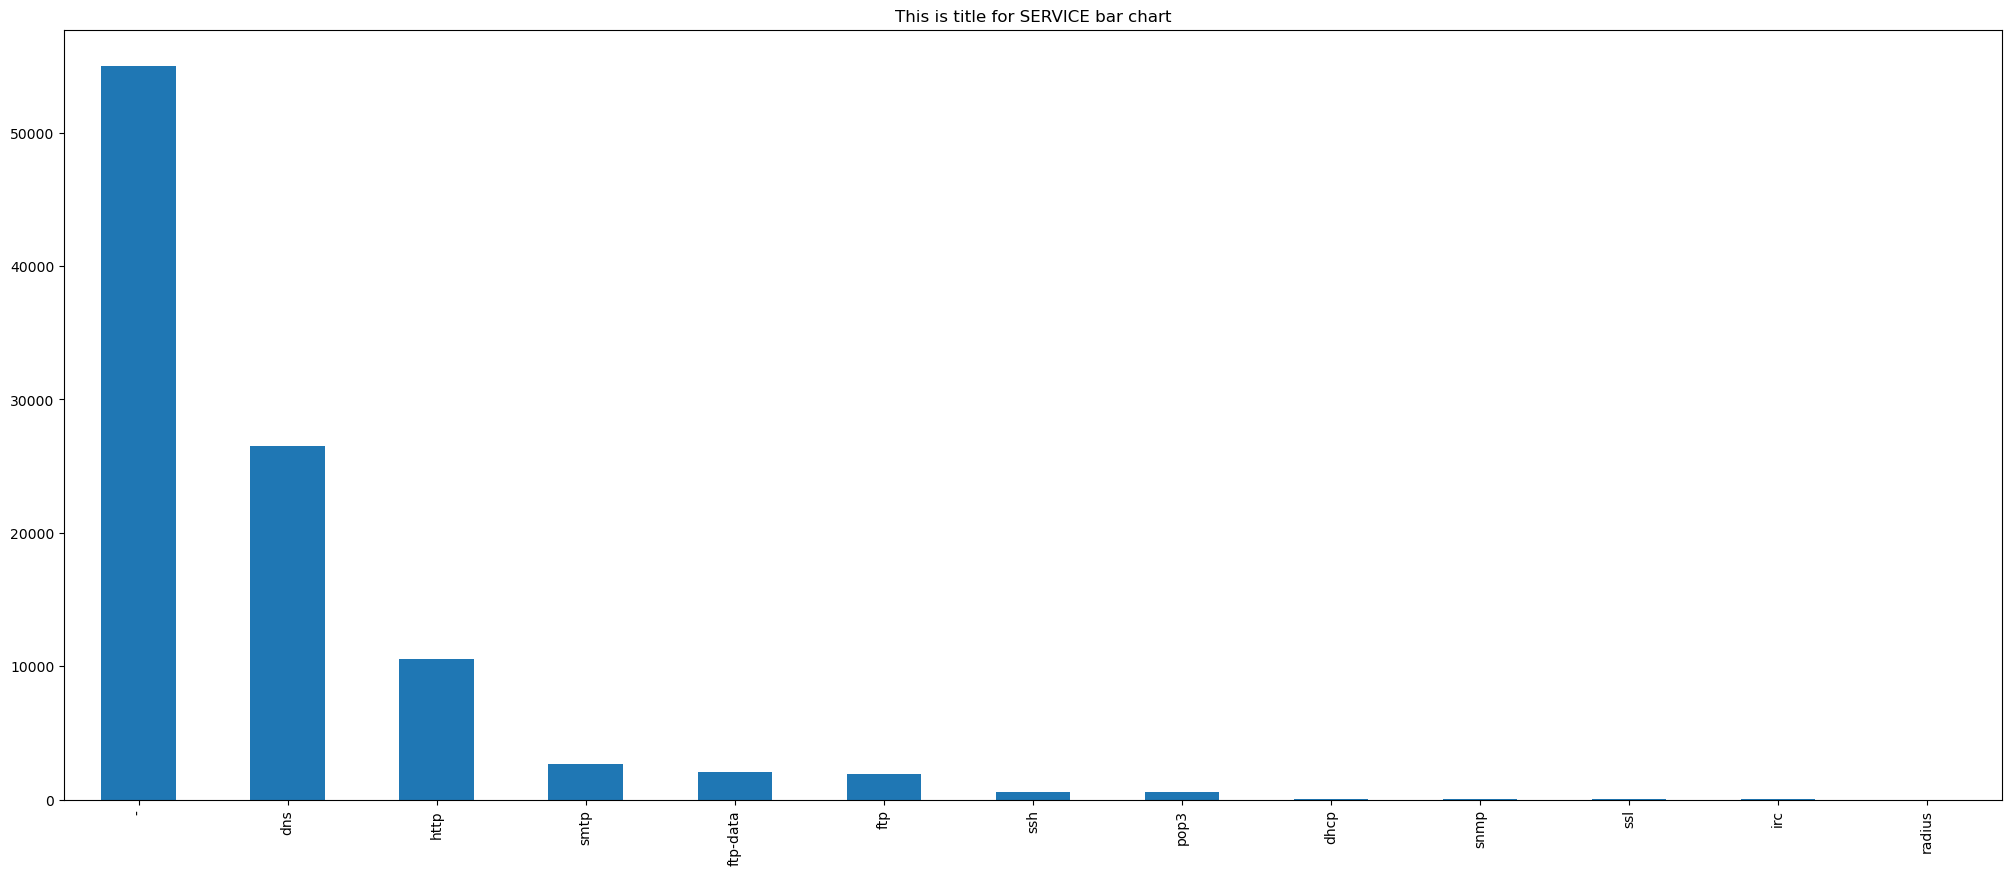

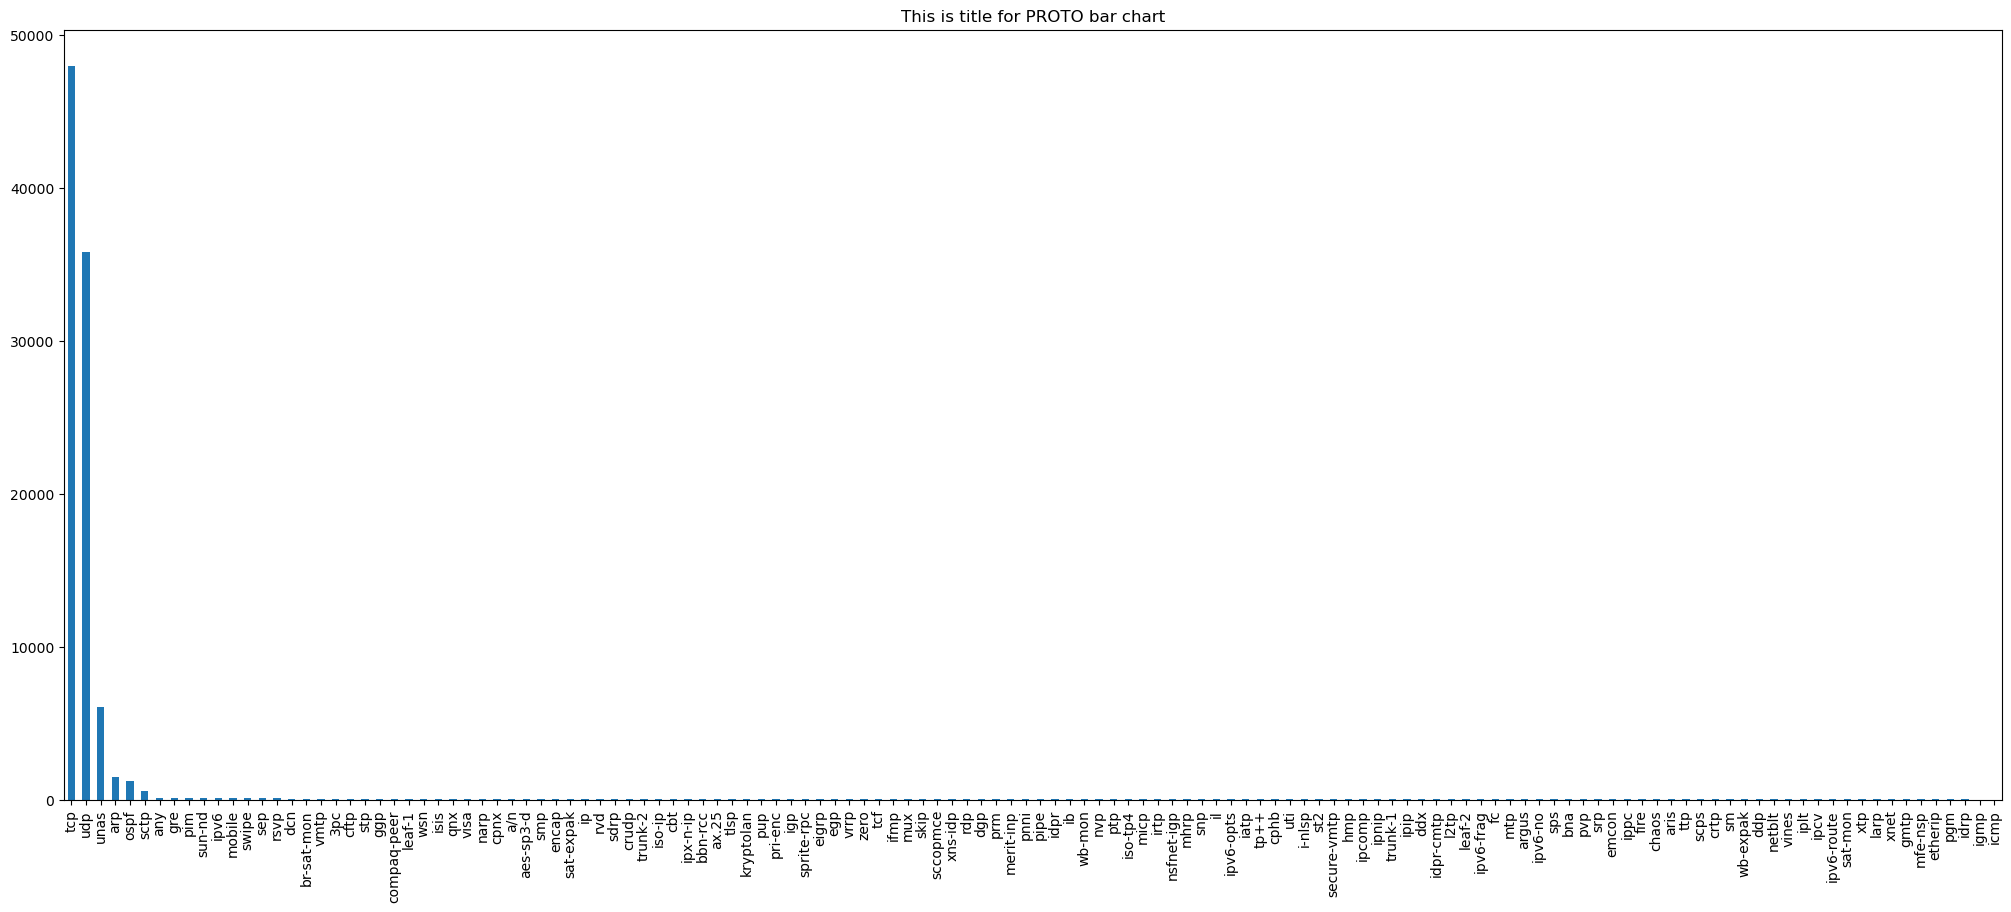

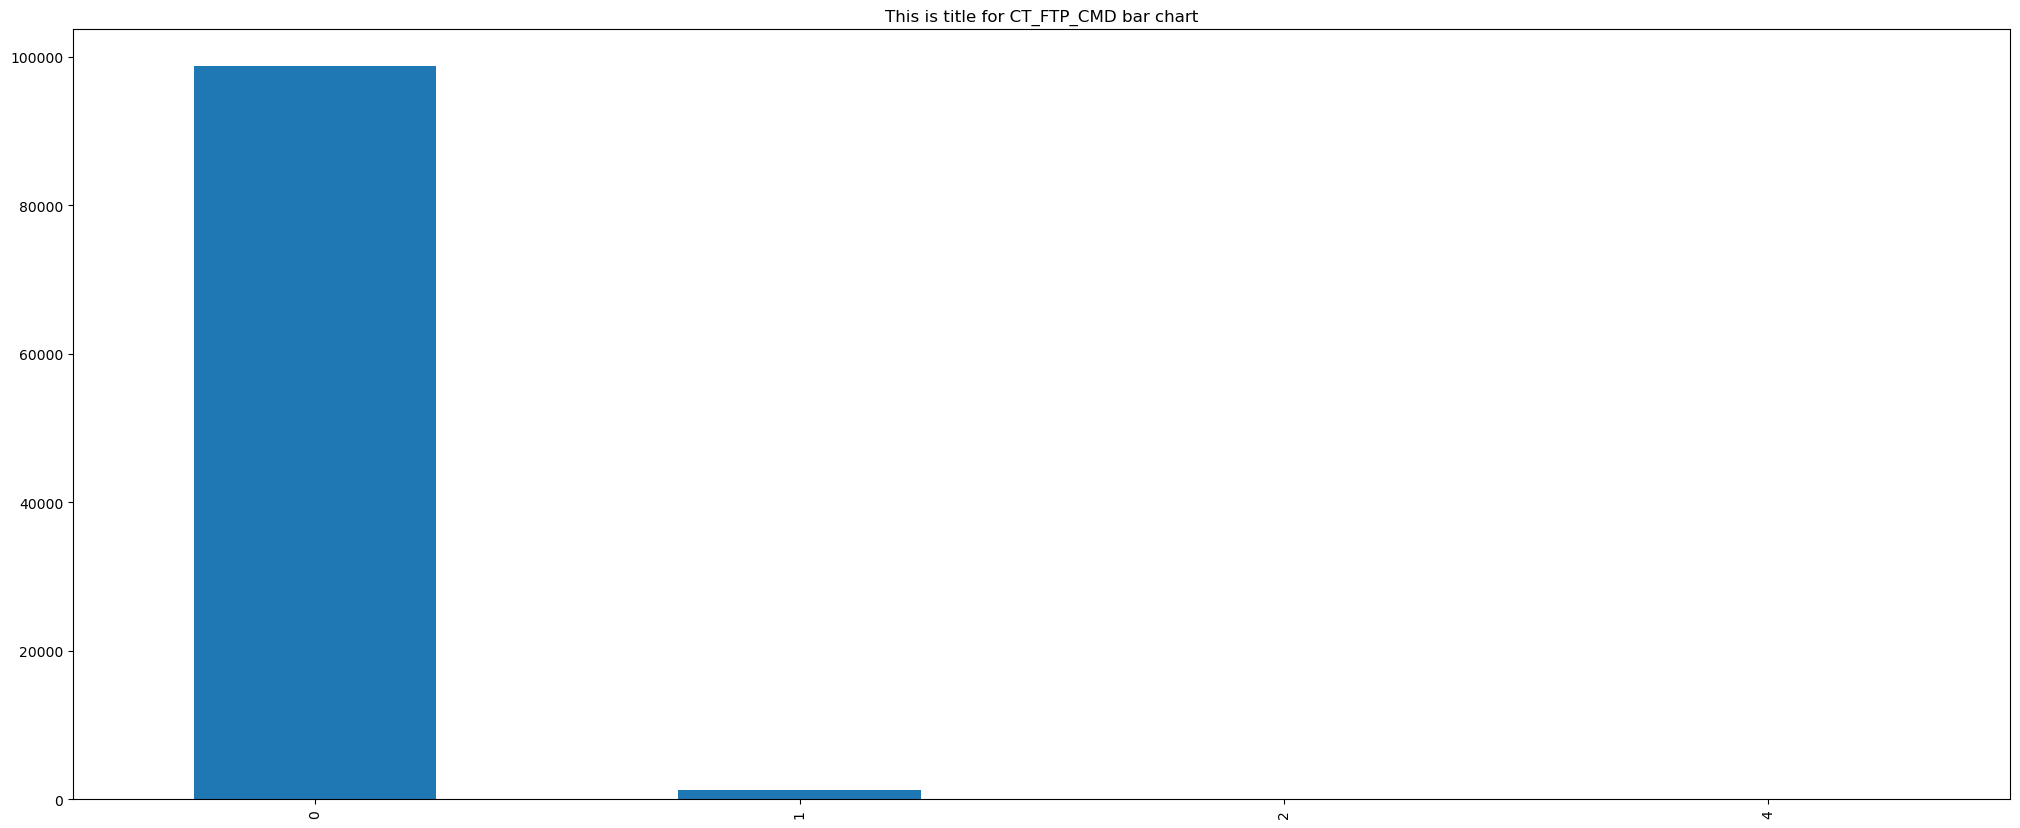

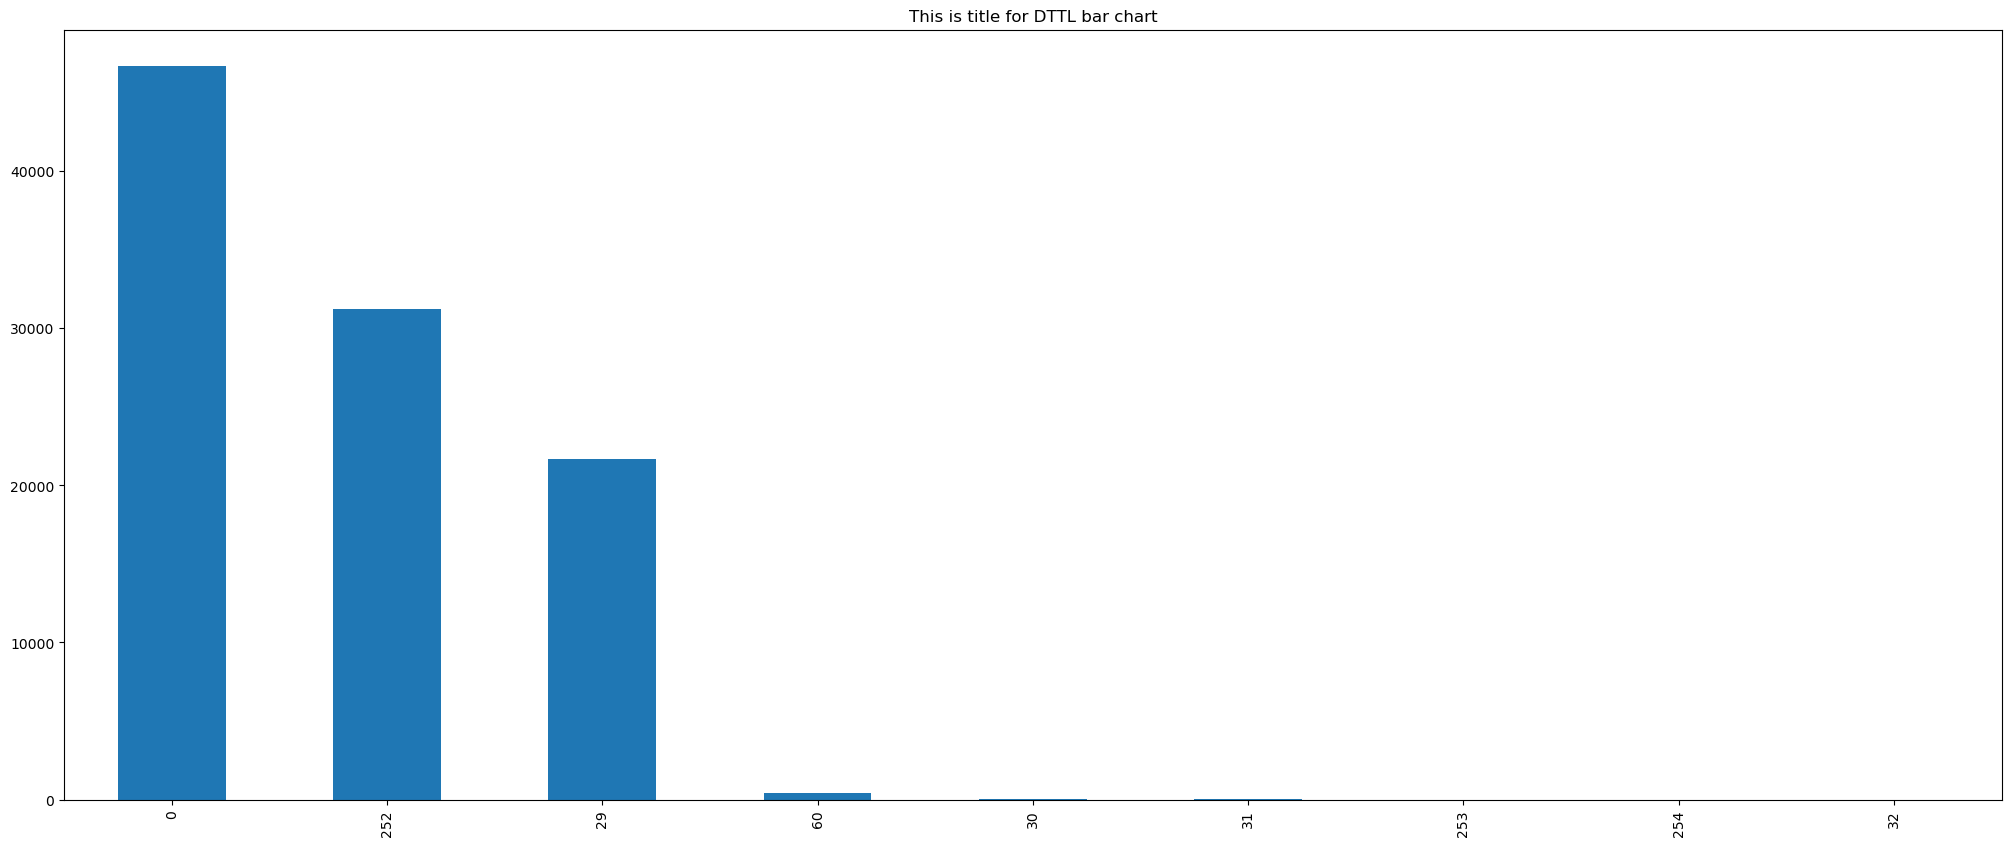

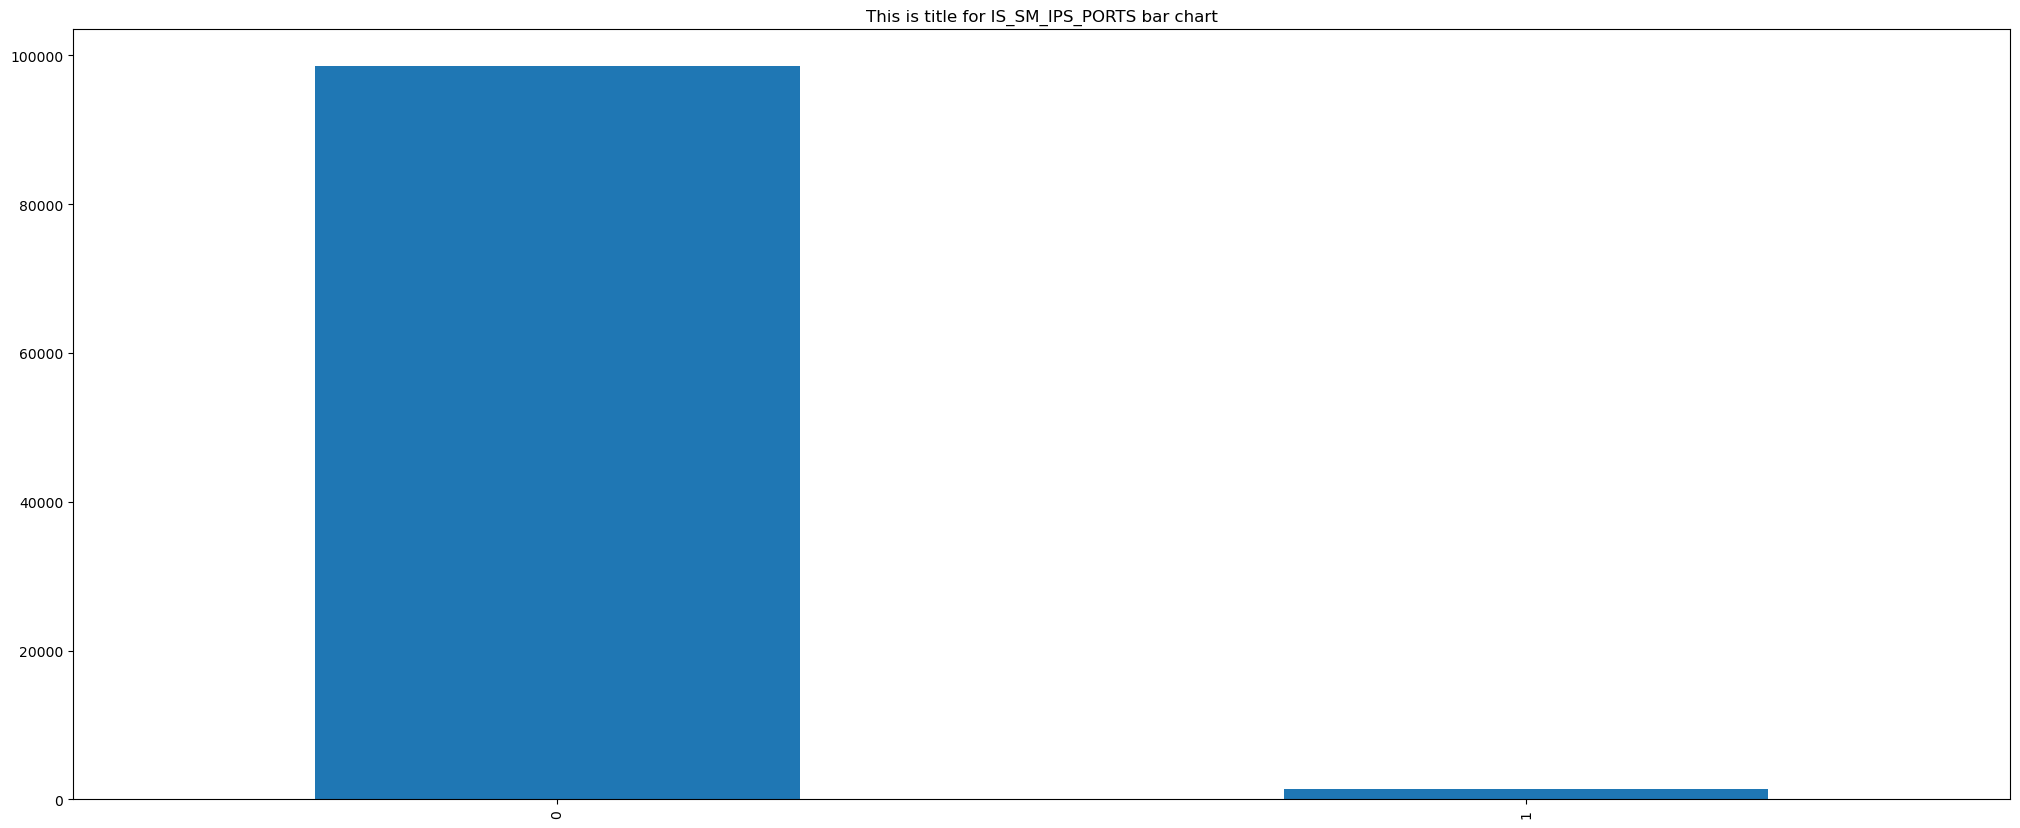

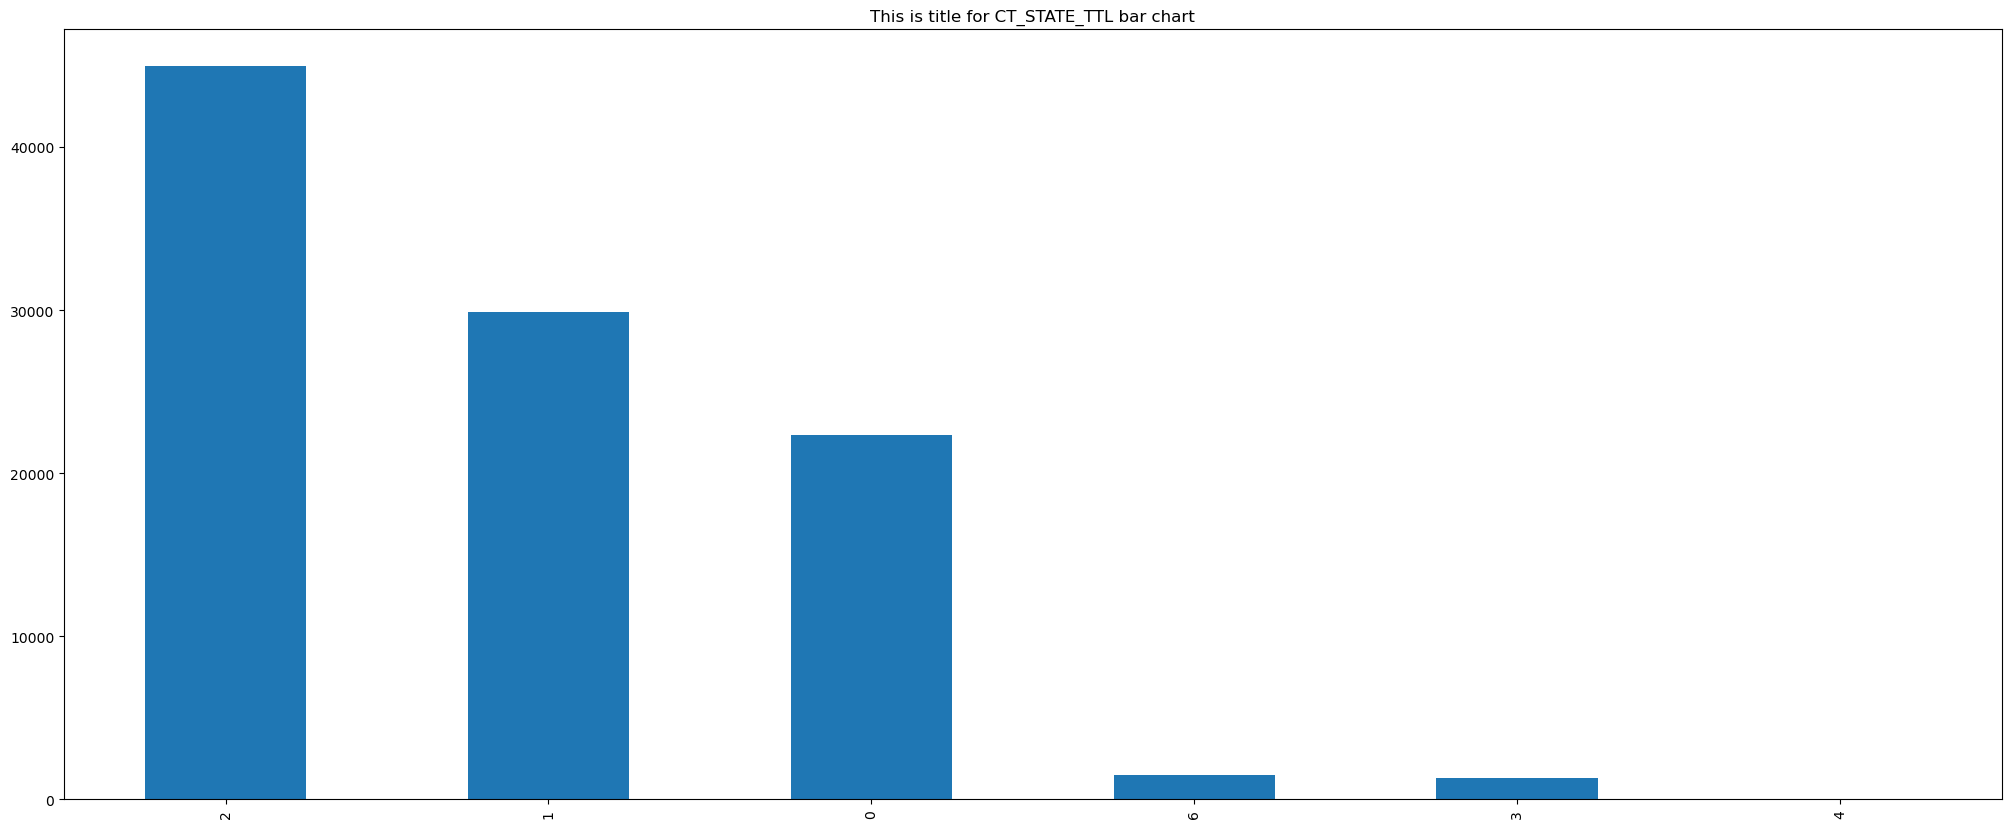

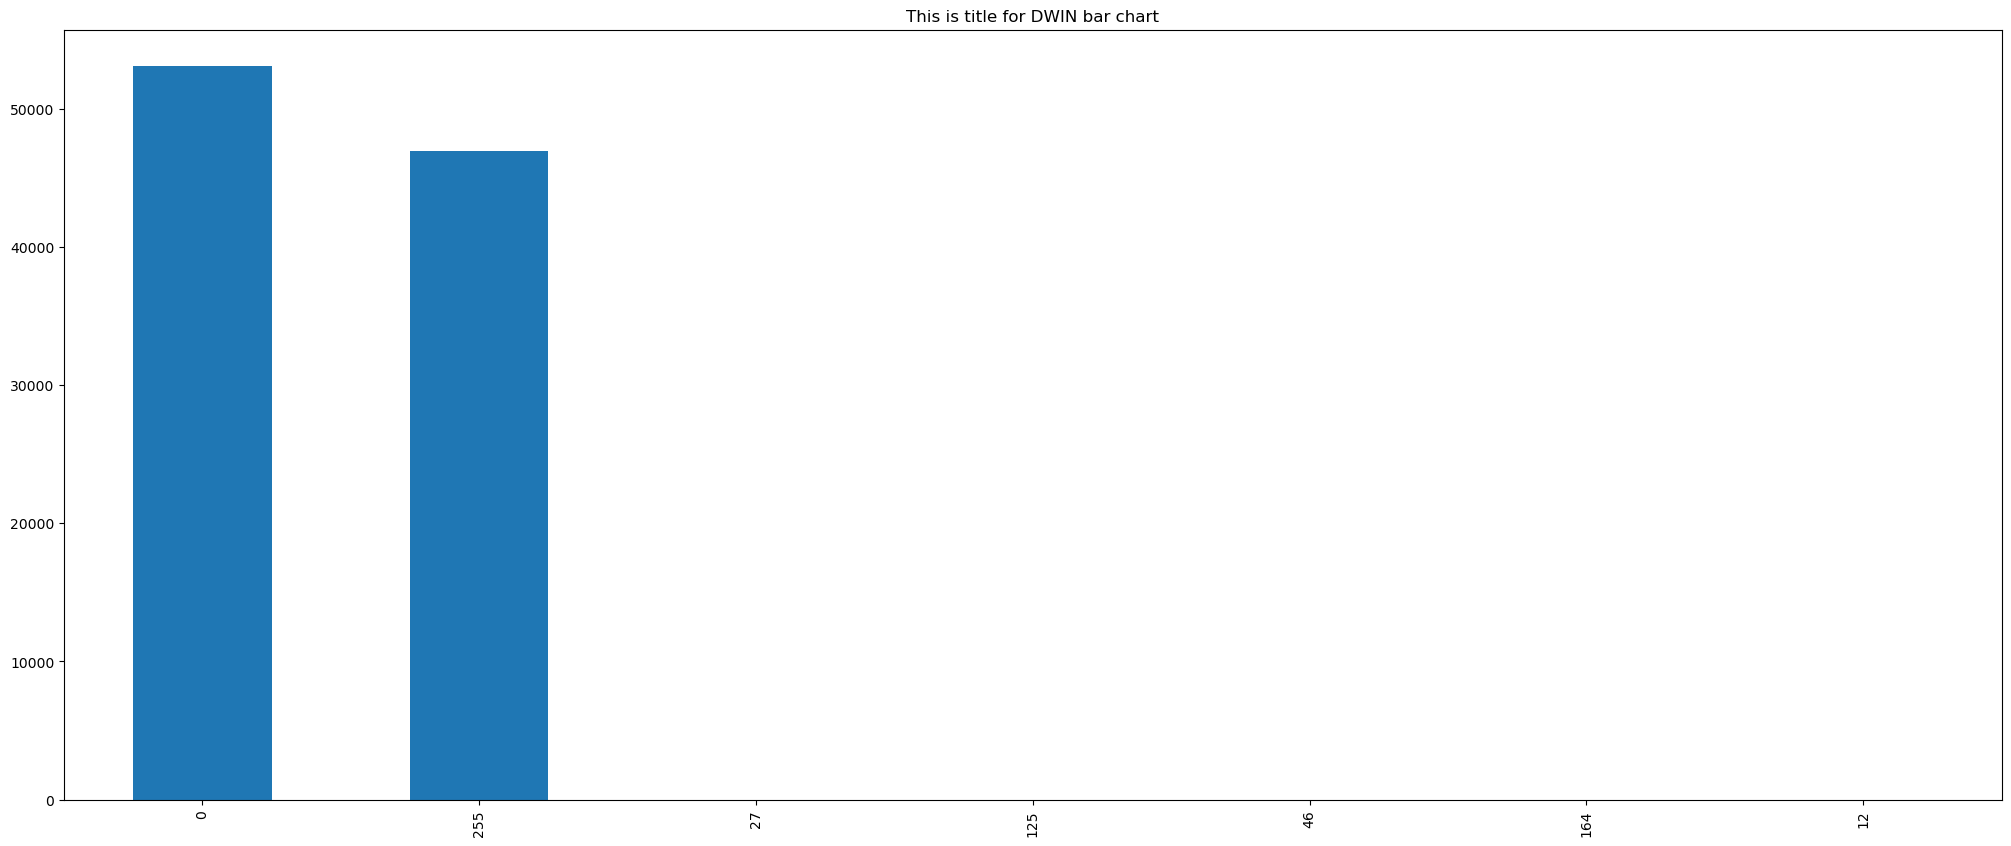

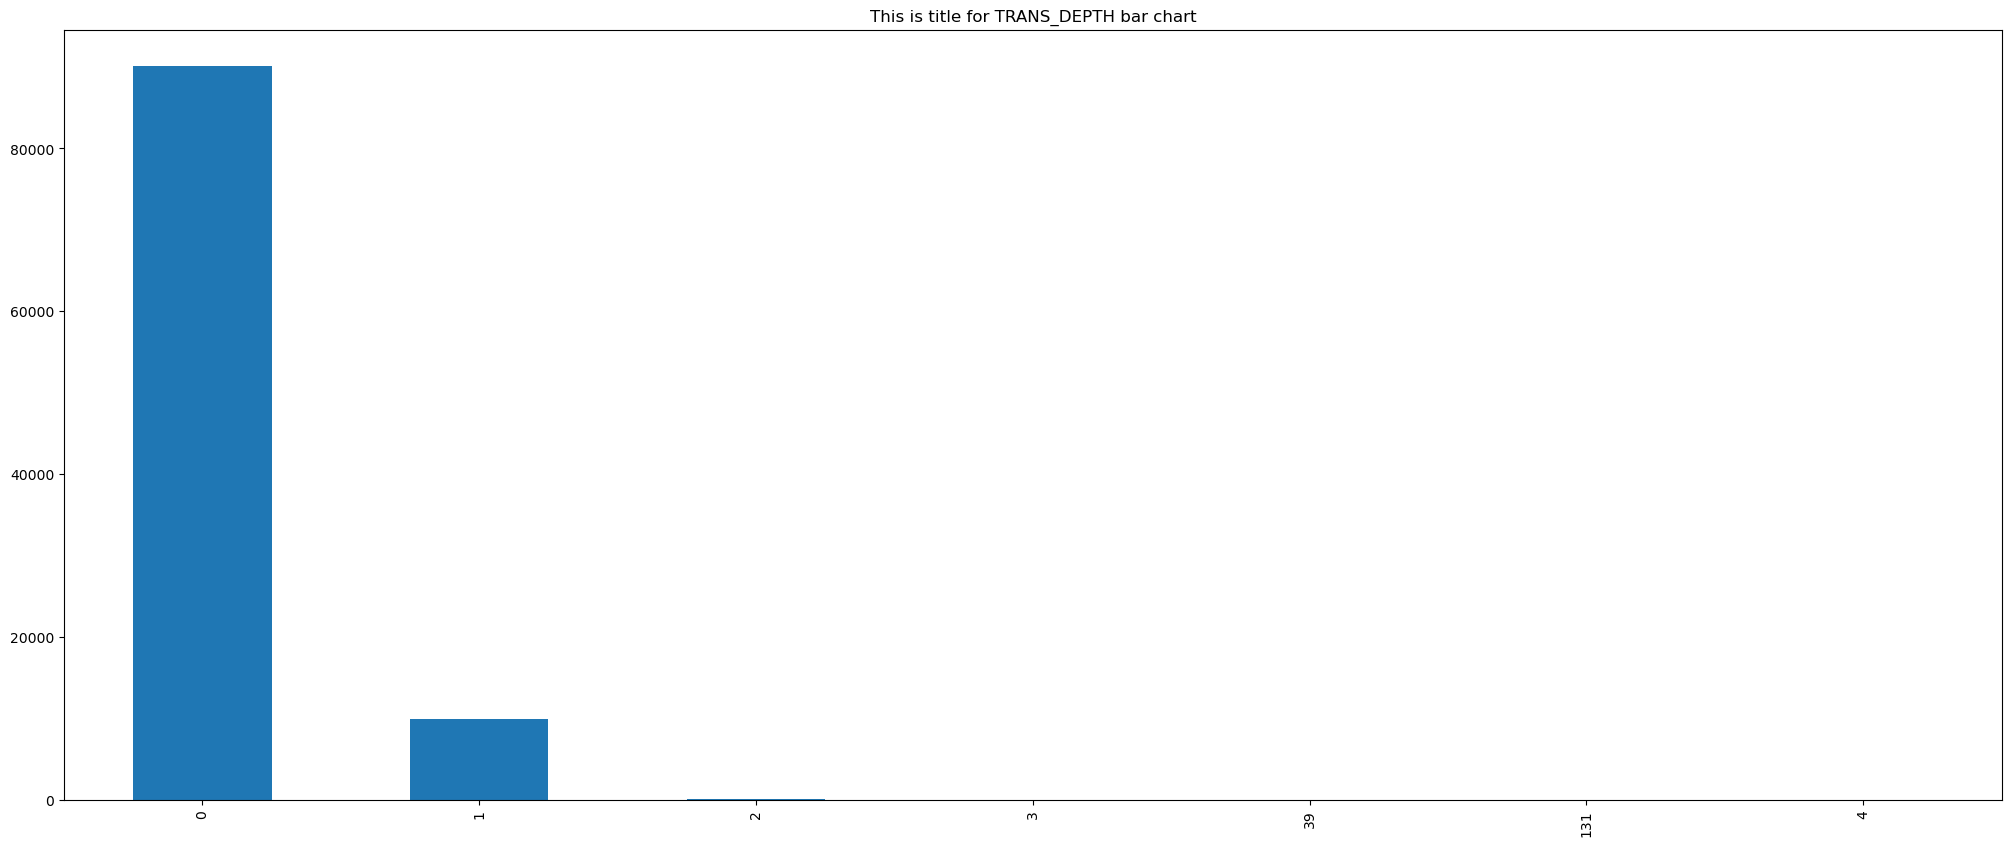

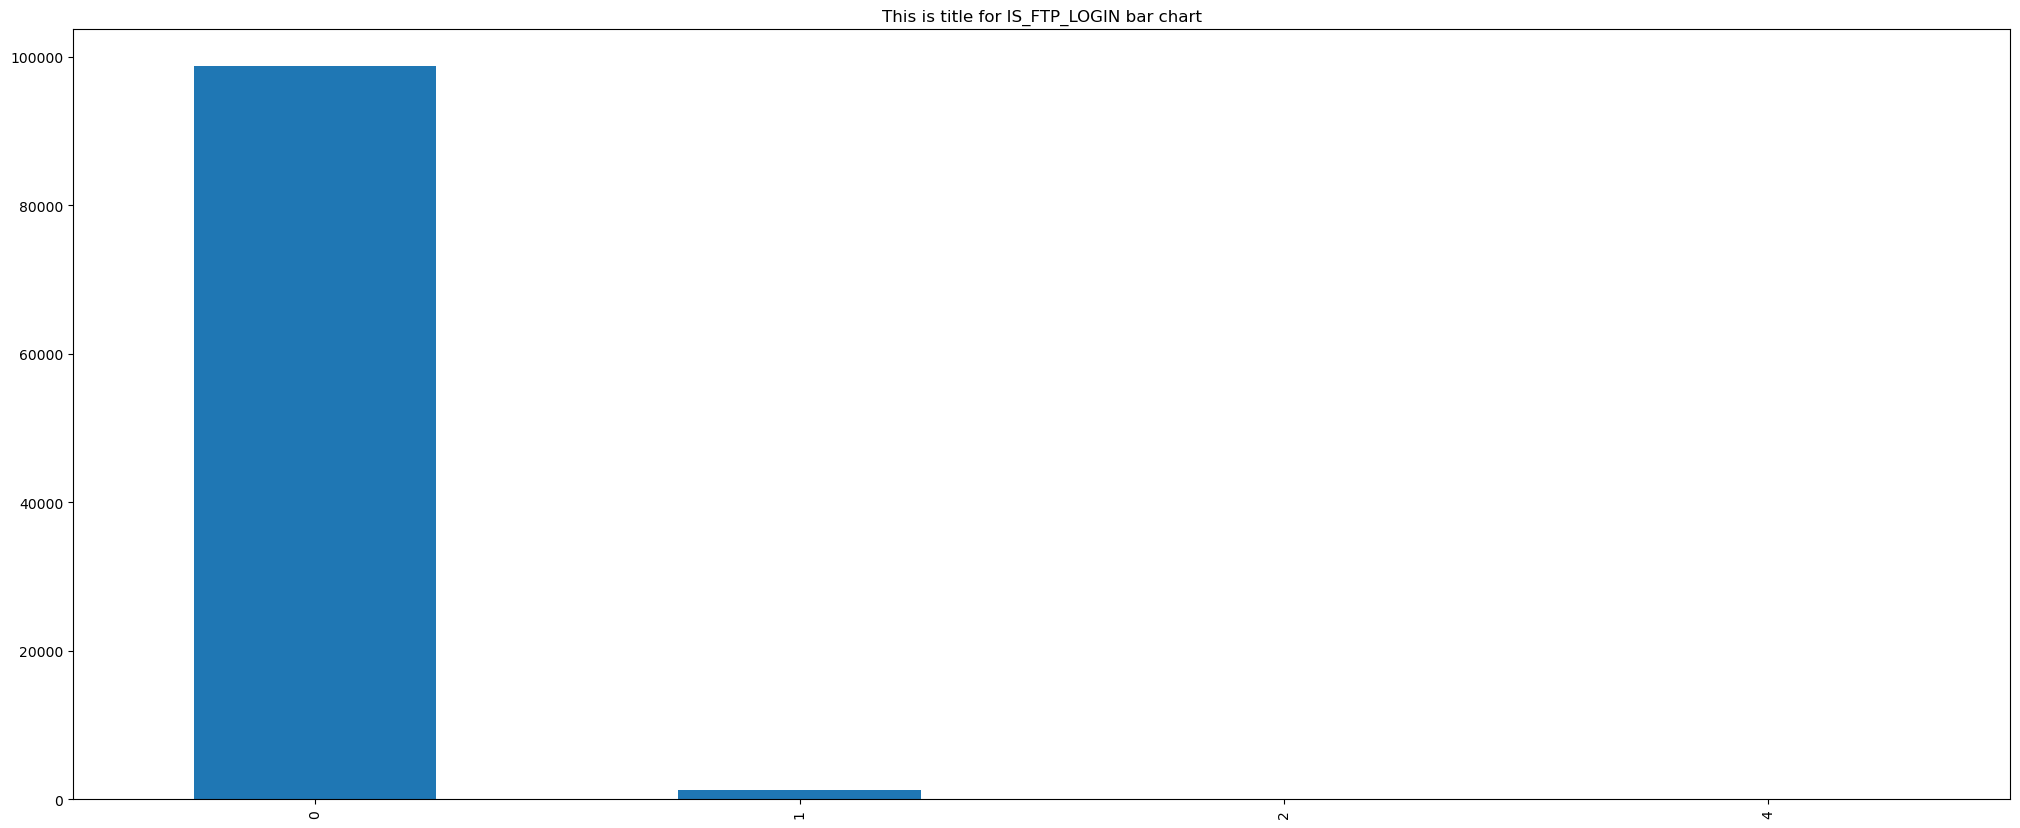

In [51]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

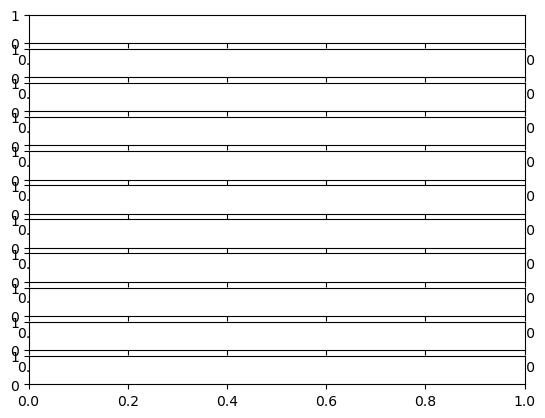

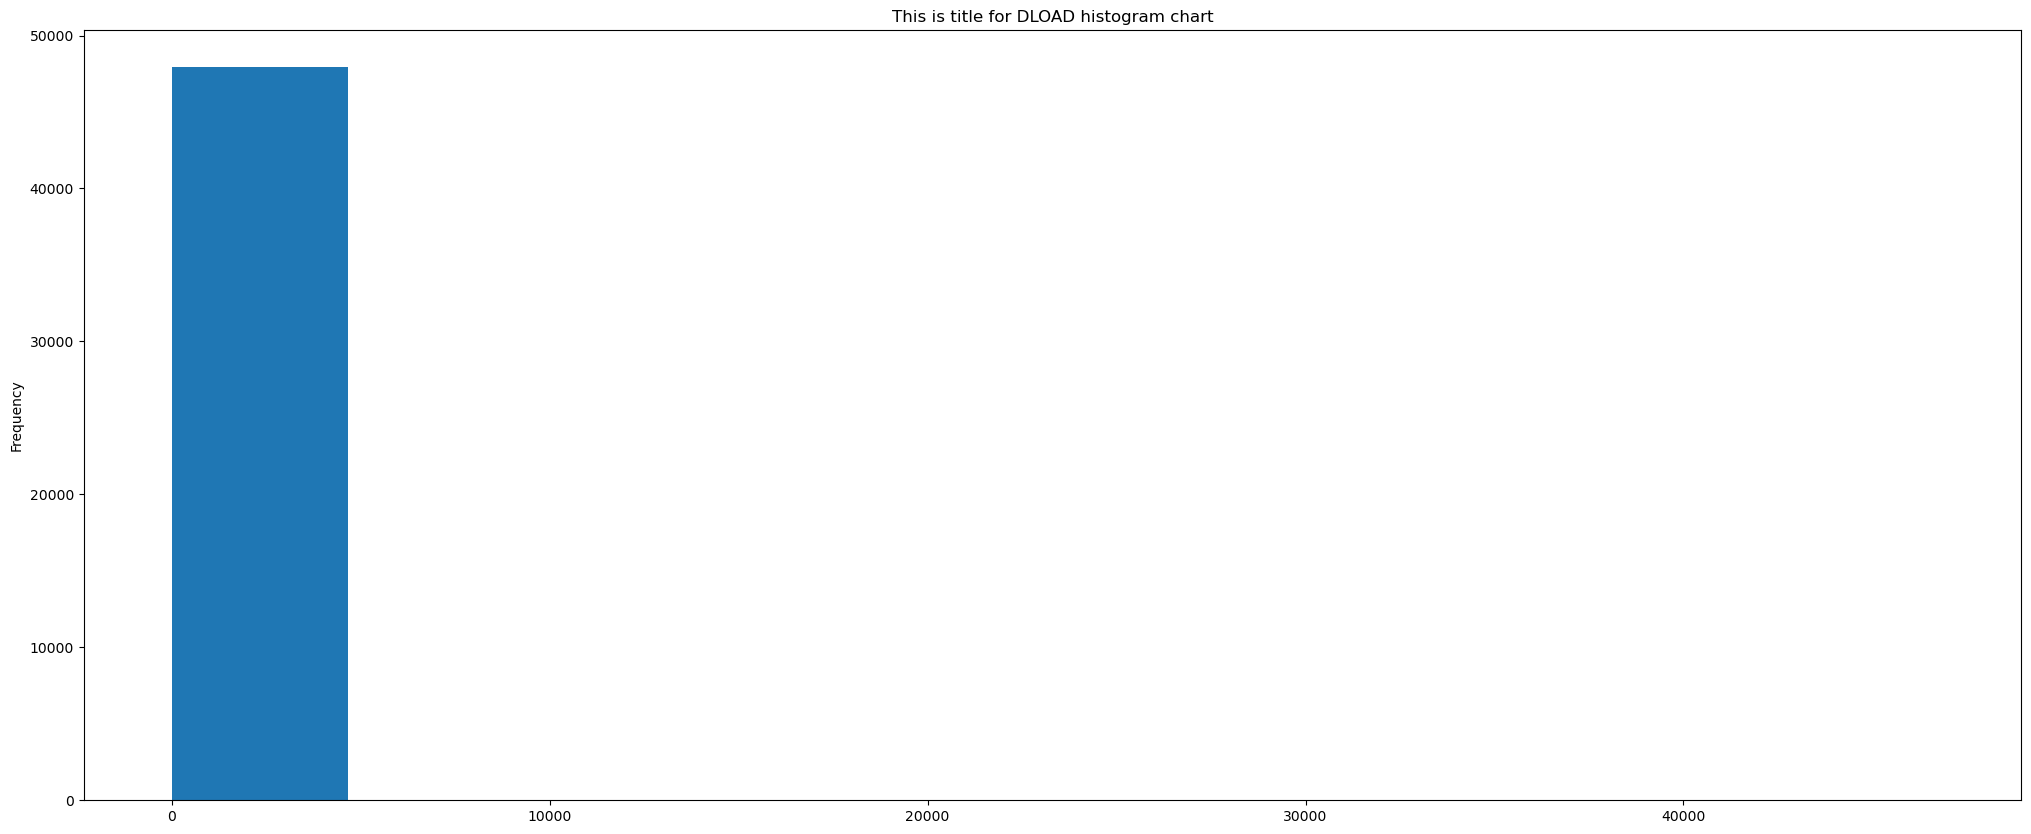

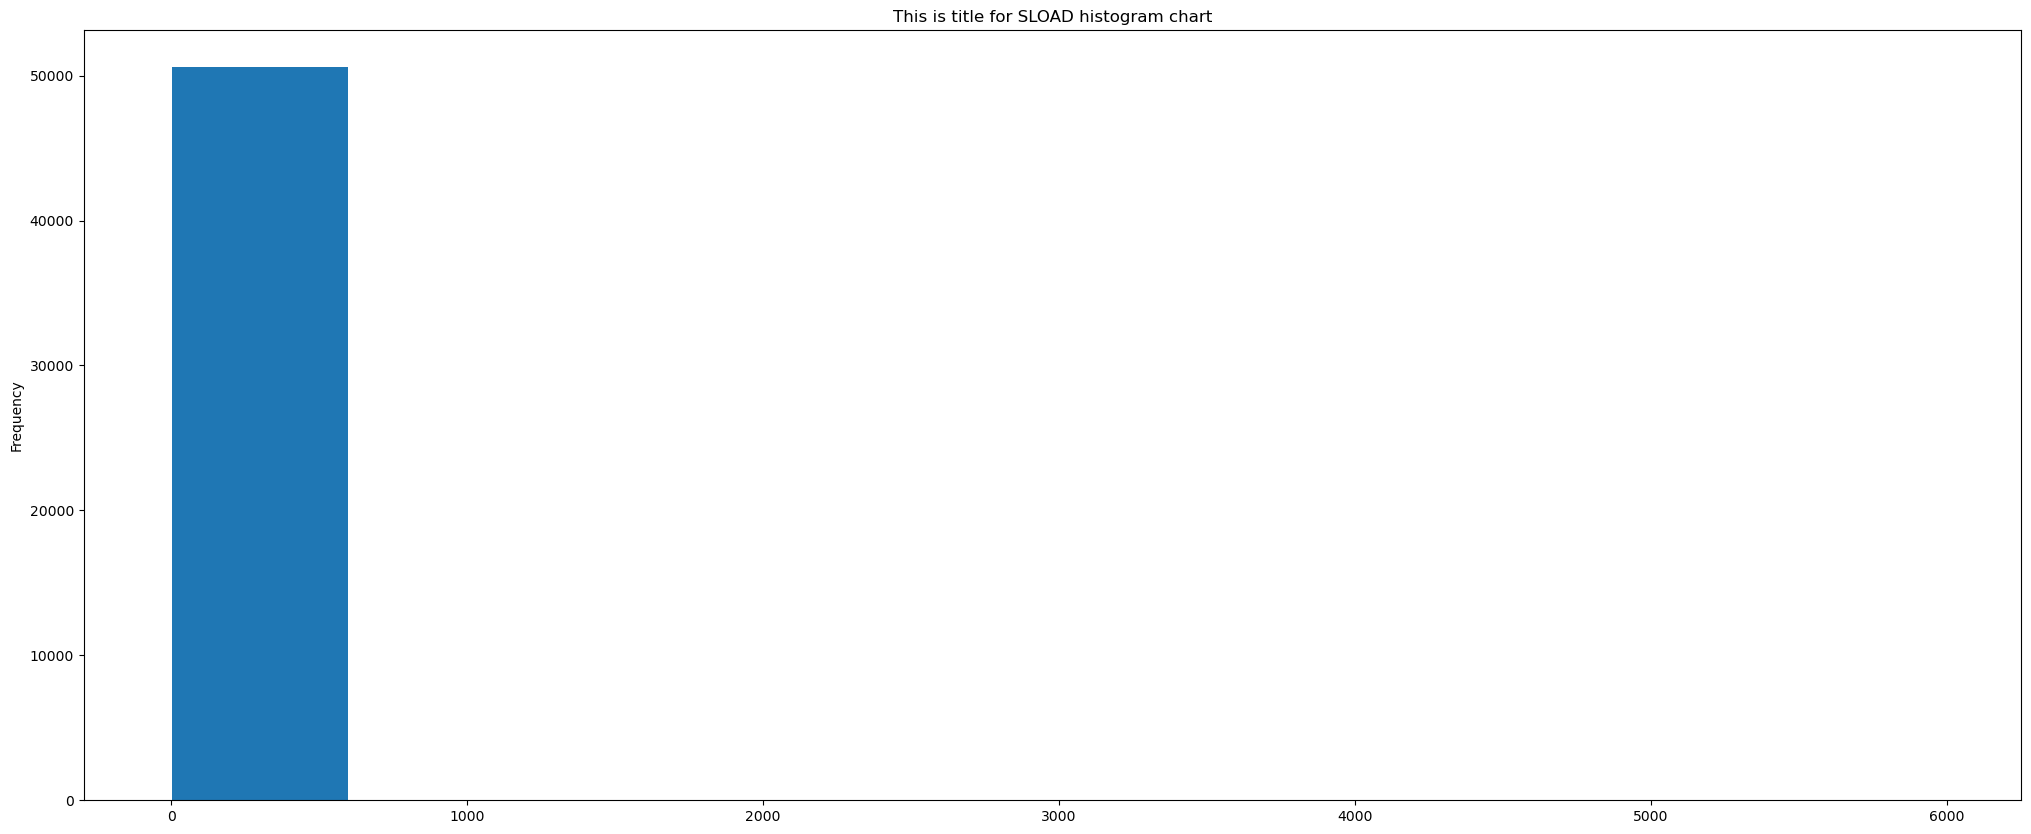

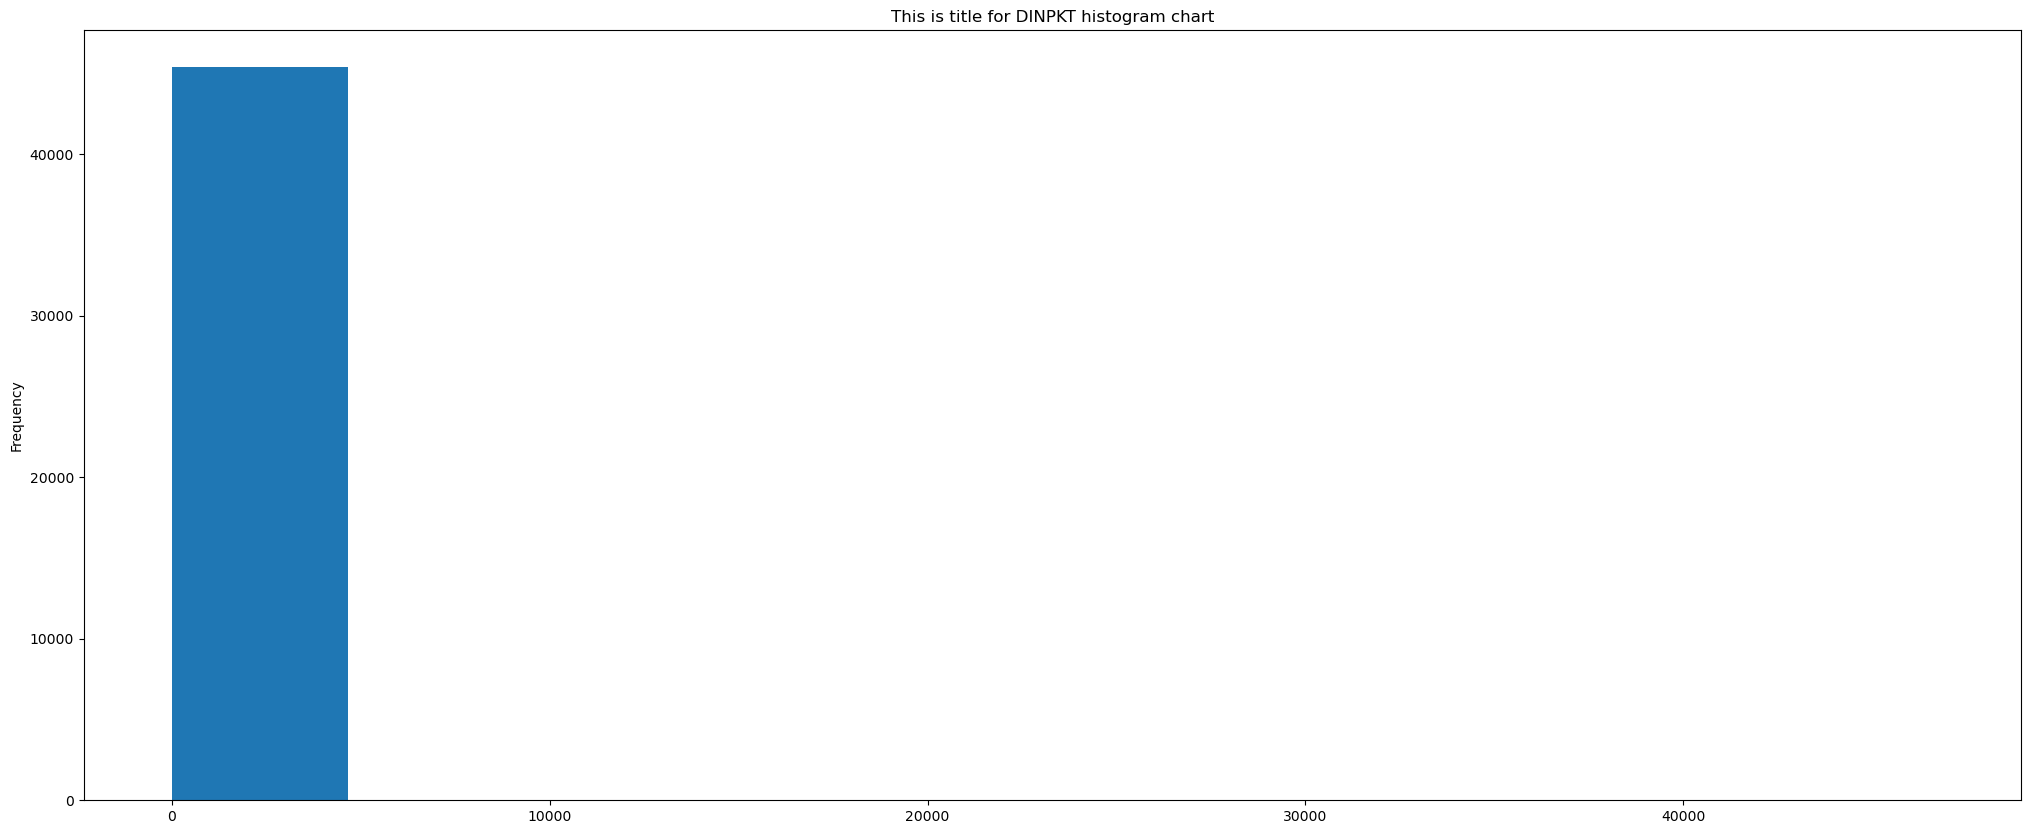

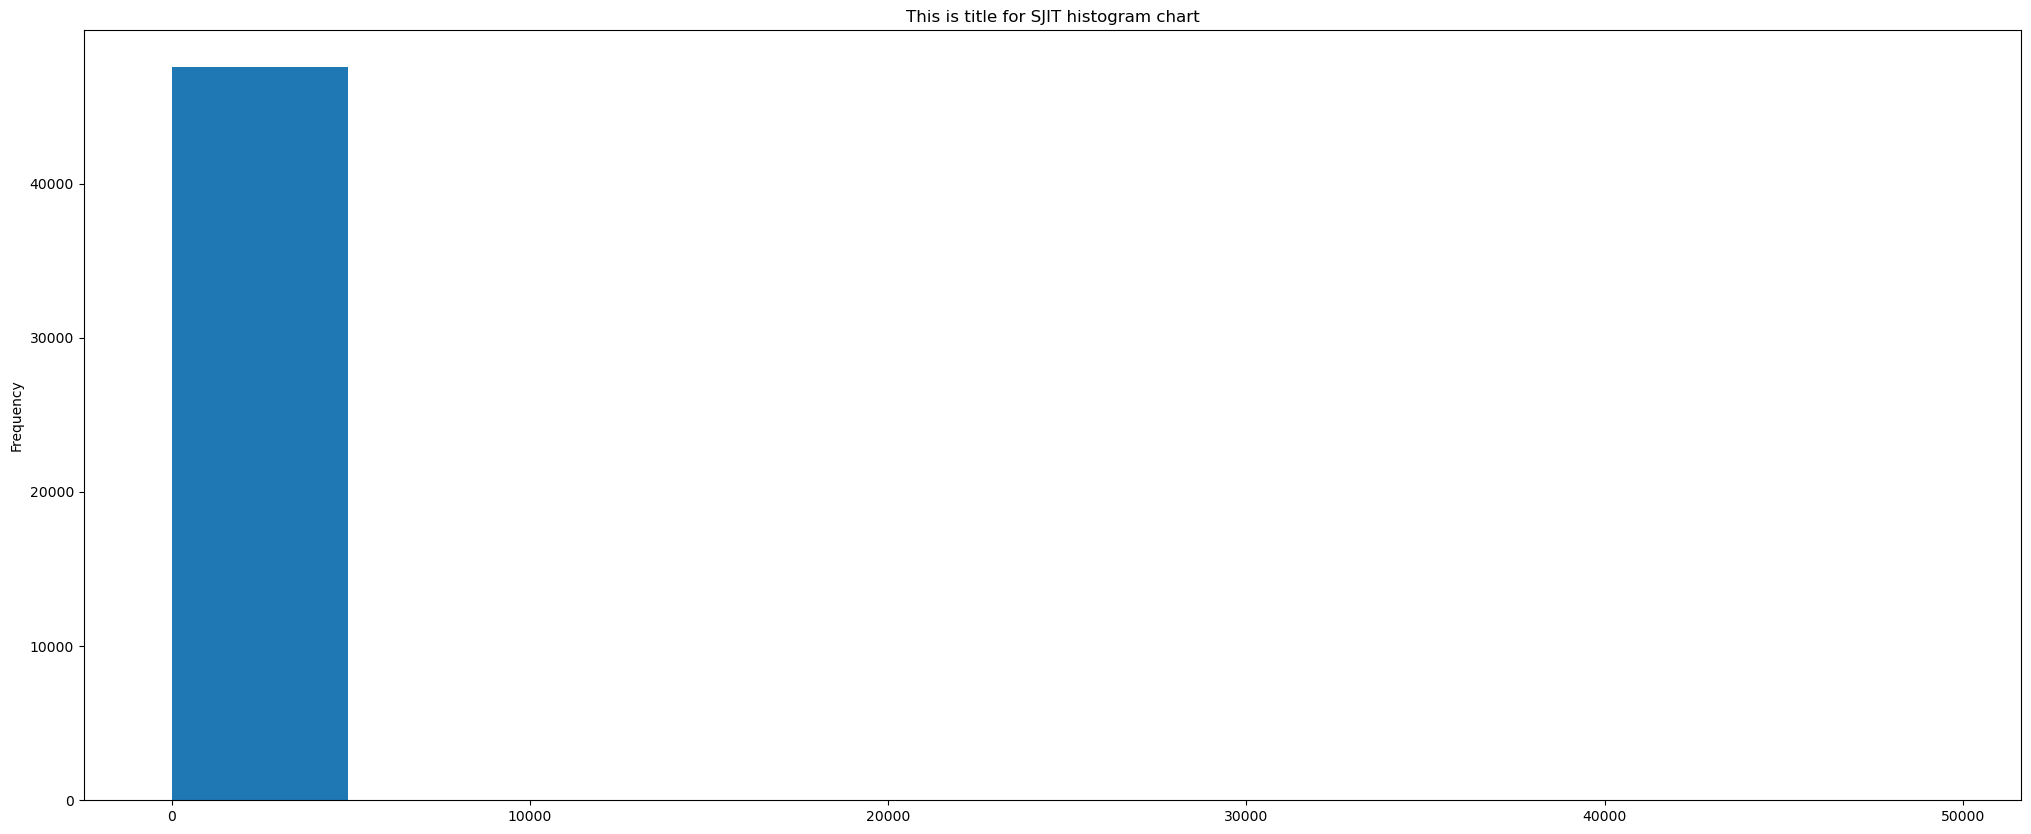

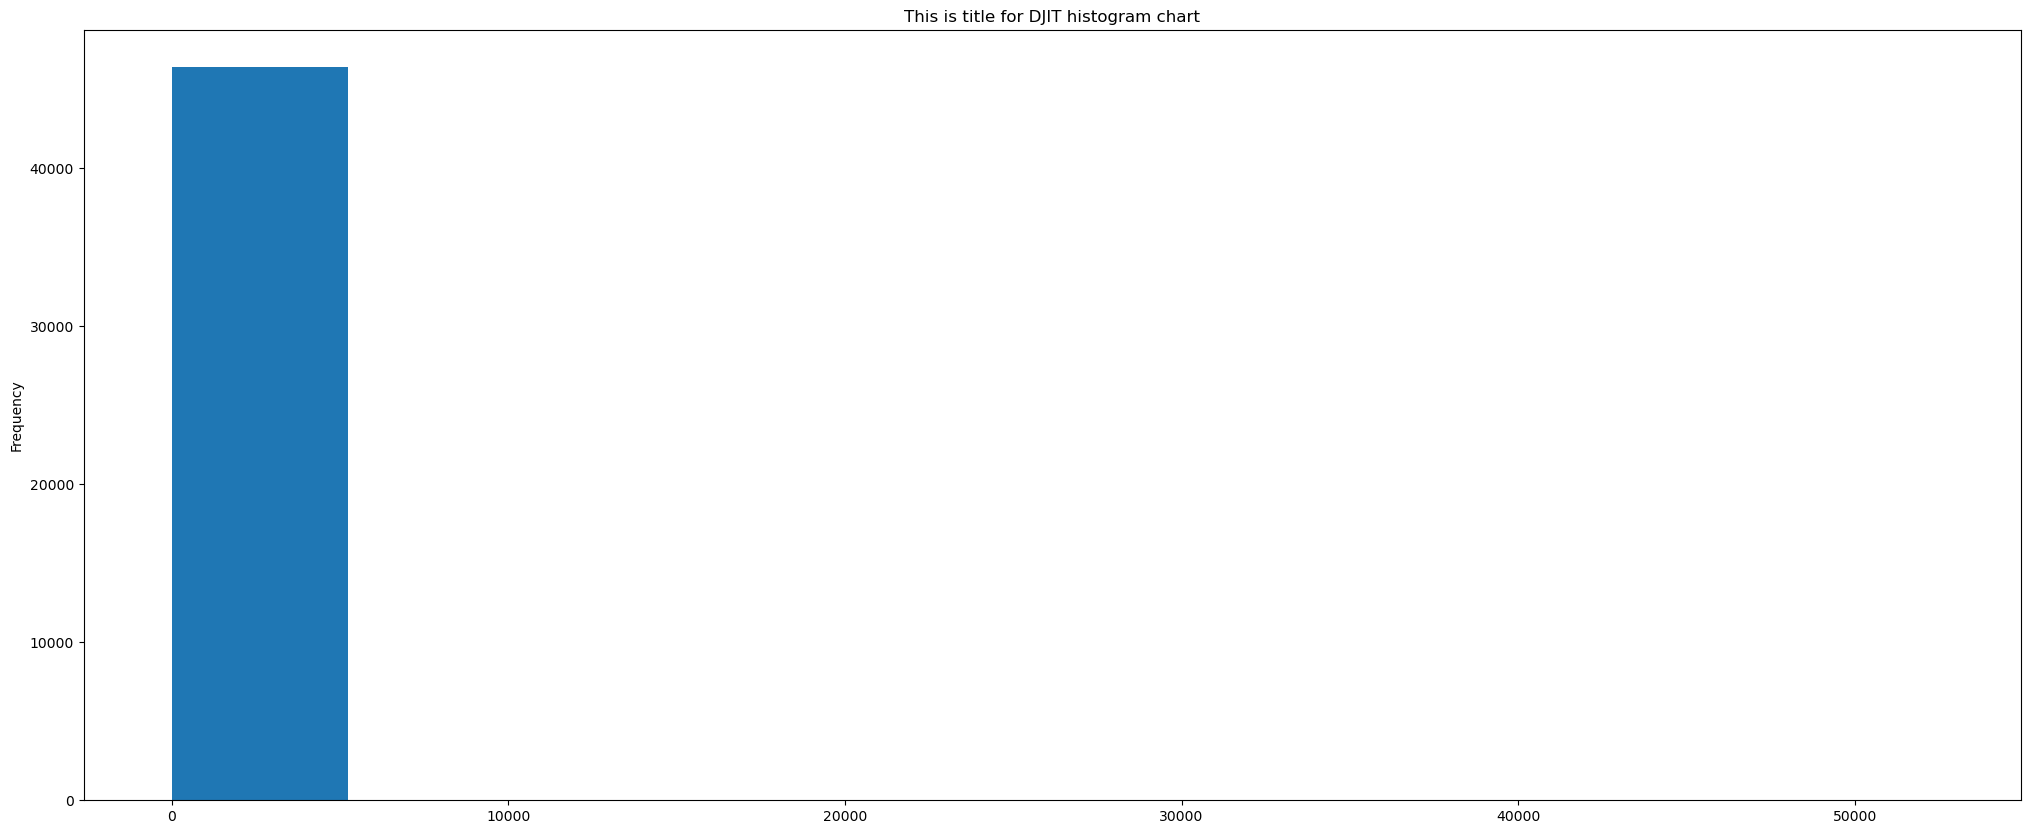

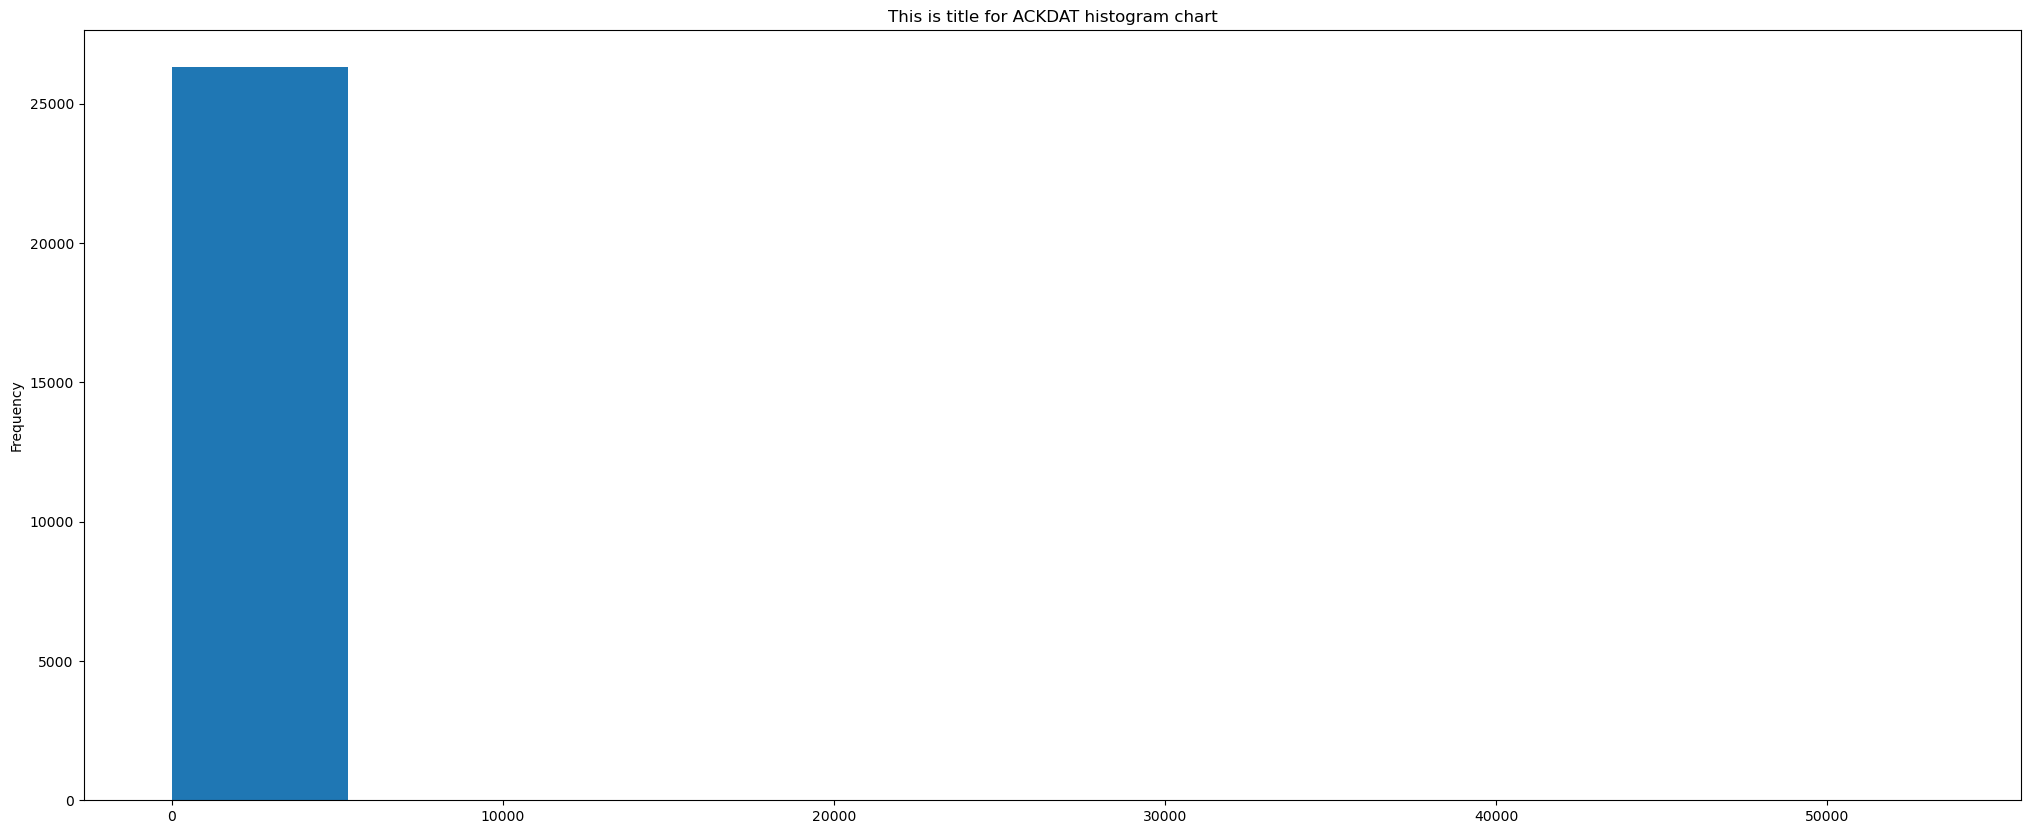

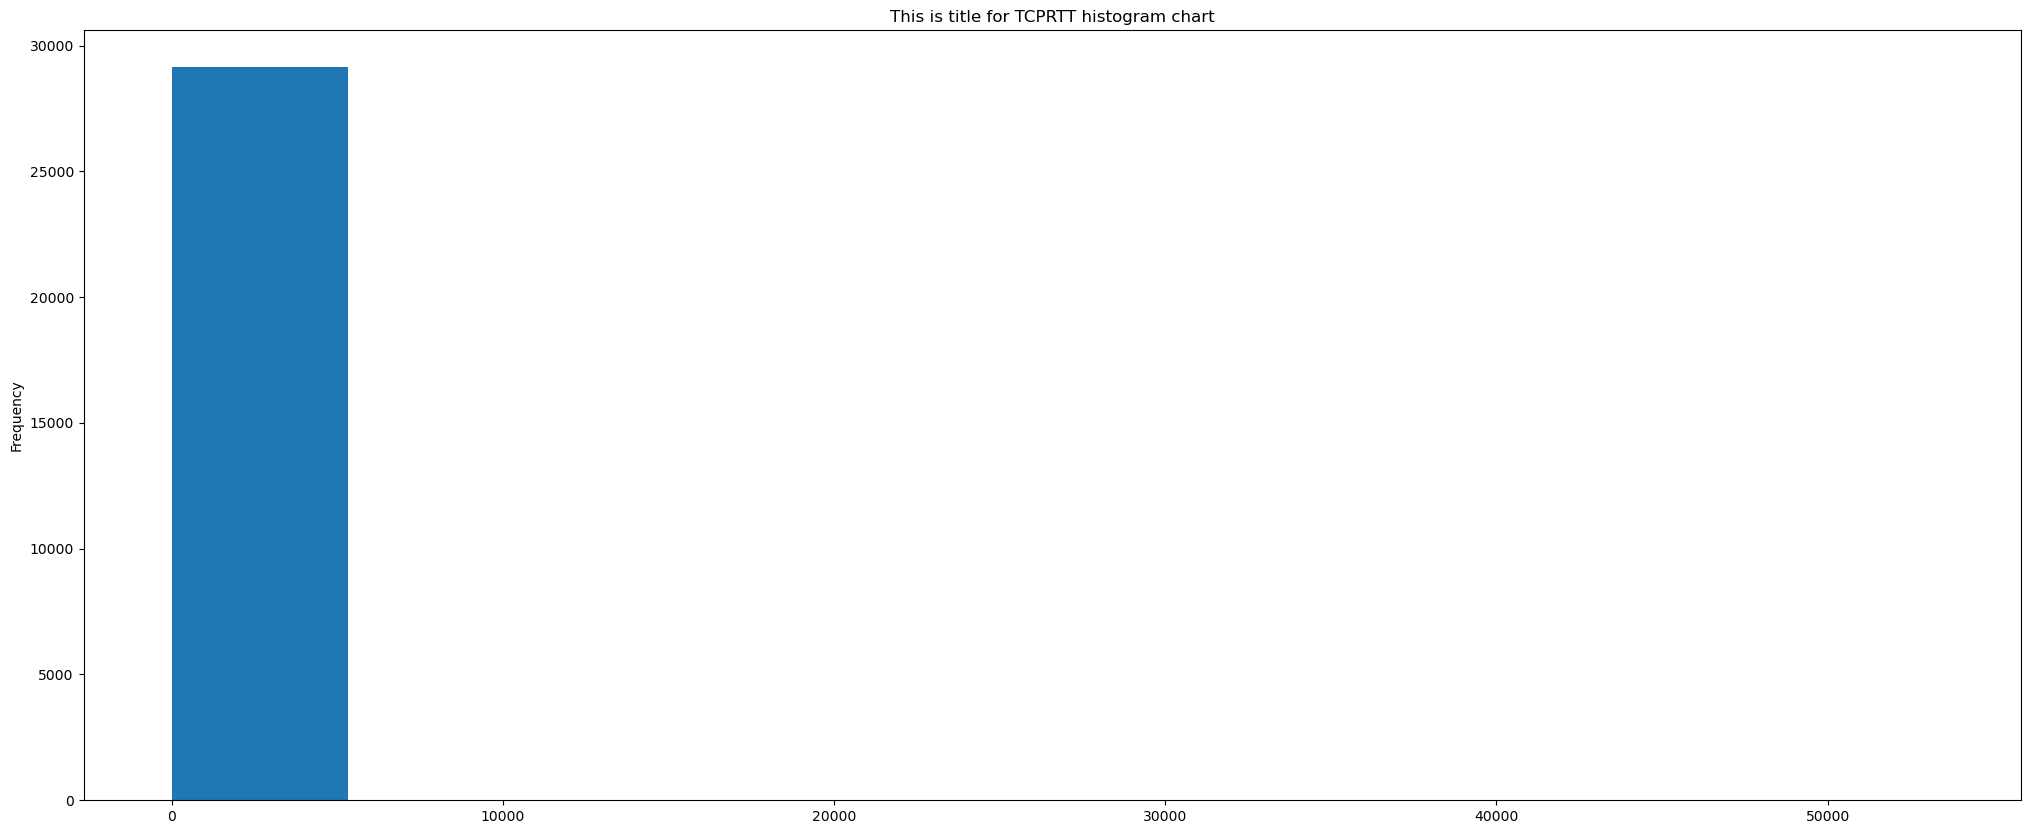

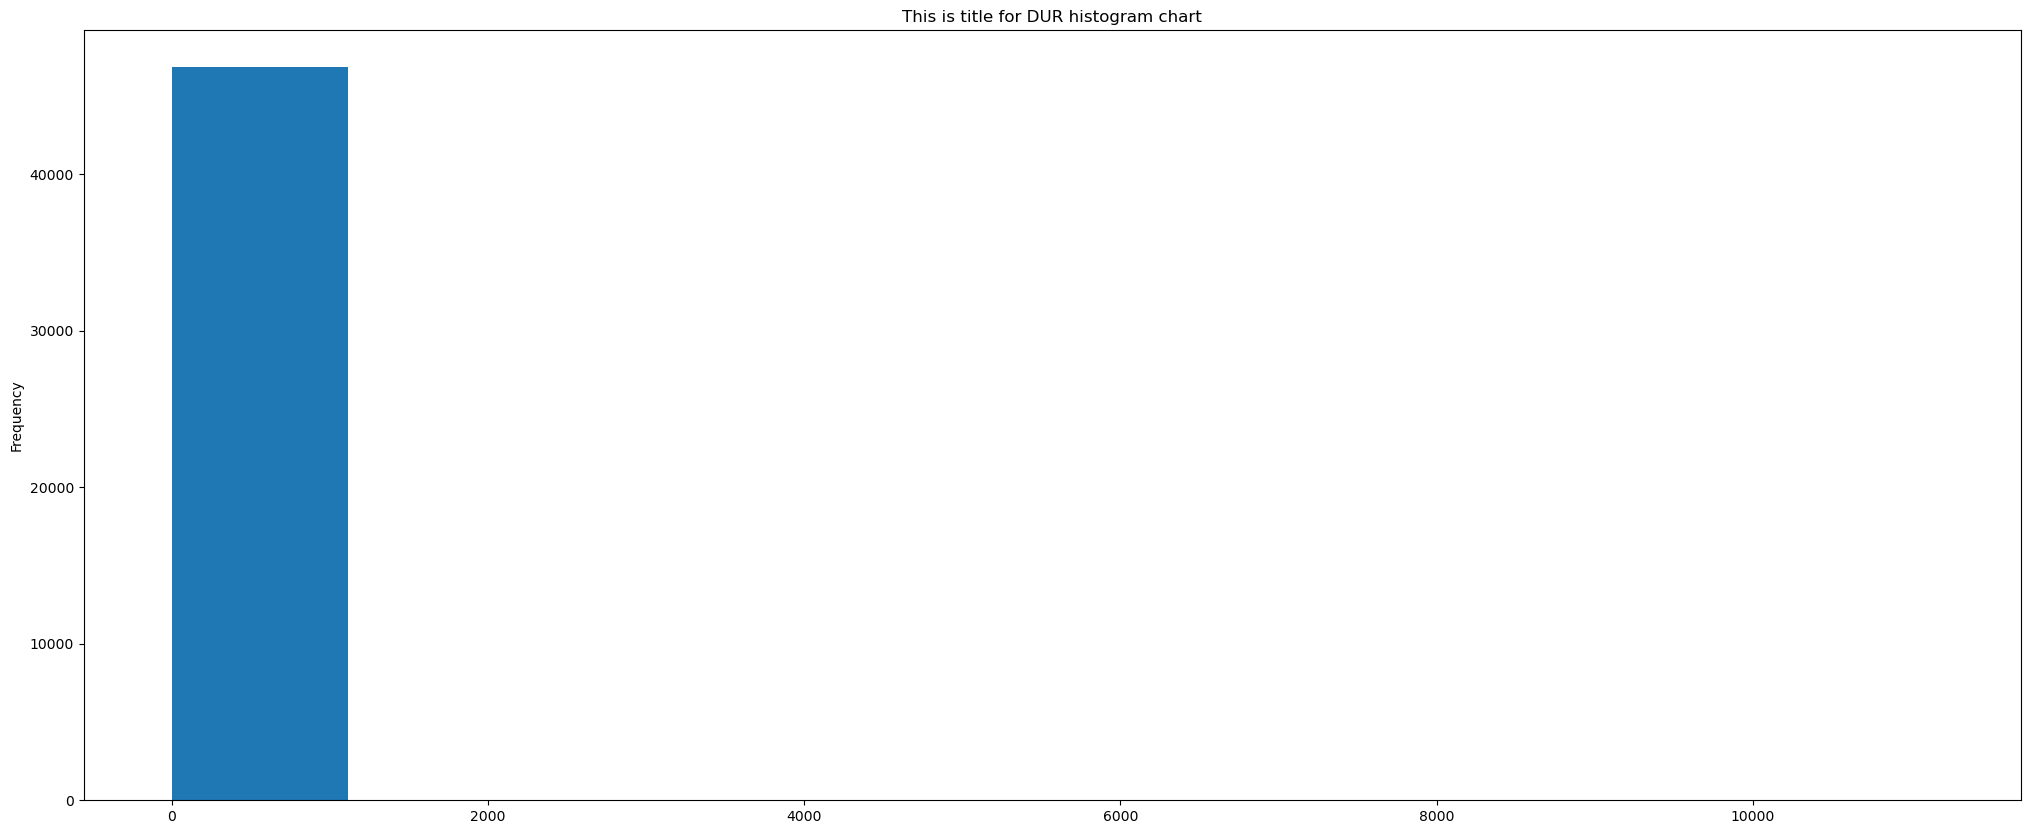

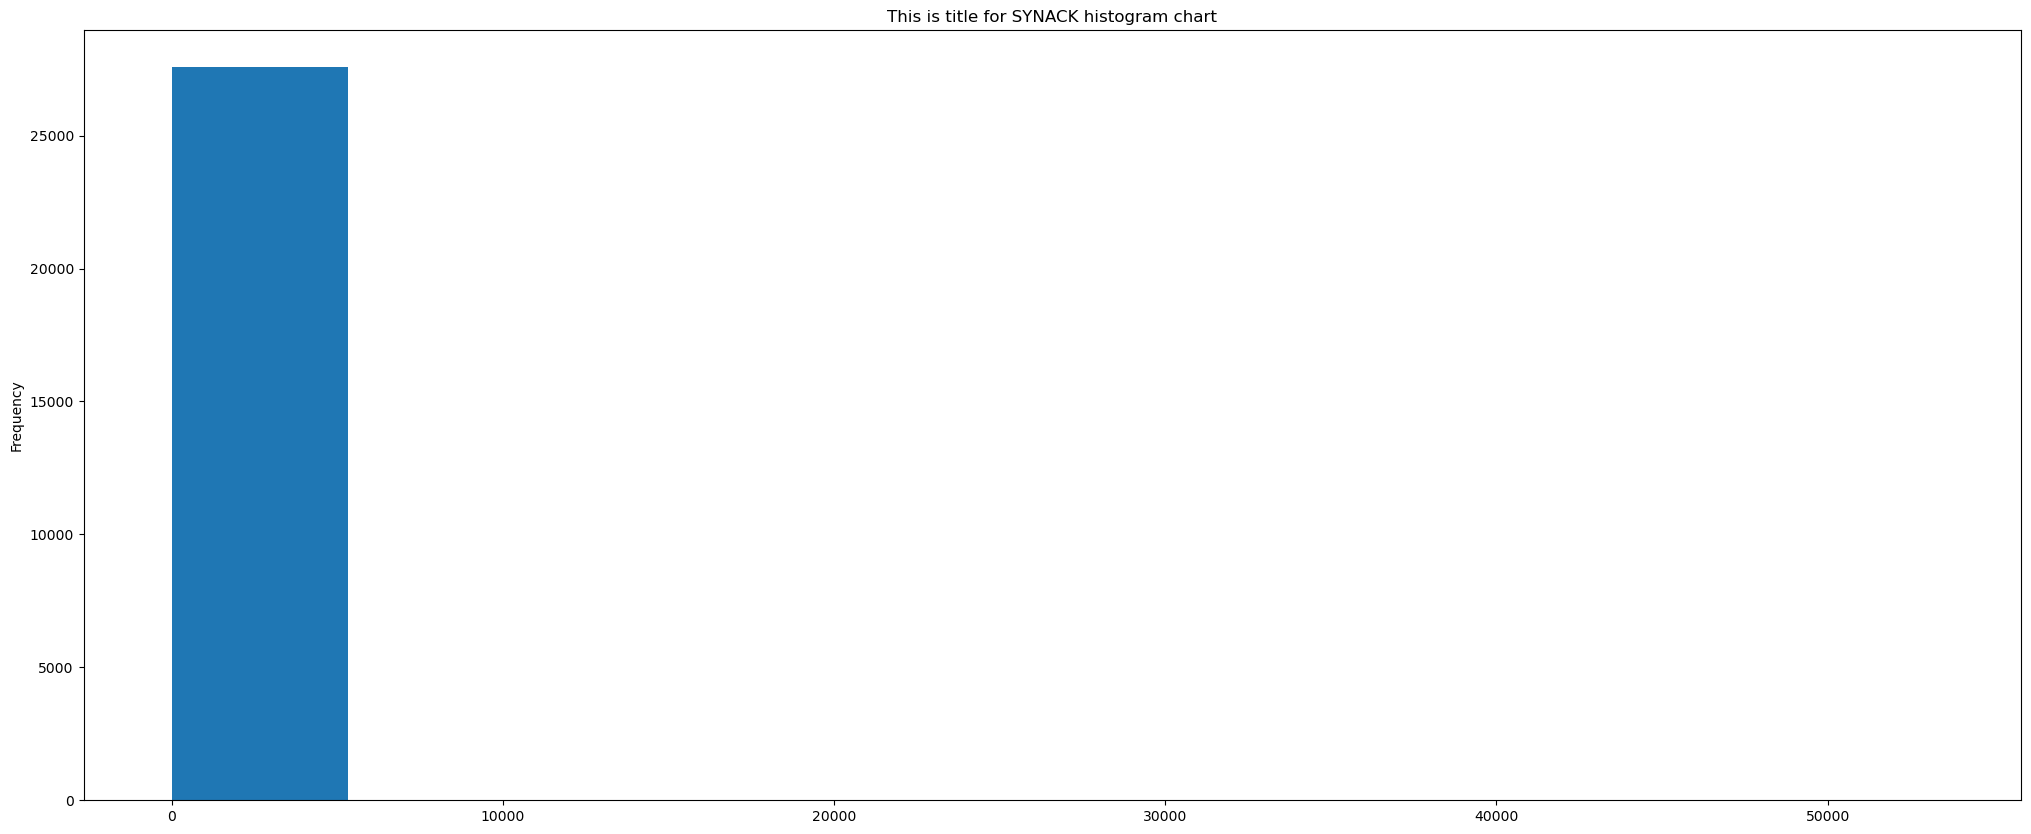

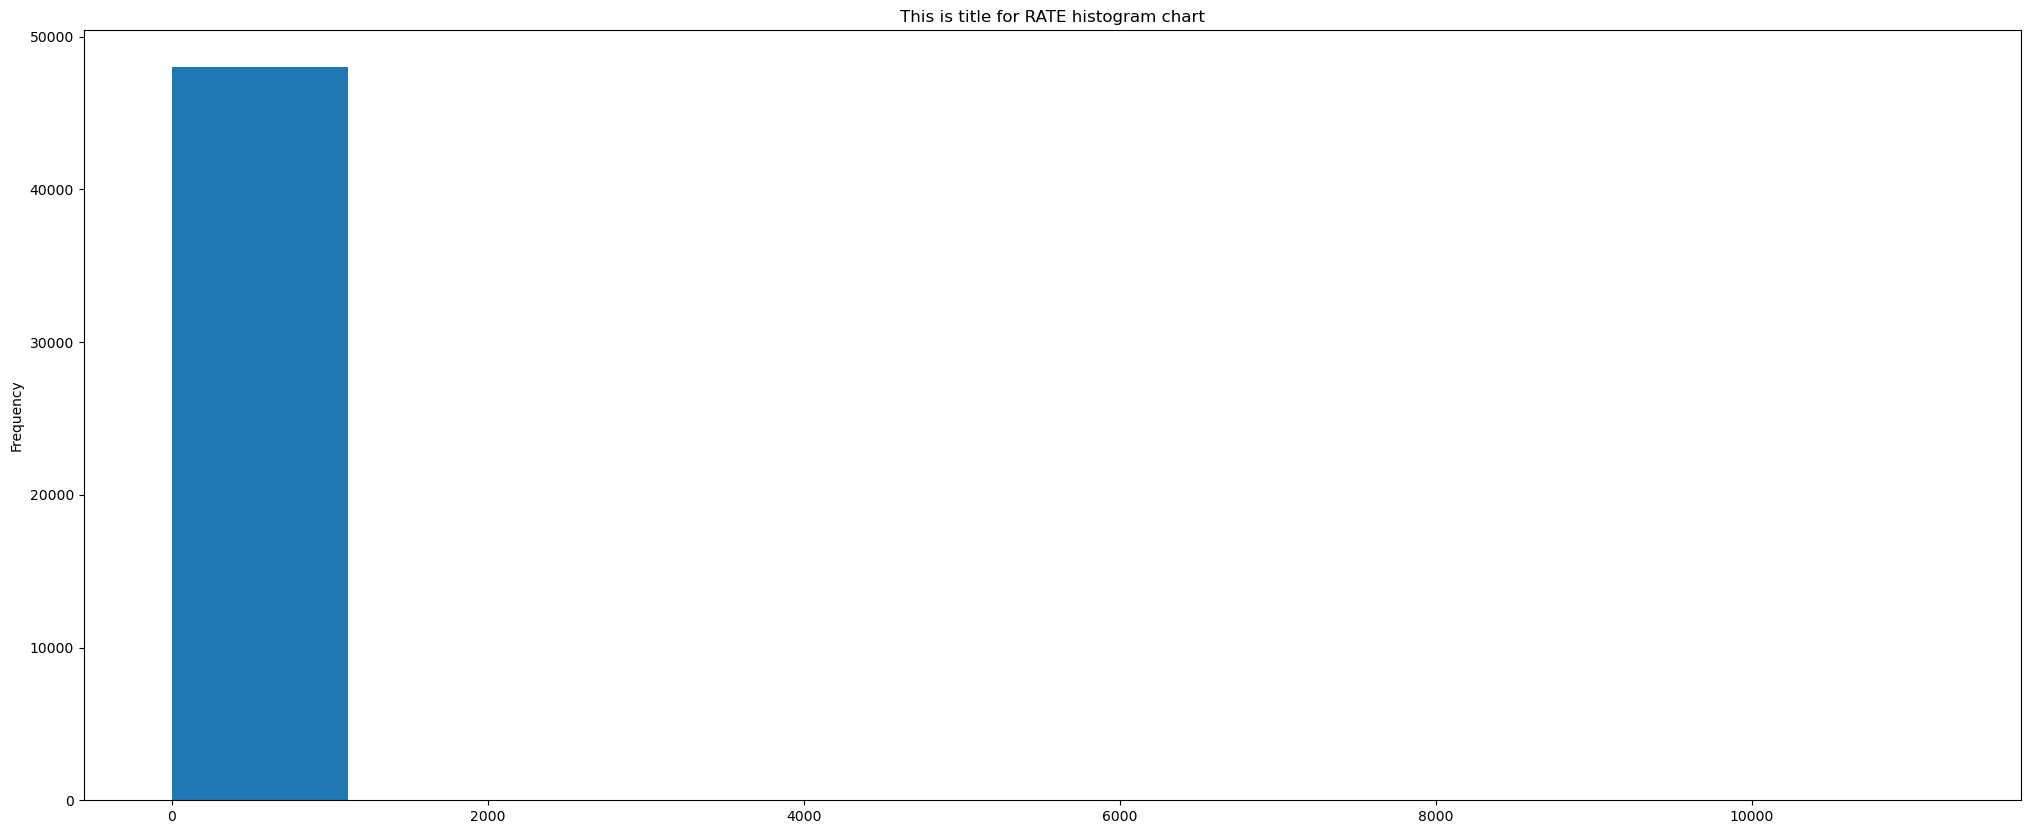

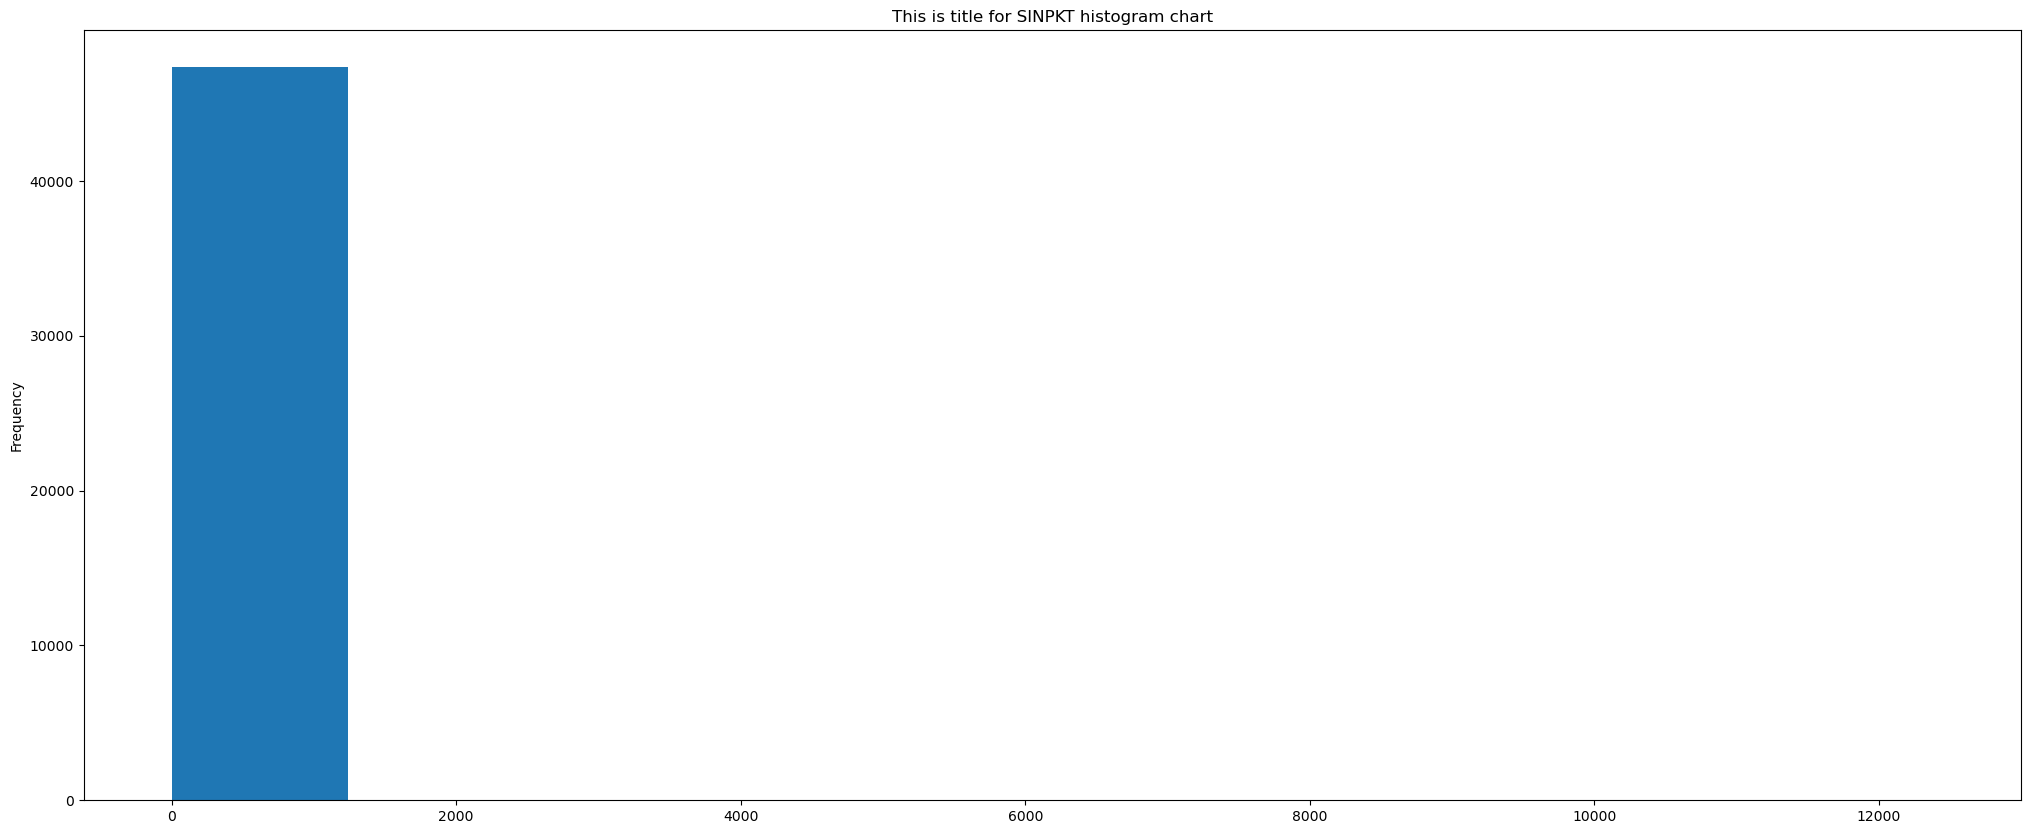

In [52]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

#### Spliting and Standardizing Dataset for Experiment I

In [53]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [54]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

In [55]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)







FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME


Processing feature mapping for protocol_type feature




Processing feature mapping for service feature




Processing feature mapping for flag feature






In [56]:
features_kdd_cup_df.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
4758109         0              0        0     0          0          0     0   
3835672         0              0        0     1          0          0     0   
1575095         0              1        1     2       1032          0     0   
854875          0              0        2     2        237        413     0   
3915036         0              0        0     1          0          0     0   

         wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
4758109               0       0    0  ...             255                  19   
3835672               0       0    0  ...             255                  18   
1575095               0       0    0  ...             255                 255   
854875                0       0    0  ...             109                 255   
3915036               0       0    0  ...             255                   6   

         dst_host_same_srv_rate  dst_host_diff_srv_rate  \
4758109                    0.07                    0.07   
3835672                    0.07                    0.07   
1575095                    1.00                    0.00   
854875                     1.00                    0.00   
3915036                    0.02                    0.05   

         dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
4758109                         0.00                         0.00   
3835672                         0.00                         0.00   
1575095                         1.00                         0.00   
854875                          0.01                         0.02   
3915036                         0.00                         0.00   

         dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
4758109                   0.0                      0.00                   1.0   
3835672                   1.0                      1.00                   0.0   
1575095                   0.0                      0.00                   0.0   
854875                    0.0                      0.01                   0.0   
3915036                   1.0                      1.00                   0.0   

         dst_host_srv_rerror_rate  
4758109                       1.0  
3835672                       0.0  
1575095                       0.0  
854875                        0.0  
3915036                       0.0  

[5 rows x 41 columns]

In [57]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)







FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME


Processing feature mapping for proto feature




Processing feature mapping for service feature




Processing feature mapping for state feature






In [58]:
features_unsw_nb15_df.head()

id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
170833   88502  0.967320      0        0      0     14     14     778     764   
119044   36713  1.251580      0        1      0     14     18    1684   10168   
224630  142299  0.000003      1        2      1      2      0     114       0   
62522    62523  1.397186      0        0      0     10      8     564     354   
187511  105180  0.647762      0        0      0     32     12   27328     642   

                 rate  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
170833      27.912169  ...           3                 3                 1   
119044      24.768692  ...           4                 1                 1   
224630  333333.321500  ...          11                11                11   
62522       12.167313  ...           1                 2                 1   
187511      66.382406  ...           2                 1                 1   

        ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
170833               7             0           0                 0   
119044               4             0           0                 1   
224630              27             0           0                 0   
62522                1             0           0                 0   
187511               4             0           0                 0   

        ct_src_ltm  ct_srv_dst  is_sm_ips_ports  
170833           3           7                0  
119044           3           1                0  
224630          12          27                0  
62522            2           1                0  
187511           2           4                0  

[5 rows x 43 columns]

In [59]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [60]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [61]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [62]:
ros = SMOTE()
start_time = time.time()
kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)
unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)
end_time = time.time()       
print("\n")
print("\n")
print("\n")
print("TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT 1")
print("=========================================================")
print("\n")
print("{:.2f}".format(end_time - start_time))
print("\n")
print("\n")
print("\n")







TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT 1


25.56








In [63]:
print(kddcup_y_train.agg(['nunique','count','size']))
print("\n")
print(kddcup_y_train[kddcup_y_train == 0].count())
print("\n")
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique         2
count      127832
size       127832
Name: traffic_type, dtype: int64


63916


63916


In [64]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique         2
count      102000
size       102000
Name: traffic_type, dtype: int64


51000


51000


In [65]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment I

In [66]:
experiment_type = "EXPERIMENT-ONE"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.86      0.97      0.91      3494
      Attack       0.99      0.97      0.98     16506

    accuracy                           0.97     20000
   macro avg       0.93      0.97      0.95     20000
weighted avg       0.97      0.97      0.97     20000







CONFUSION MATRIX




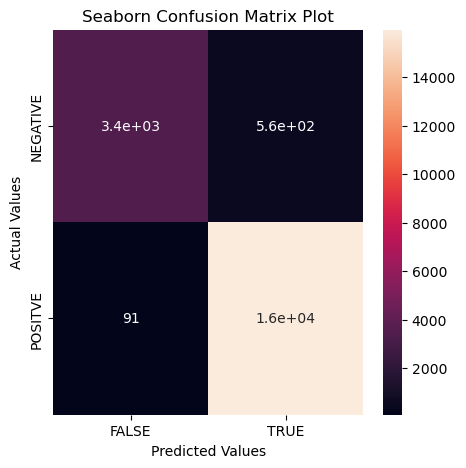







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9268
GEOMETRIC MEAN SCORE:  0.9244






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.44










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.80      0.70      0.75      8114
      Attack       0.81      0.88      0.85     11886

    accuracy                           0.81     20000
   macro avg       0.81      0.79      0.80     20000
weighted avg       0.81      0.81      0.81     20000







CONFUSION MATRIX




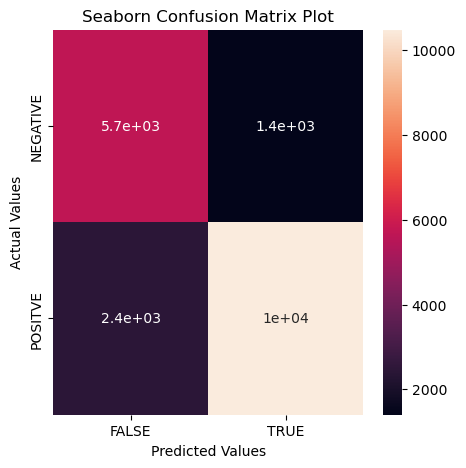







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8065
GEOMETRIC MEAN SCORE:  0.8065






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.40








In [67]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      3984
      Attack       1.00      1.00      1.00     16016

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




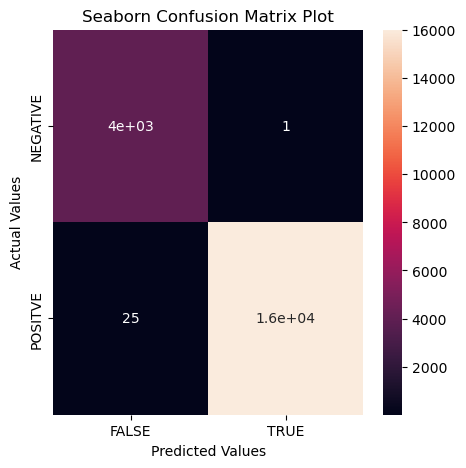







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9991
GEOMETRIC MEAN SCORE:  0.9991






TIME TAKEN TO COMPLETE MODEL ANALYSIS


9.71










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.93      0.84      0.88      7799
      Attack       0.91      0.96      0.93     12201

    accuracy                           0.91     20000
   macro avg       0.92      0.90      0.91     20000
weighted avg       0.91      0.91      0.91     20000







CONFUSION MATRIX




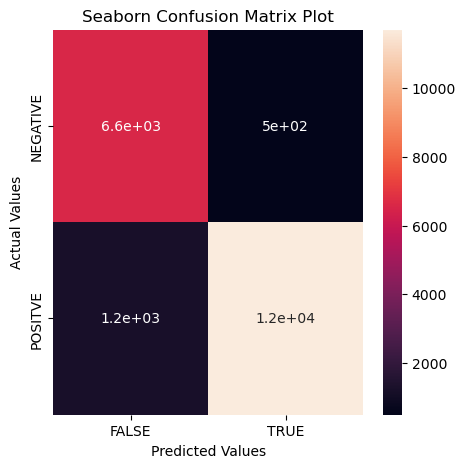







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9175
GEOMETRIC MEAN SCORE:  0.9174






TIME TAKEN TO COMPLETE MODEL ANALYSIS


410.41








In [68]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      4025
      Attack       1.00      1.00      1.00     15975

    accuracy                           1.00     20000
   macro avg       1.00      0.99      0.99     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




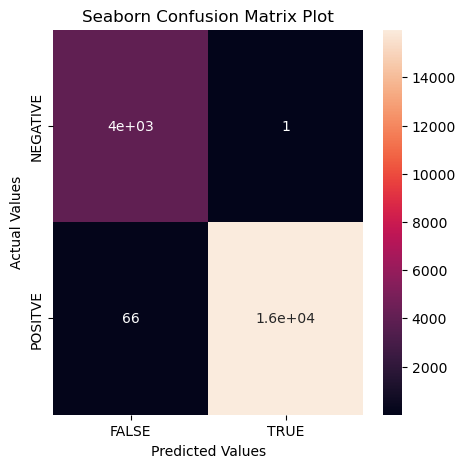







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9978
GEOMETRIC MEAN SCORE:  0.9978






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.86










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.67      0.80     10430
      Attack       0.74      0.99      0.85      9570

    accuracy                           0.83     20000
   macro avg       0.86      0.83      0.82     20000
weighted avg       0.87      0.83      0.82     20000







CONFUSION MATRIX




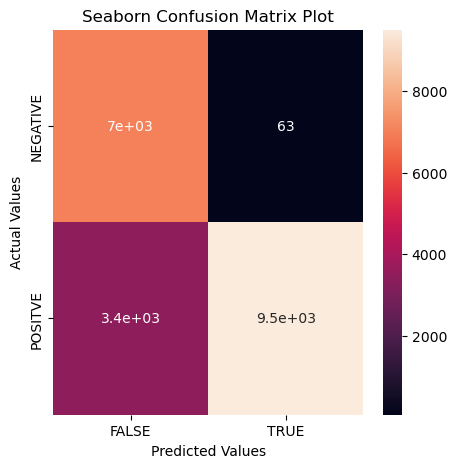







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8632
GEOMETRIC MEAN SCORE:  0.8537






TIME TAKEN TO COMPLETE MODEL ANALYSIS


1.39








In [69]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3967
      Attack       1.00      1.00      1.00     16033

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




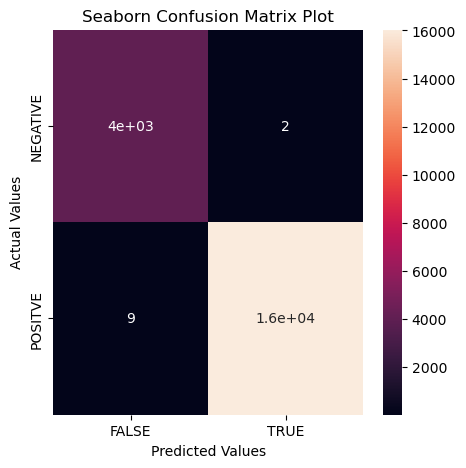







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9995
GEOMETRIC MEAN SCORE:  0.9995






TIME TAKEN TO COMPLETE MODEL ANALYSIS


3.81










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95      7348
      Attack       0.96      0.98      0.97     12652

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000







CONFUSION MATRIX




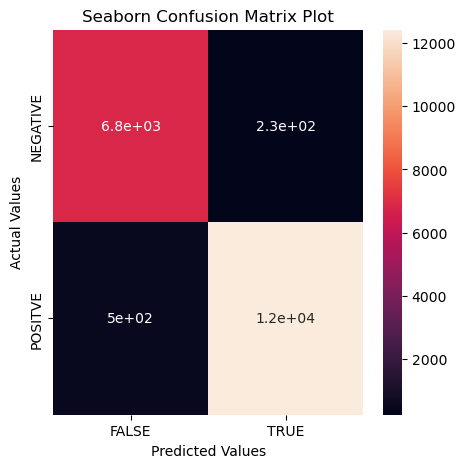







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9646
GEOMETRIC MEAN SCORE:  0.9646






TIME TAKEN TO COMPLETE MODEL ANALYSIS


10.18








In [70]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1279/1279 [==============================] - 7s 5ms/step - loss: 0.3045 - accuracy: 0.9484
Epoch 2/10
1279/1279 [==============================] - 5s 4ms/step - loss: 0.1081 - accuracy: 0.9974
Epoch 3/10
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0570 - accuracy: 0.9975
Epoch 4/10
1

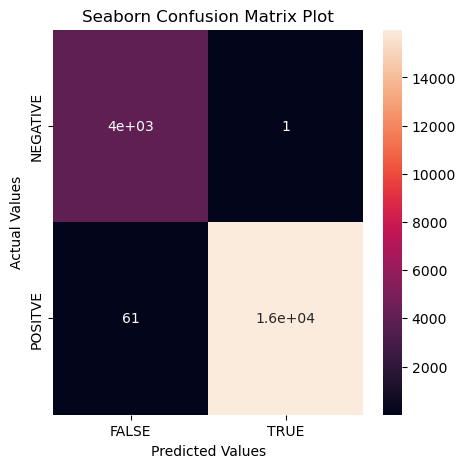







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9980
GEOMETRIC MEAN SCORE:  0.9980






TIME TAKEN TO COMPLETE MODEL ANALYSIS


70.35






Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1020/1020 [==============================] - 6s 4ms/step - loss: 0.4792 - accuracy: 0.8173
Epoch 2/10
1020/1020 [==============================] - 4s 4ms/step - 

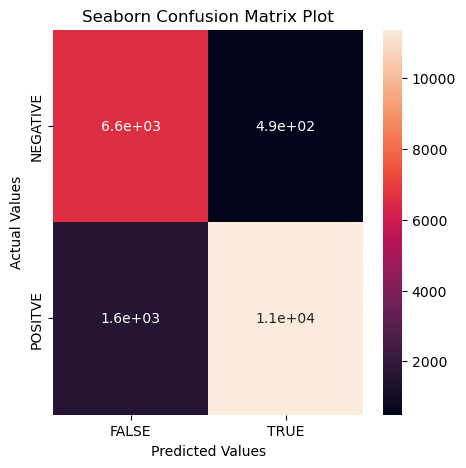







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9051
GEOMETRIC MEAN SCORE:  0.9047






TIME TAKEN TO COMPLETE MODEL ANALYSIS


54.72








In [71]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment I

In [72]:
Exp_1_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [73]:
Exp_1_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [74]:
Exp_1_KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.926835  0.924374
SVM  0.999094  0.999094
DTC  0.997816  0.997815
RFC  0.999467  0.999467
ANN  0.997972  0.997971

In [75]:
Exp_1_UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.806527  0.806514
SVM  0.917482  0.917401
DTC  0.863207  0.853682
RFC  0.964567  0.964561
ANN  0.905061  0.904697

#### Repeat Experiment I

In [76]:
experiment_type = "EXPERIMENT-ONE-REPEAT"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.86      0.97      0.91      3494
      Attack       0.99      0.97      0.98     16506

    accuracy                           0.97     20000
   macro avg       0.93      0.97      0.95     20000
weighted avg       0.97      0.97      0.97     20000







CONFUSION MATRIX




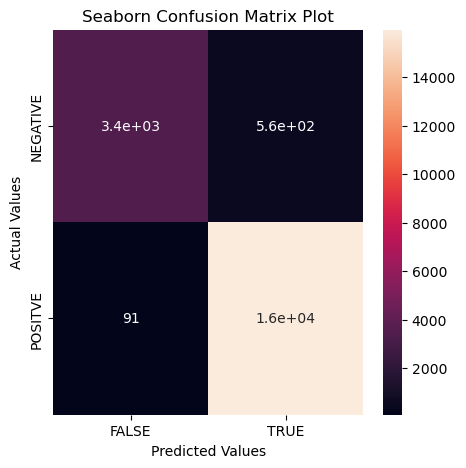







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9268
GEOMETRIC MEAN SCORE:  0.9244






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.68










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.80      0.70      0.75      8114
      Attack       0.81      0.88      0.85     11886

    accuracy                           0.81     20000
   macro avg       0.81      0.79      0.80     20000
weighted avg       0.81      0.81      0.81     20000







CONFUSION MATRIX




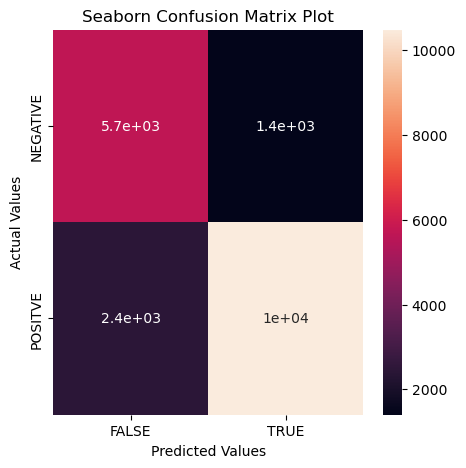







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8065
GEOMETRIC MEAN SCORE:  0.8065






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.46








In [77]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      3984
      Attack       1.00      1.00      1.00     16016

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




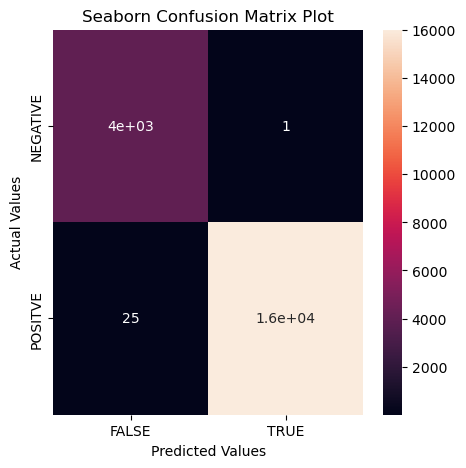







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9991
GEOMETRIC MEAN SCORE:  0.9991






TIME TAKEN TO COMPLETE MODEL ANALYSIS


12.34










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.93      0.84      0.88      7799
      Attack       0.91      0.96      0.93     12201

    accuracy                           0.91     20000
   macro avg       0.92      0.90      0.91     20000
weighted avg       0.91      0.91      0.91     20000







CONFUSION MATRIX




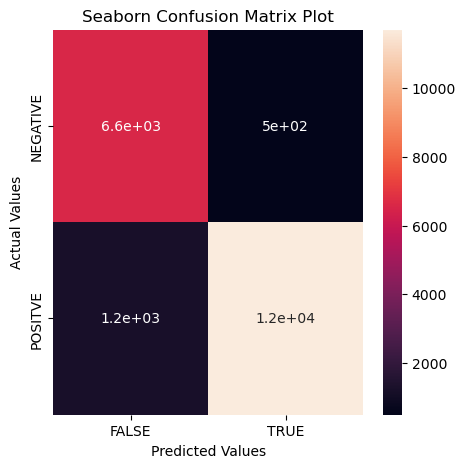







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9175
GEOMETRIC MEAN SCORE:  0.9174






TIME TAKEN TO COMPLETE MODEL ANALYSIS


369.63








In [78]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      4025
      Attack       1.00      1.00      1.00     15975

    accuracy                           1.00     20000
   macro avg       1.00      0.99      0.99     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




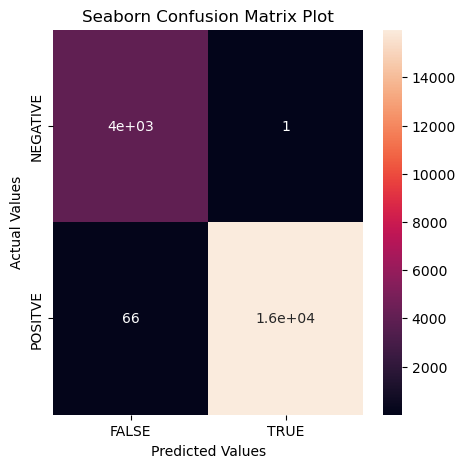







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9978
GEOMETRIC MEAN SCORE:  0.9978






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.64










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.67      0.80     10430
      Attack       0.74      0.99      0.85      9570

    accuracy                           0.83     20000
   macro avg       0.86      0.83      0.82     20000
weighted avg       0.87      0.83      0.82     20000







CONFUSION MATRIX




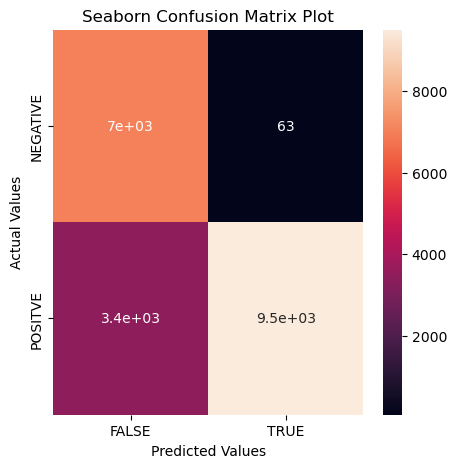







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8632
GEOMETRIC MEAN SCORE:  0.8537






TIME TAKEN TO COMPLETE MODEL ANALYSIS


1.27








In [79]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3964
      Attack       1.00      1.00      1.00     16036

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




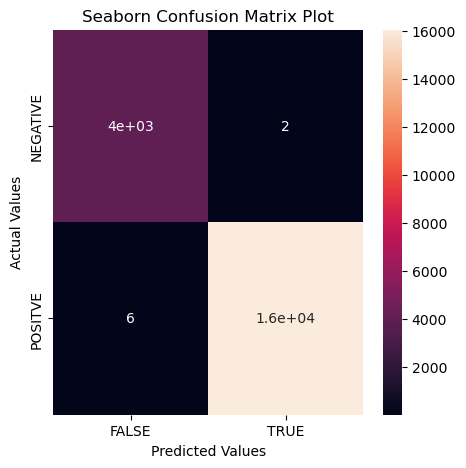







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9996
GEOMETRIC MEAN SCORE:  0.9996






TIME TAKEN TO COMPLETE MODEL ANALYSIS


3.03










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94      7394
      Attack       0.95      0.98      0.97     12606

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000







CONFUSION MATRIX




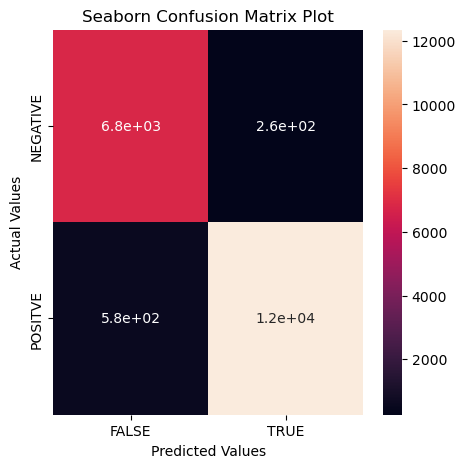







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9590
GEOMETRIC MEAN SCORE:  0.9590






TIME TAKEN TO COMPLETE MODEL ANALYSIS


6.57








In [80]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 41)                1722      
                                                                 
 dense_7 (Dense)             (None, 1)                 42        
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1279/1279 [==============================] - 5s 3ms/step - loss: 0.4137 - accuracy: 0.9560
Epoch 2/10
1279/1279 [==============================] - 4s 3ms/step - loss: 0.1713 - accuracy: 0.9974
Epoch 3/10
1279/1279 [==============================] - 4s 3ms/step - loss: 0.0886 - accuracy: 0.9974
Epoch 4/10

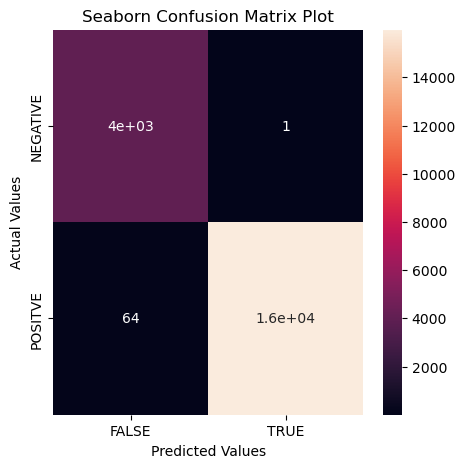







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9979
GEOMETRIC MEAN SCORE:  0.9979






TIME TAKEN TO COMPLETE MODEL ANALYSIS


46.40






Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 43)                1892      
                                                                 
 dense_10 (Dense)            (None, 1)                 44        
                                                                 
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1020/1020 [==============================] - 5s 4ms/step - loss: 0.5049 - accuracy: 0.8003
Epoch 2/10
1020/1020 [==============================] - 3s 3ms/step - 

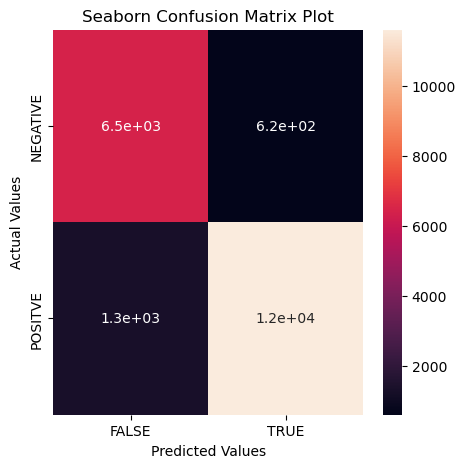







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9051
GEOMETRIC MEAN SCORE:  0.9051






TIME TAKEN TO COMPLETE MODEL ANALYSIS


36.99








In [81]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Repeat Experiment I

In [82]:
Rep_Exp_1_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [83]:
Rep_Exp_1_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [84]:
Rep_Exp_1_KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.926835  0.924374
SVM  0.999094  0.999094
DTC  0.997816  0.997815
RFC  0.999560  0.999560
ANN  0.997879  0.997877

In [85]:
Rep_Exp_1_UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.806527  0.806514
SVM  0.917482  0.917401
DTC  0.863207  0.853682
RFC  0.958959  0.958951
ANN  0.905111  0.905082

### Experiment II Setup

#### Correlation Heatmap for the two datasets

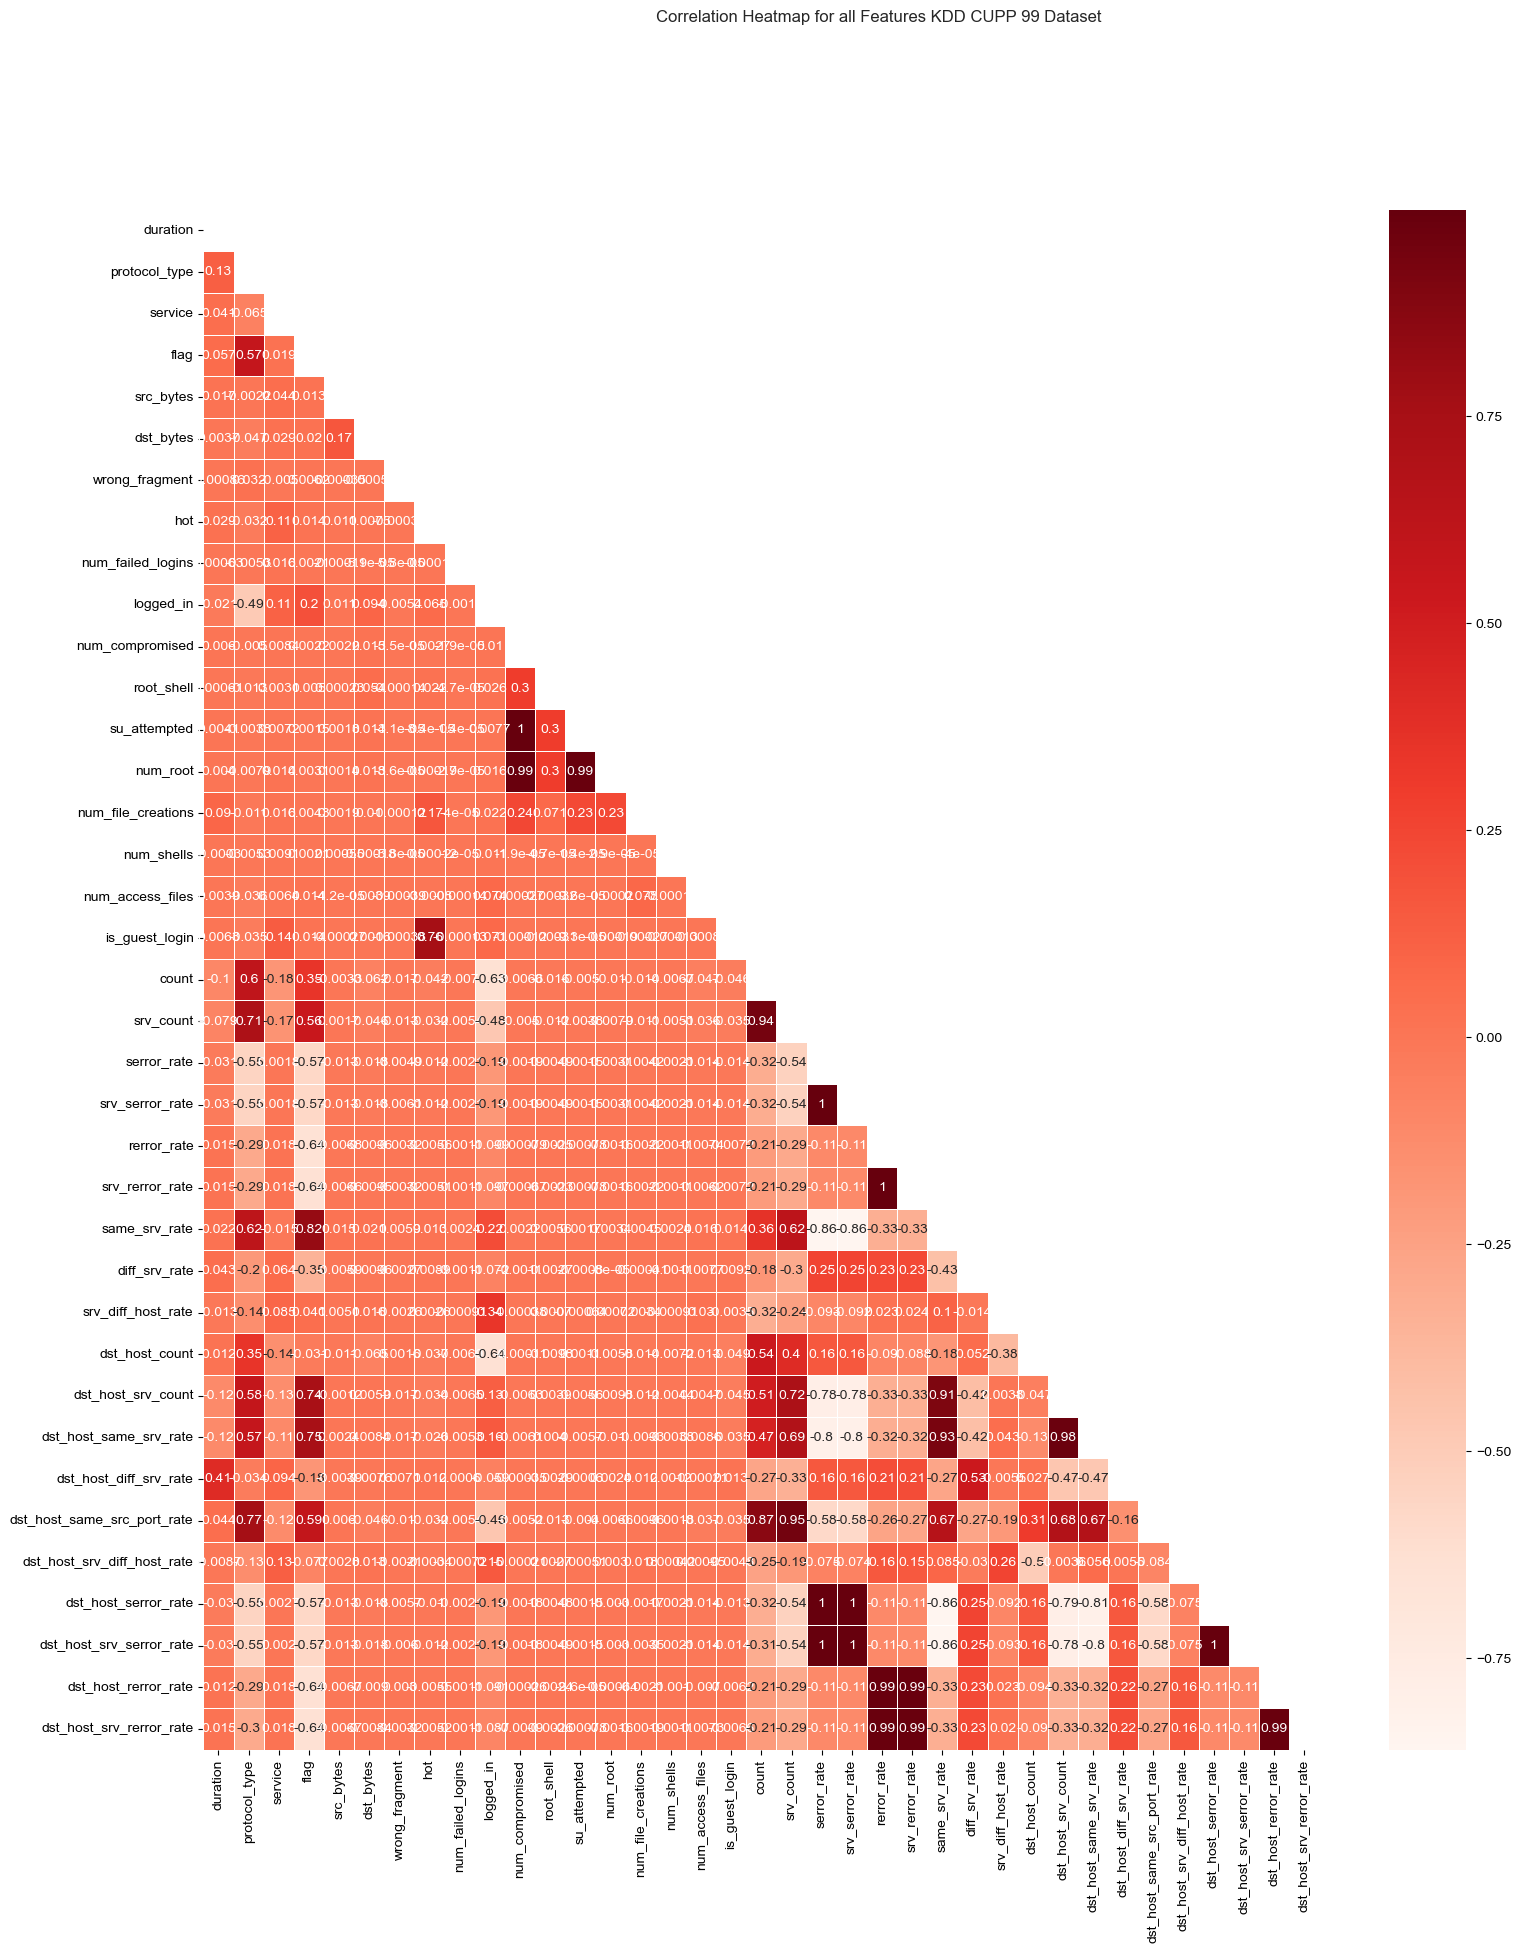

In [86]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

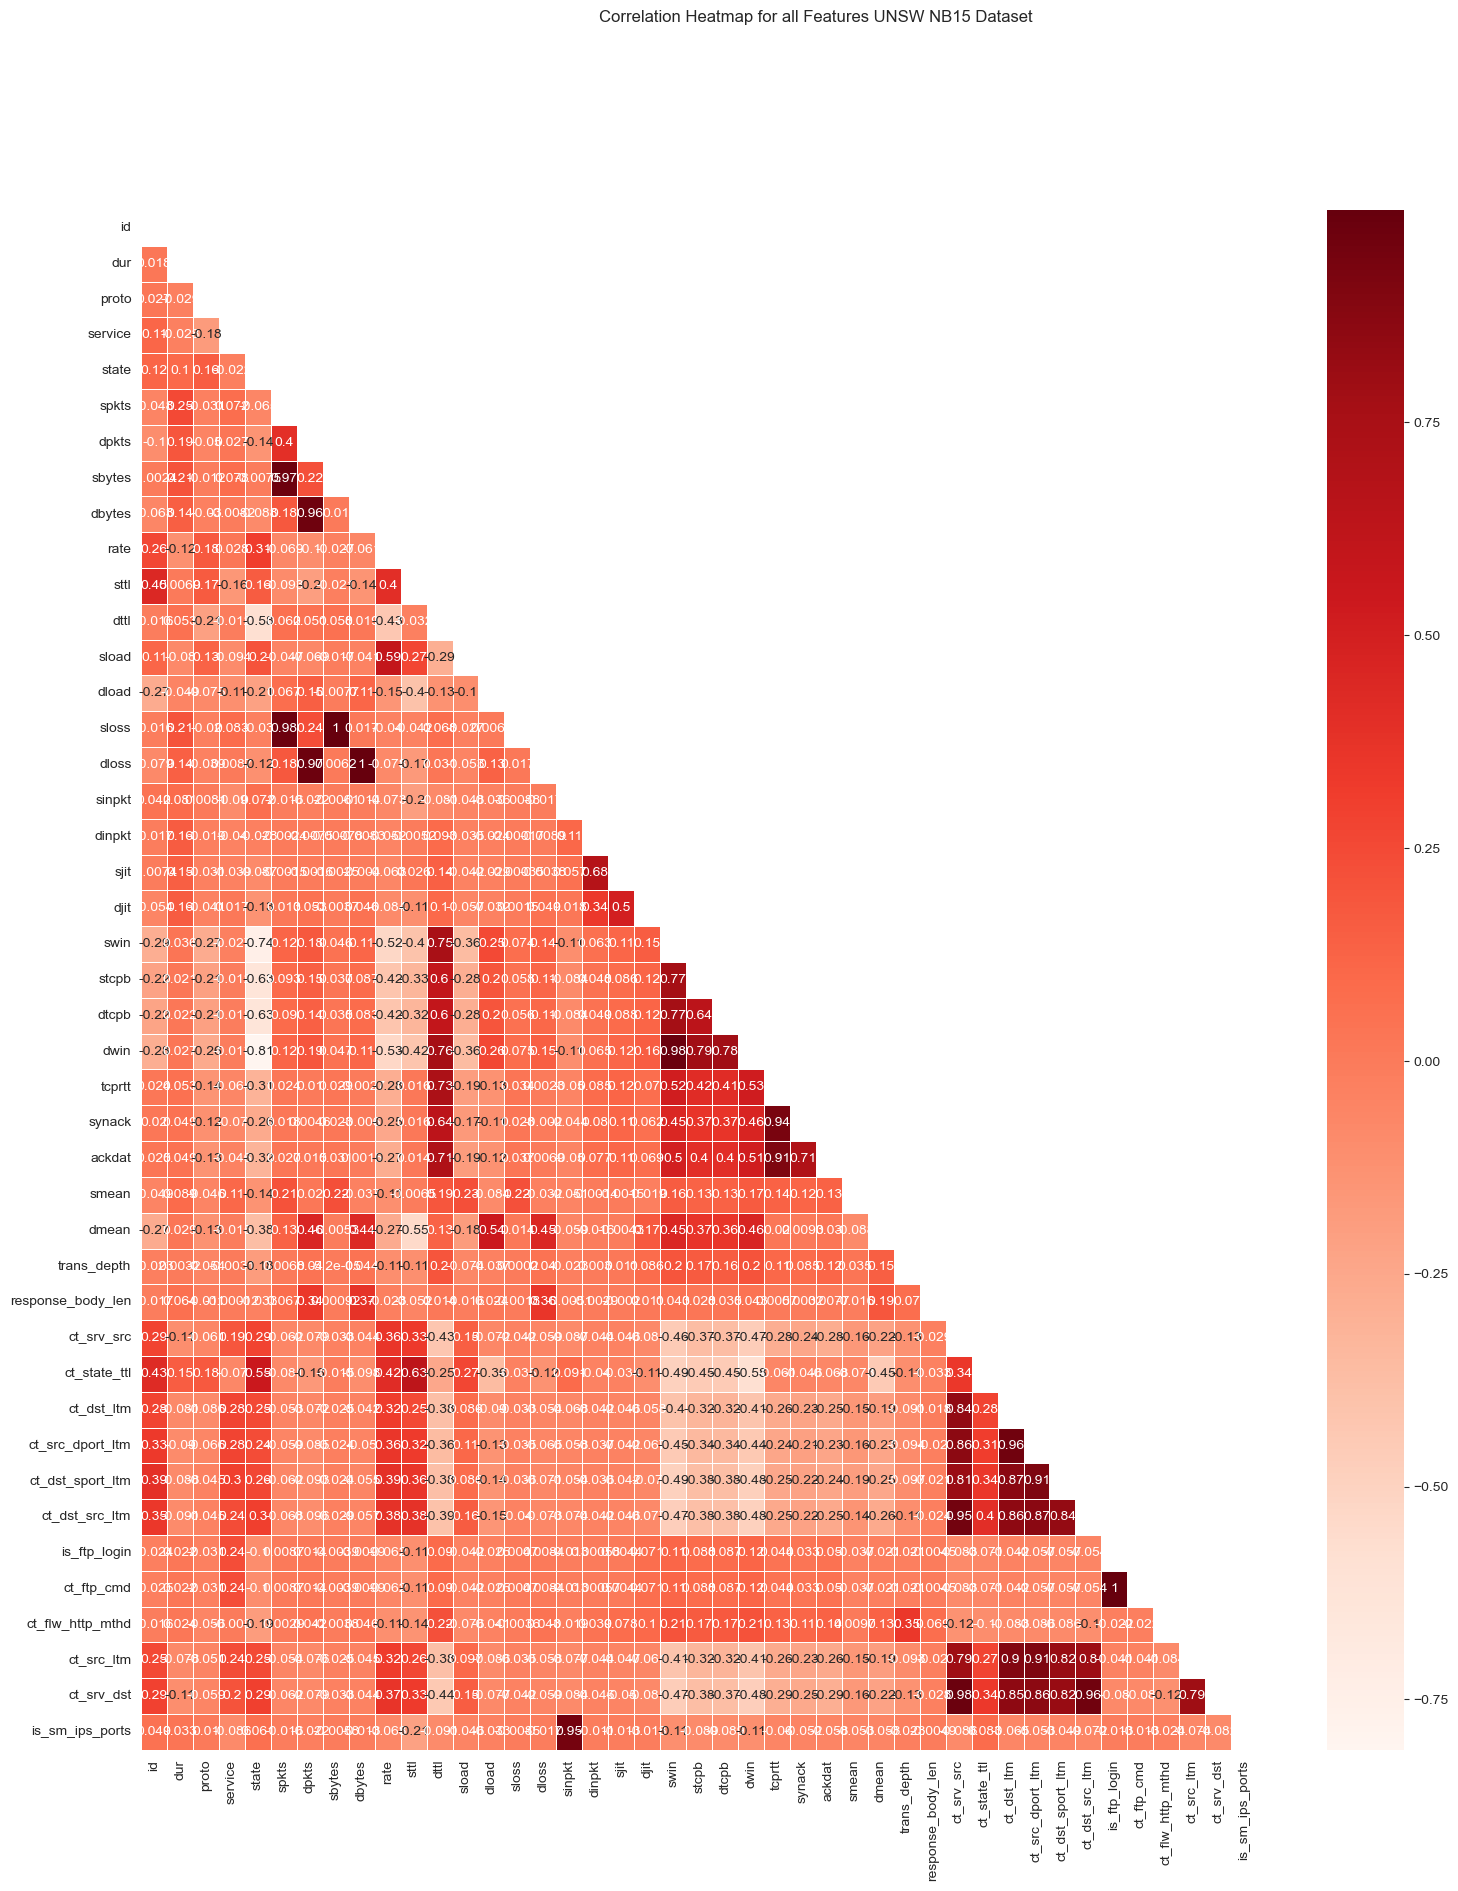

In [87]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [88]:
highly_correlation_kdd_cup_99_features = estimate_correlation_to_select_highly_correlated_features(features_kdd_cup_df, 0.90)







FEATURES WITH HIGH CORRELATION VALUES


Correlation between SU_ATTEMPTED and NUM_COMPROMISED feature is 0.9976892037995608




Correlation between NUM_ROOT and SU_ATTEMPTED feature is 0.9910857657859696




Correlation between SRV_COUNT and COUNT feature is 0.9434876386409715




Correlation between SRV_SERROR_RATE and SERROR_RATE feature is 0.9988857381620359




Correlation between SRV_RERROR_RATE and RERROR_RATE feature is 0.9958459804879769




Correlation between DST_HOST_SRV_COUNT and SAME_SRV_RATE feature is 0.9078903936482359




Correlation between DST_HOST_SAME_SRV_RATE and DST_HOST_SRV_COUNT feature is 0.9802711686382364




Correlation between DST_HOST_SAME_SRC_PORT_RATE and SRV_COUNT feature is 0.9486256948244692




Correlation between DST_HOST_SERROR_RATE and SRV_SERROR_RATE feature is 0.9978149868206437




Correlation between DST_HOST_SRV_SERROR_RATE and DST_HOST_SERROR_RATE feature is 0.9982116680137462




Correlation between DST_HOST_RERROR_RATE and SRV_RERROR

In [89]:
highly_correlation_unswnb15_features = estimate_correlation_to_select_highly_correlated_features(features_unsw_nb15_df, 0.90)







FEATURES WITH HIGH CORRELATION VALUES


Correlation between SBYTES and SPKTS feature is 0.9720290731012713




Correlation between DBYTES and DPKTS feature is 0.9645070007961772




Correlation between SLOSS and SBYTES feature is 0.996978670317154




Correlation between DLOSS and DBYTES feature is 0.9960380835190039




Correlation between DWIN and SWIN feature is 0.9801110387697173




Correlation between SYNACK and TCPRTT feature is 0.935860278164659




Correlation between ACKDAT and TCPRTT feature is 0.9112187947407813




Correlation between CT_SRC_DPORT_LTM and CT_DST_LTM feature is 0.9605278540757131




Correlation between CT_DST_SPORT_LTM and CT_SRC_DPORT_LTM feature is 0.908488801208534




Correlation between CT_DST_SRC_LTM and CT_SRV_SRC feature is 0.9542757180110639




Correlation between CT_FTP_CMD and IS_FTP_LOGIN feature is 0.9996174336092473




Correlation between CT_SRC_LTM and CT_SRC_DPORT_LTM feature is 0.9080424094430082




Correlation between CT_SRV_DST 

In [90]:
highly_correlation_kdd_cup_99_features
features_kdd_cup_df.drop(highly_correlation_kdd_cup_99_features, axis=1,  inplace = True)

['dst_host_srv_rerror_rate',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'srv_serror_rate',
 'srv_rerror_rate',
 'su_attempted',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_srv_serror_rate',
 'num_root',
 'dst_host_serror_rate',
 'dst_host_rerror_rate']

In [91]:
highly_correlation_unswnb15_features
features_unsw_nb15_df.drop(highly_correlation_unswnb15_features, axis=1,  inplace = True)

['is_sm_ips_ports',
 'ackdat',
 'ct_dst_sport_ltm',
 'synack',
 'dbytes',
 'ct_ftp_cmd',
 'ct_src_ltm',
 'sloss',
 'ct_dst_src_ltm',
 'dwin',
 'ct_srv_dst',
 'sbytes',
 'ct_src_dport_ltm',
 'dloss']

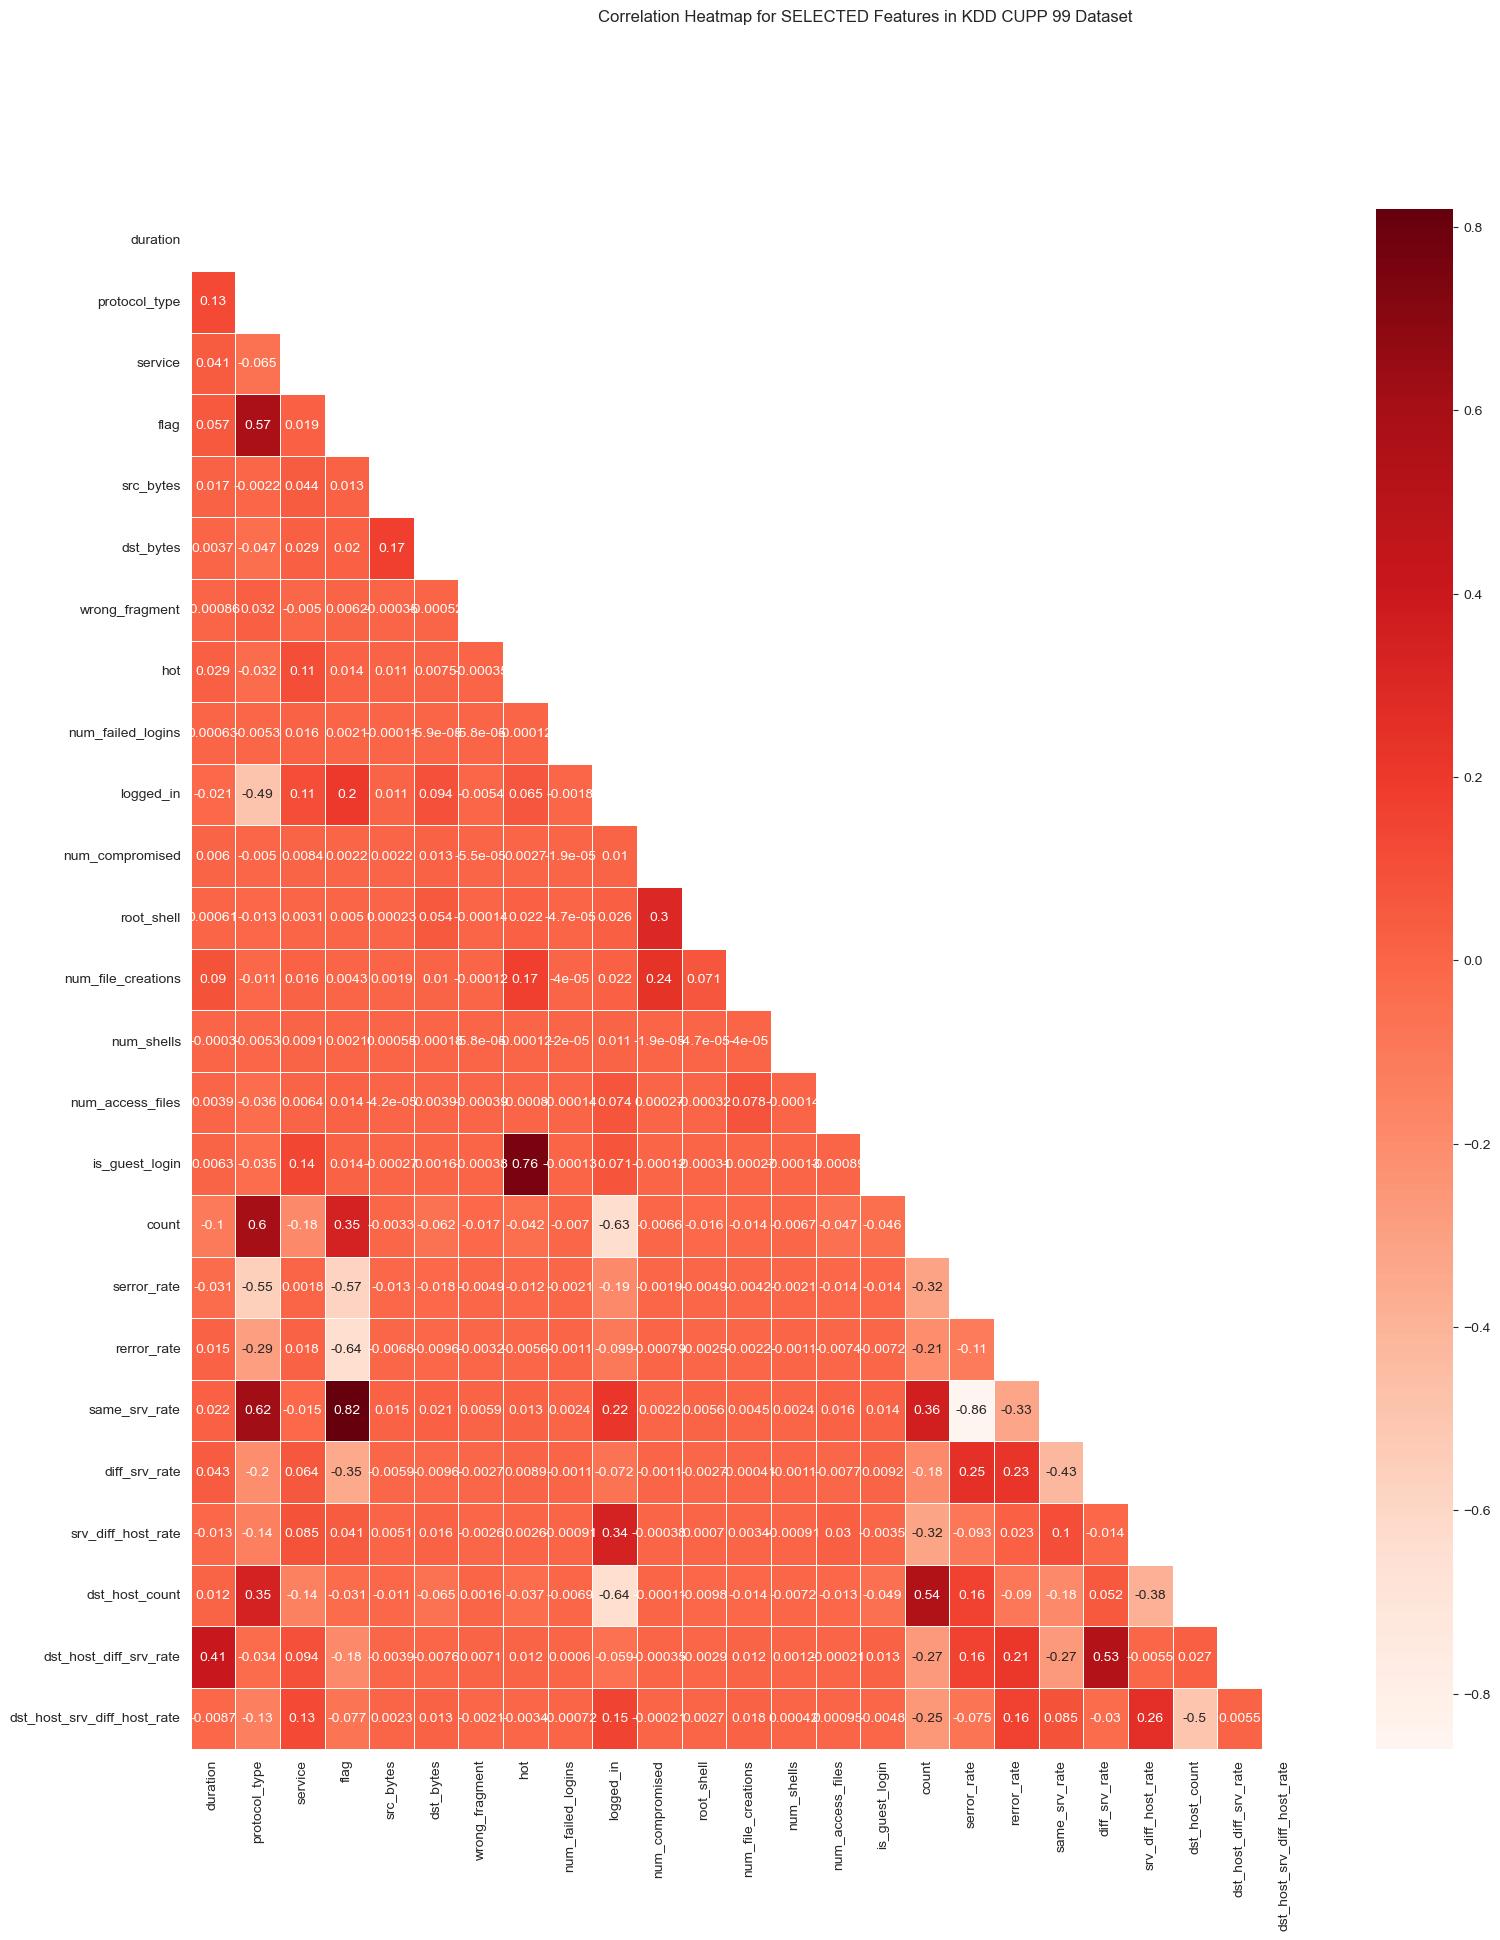

In [92]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

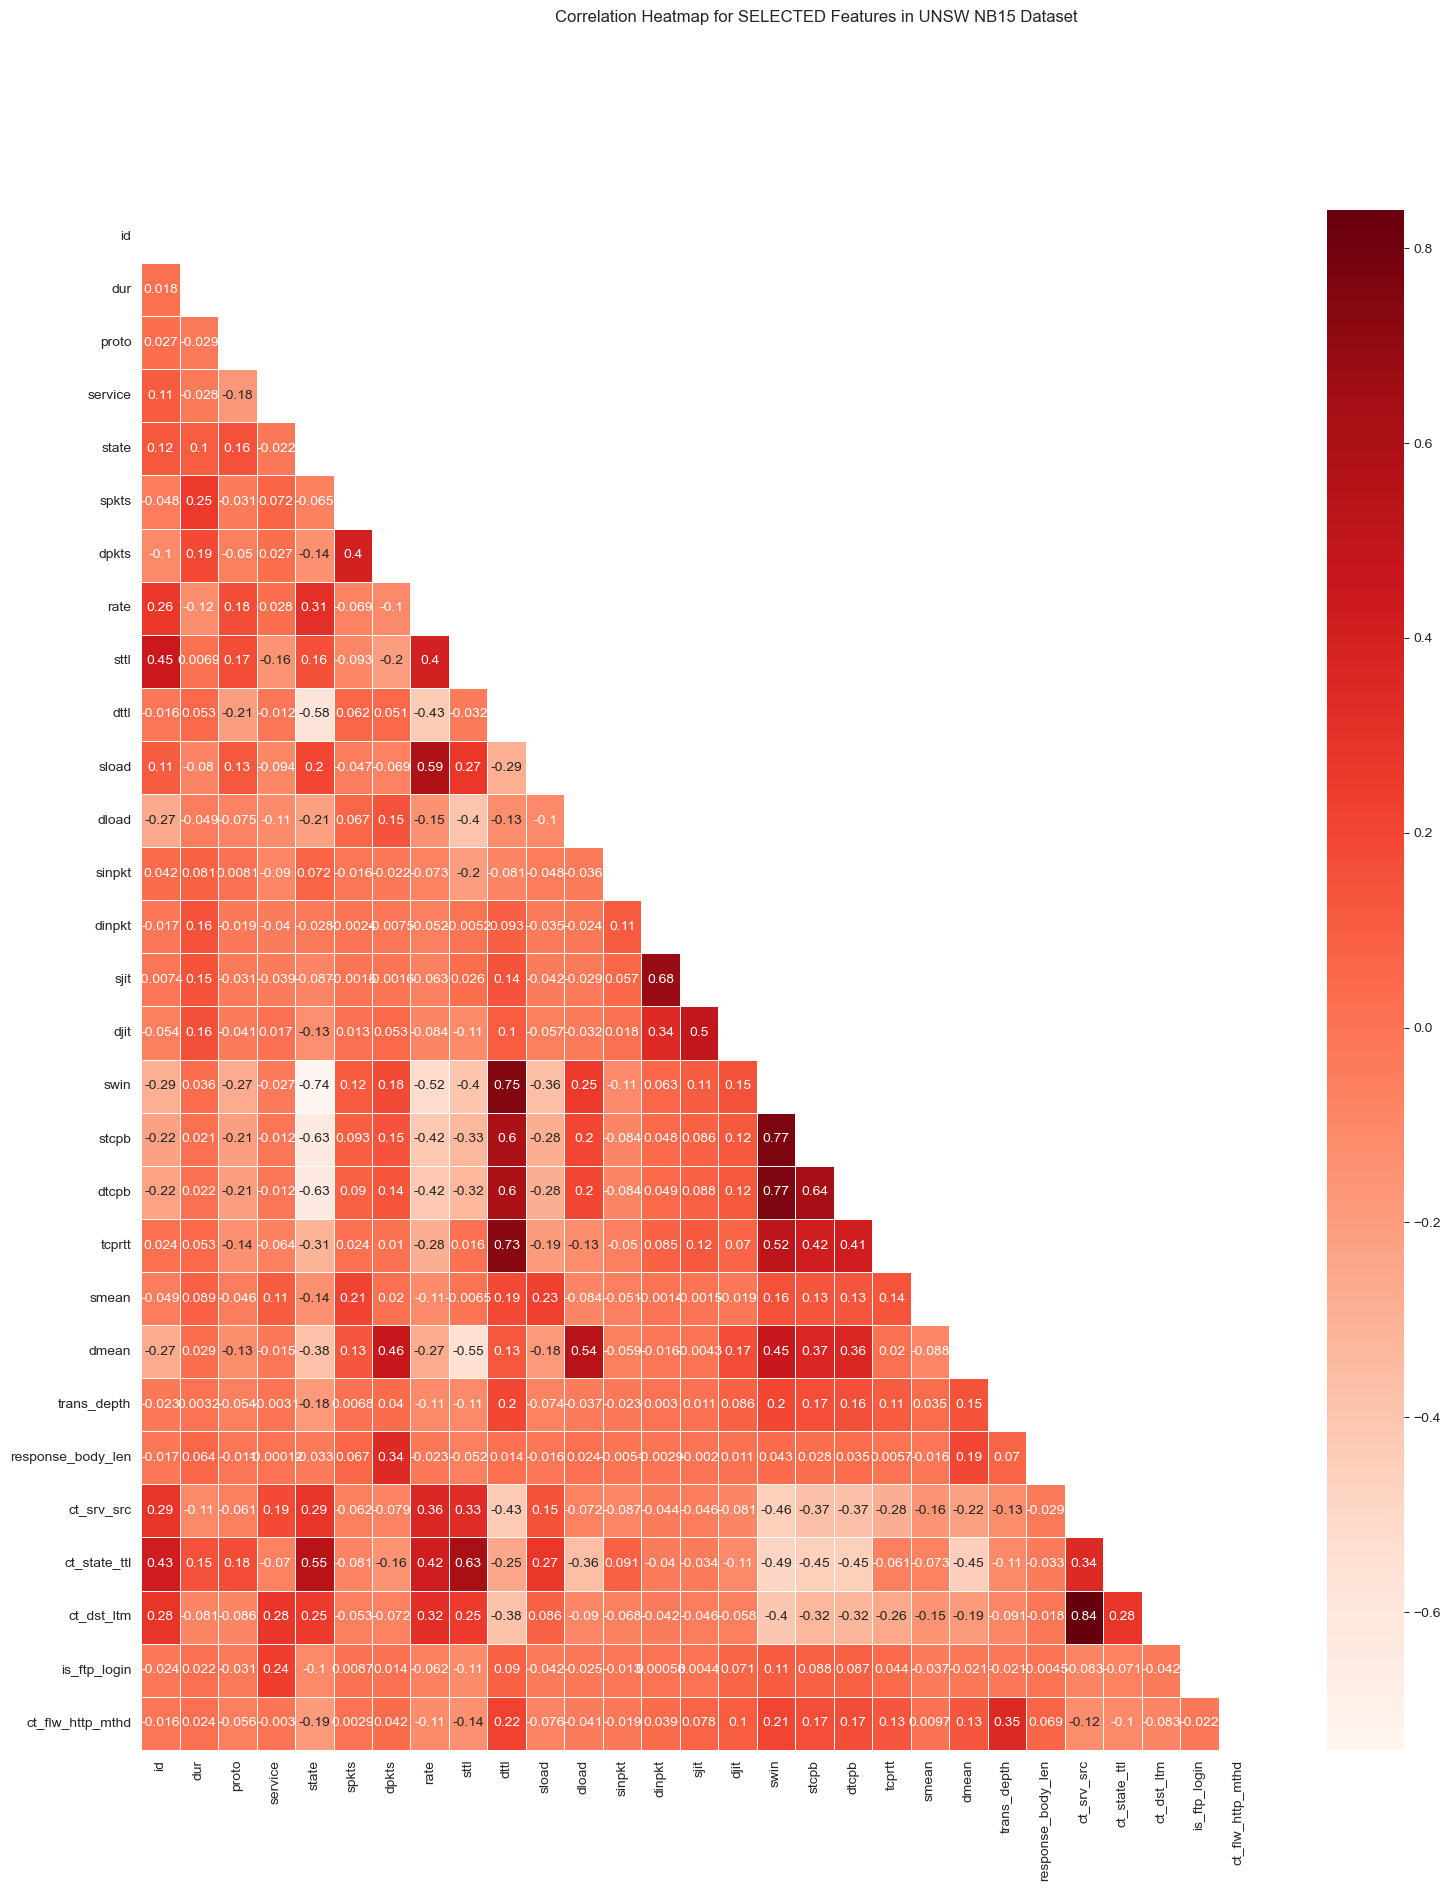

In [93]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [94]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [95]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [96]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [97]:
ros = SMOTE()
start_time = time.time()
kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)
unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)
end_time = time.time()       
print("\n")
print("\n")
print("\n")
print("TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT 2")
print("=========================================================")
print("\n")
print("{:.2f}".format(end_time - start_time))
print("\n")
print("\n")
print("\n")







TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT 2


27.93








In [98]:
print(kddcup_y_train.agg(['nunique','count','size']))
print("\n")
print(kddcup_y_train[kddcup_y_train == 0].count())
print("\n")
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique         2
count      127832
size       127832
Name: traffic_type, dtype: int64


63916


63916


In [99]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique         2
count      102000
size       102000
Name: traffic_type, dtype: int64


51000


51000


In [100]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment II

In [101]:
experiment_type = "EXPERIMENT-TWO"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      4026
      Attack       0.99      1.00      1.00     15974

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000







CONFUSION MATRIX




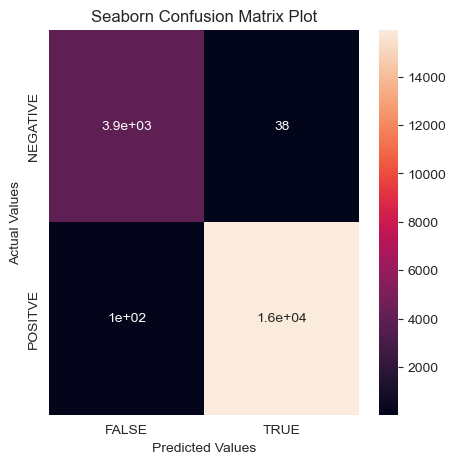







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9920
GEOMETRIC MEAN SCORE:  0.9920






TIME TAKEN TO COMPLETE MODEL ANALYSIS


41.96










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.77      0.73      0.75      7474
      Attack       0.84      0.87      0.86     12526

    accuracy                           0.82     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.82      0.82      0.82     20000







CONFUSION MATRIX




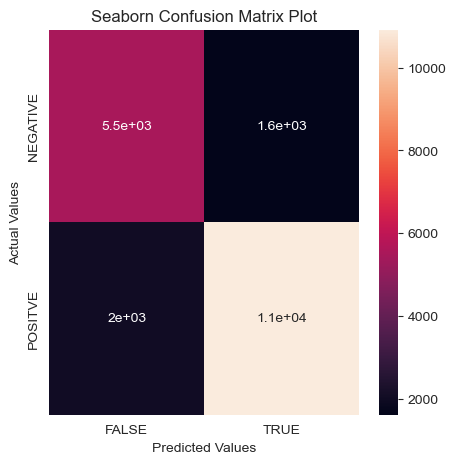







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8085
GEOMETRIC MEAN SCORE:  0.8077






TIME TAKEN TO COMPLETE MODEL ANALYSIS


23.14








In [102]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      3981
      Attack       1.00      1.00      1.00     16019

    accuracy                           1.00     20000
   macro avg       1.00      0.99      1.00     20000
weighted avg       1.00      1.00      1.00     20000







CONFUSION MATRIX




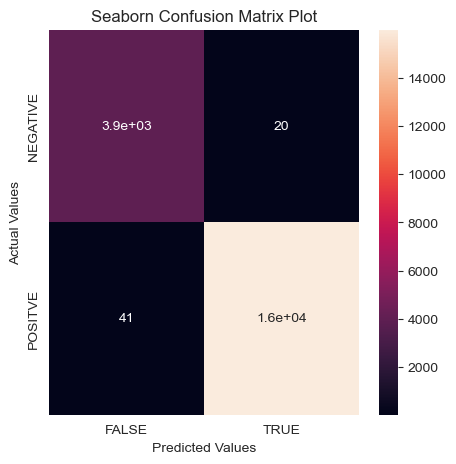







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9962
GEOMETRIC MEAN SCORE:  0.9962






TIME TAKEN TO COMPLETE MODEL ANALYSIS


4094.39








In [ ]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment II

In [ ]:
Exp_2_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
Exp_2_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
Exp_2_KDD_Analysis_Summary_df

In [ ]:
Exp_2_UNSWNB15_Analysis_Summary_df

#### Repeat Experiment II

In [ ]:
experiment_type = "EXPERIMENT-TWO-REPEAT"

In [ ]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Repeat Experiment II

In [ ]:
Rep_Exp_2_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
Rep_Exp_2_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
Rep_Exp_2_KDD_Analysis_Summary_df

In [ ]:
Rep_Exp_2_UNSWNB15_Analysis_Summary_df